# Aggregate/truncate generated network

The current goal is to take the constituent inferred networks and produce the best aggregate network possible, without referring to the Chip-Seq dataset (we want to hold it out for proper testing/evaluation after the fact). To do this, we need to be able to benchmark these networks -- ideally even benchmarking by length as well, to only keep the most high confidence edges.

To start this notebook exploration, I have a twofold idea for validation:
1. To benchmark against known relationships, compare against a published Mtb TRN. It doesn't have to be complete -- it only needs to provide some high-confidence relationships that we can check for in our network. (Hopefully well-characterized relationships are more obvious in existing data.) _*Our network should have a decent chunk of these published relationships*_. I think [this PLoS One, Sanz 2011 paper](https://pubmed.ncbi.nlm.nih.gov/21818301), specifically [supplemental material S1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3139605/bin/pone.0022178.s003.txt), should do the trick. And, this can give us a first quantification for the enrichment of the networks.
1. To benchmark for previously unknown, I think maybe we check these networks against each other. If we aggregate all the compendium networks, and aggregate all the TFOE networks, we should have two completely independent datasets that we can compare. Edges that they have in common will be higher confidence. We can quantify how much is shared, both of published and unpublished relationships.
1. Once we're all done refining the network, we can check against Chip-Seq and see how we perform. (Probably with MCC.)

In [1]:
import math
import os
import random
import re
import sys
import tempfile
import time
import warnings

import numpy as np
import networkx as nx
import pyarrow as pa
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import ScalarFormatter
import scipy.interpolate
import scipy.stats
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.stats.multitest

sys.path.append('../..')
import aggregate_networks
import chip_validation2

pd.set_option('display.precision', 2)
%matplotlib inline

---

## Read in all the relevant data

In [2]:
annotation_df = pd.read_csv('../../../Papers/Mycobacterium_tuberculosis_H37Rv_txt_v5.txt',
    sep='\t', index_col=None, usecols=['Locus', 'Name'])
annotation_df = annotation_df[~annotation_df['Locus'].str.startswith('MTB')]

regulators_df = pd.read_csv('../../mount2/mtb_tfs_20240213.txt', header=None)

regulatory_space = pd.Index(
    data=((regulator, gene) for regulator in regulators_df[0] for gene in annotation_df['Locus'].unique()),
    name=('Regulator', 'Gene')
)
regulatory_space

MultiIndex([('Rv0019c', 'Rv2007c'),
            ('Rv0019c',  'Rv3451'),
            ('Rv0019c',  'Rv3452'),
            ('Rv0019c', 'Rv2658c'),
            ('Rv0019c', 'Rv2612c'),
            ('Rv0019c', 'Rv1724c'),
            ('Rv0019c',  'Rv1772'),
            ('Rv0019c', 'Rv1778c'),
            ('Rv0019c', 'Rv1914c'),
            ('Rv0019c',  'Rv1957'),
            ...
            ( 'Rv3911',  'Rv3913'),
            ( 'Rv3911', 'Rv3918c'),
            ( 'Rv3911', 'Rv3916c'),
            ( 'Rv3911', 'Rv3919c'),
            ( 'Rv3911', 'Rv3920c'),
            ( 'Rv3911',  'Rv3216'),
            ( 'Rv3911', 'Rv3924c'),
            ( 'Rv3911', 'Rv0277A'),
            ( 'Rv3911', 'Rv2427A'),
            ( 'Rv3911', 'Rv3922c')],
           names=['Regulator', 'Gene'], length=862634)

In [3]:
# set up data

tfoe_mapping = {
	'Rv0061': 'Rv0061c',
	'Rv2427Ac': 'Rv2427A',
}

tfoe_extra = [ # maybe generate this list by TFOE_genes - annotation_genes?
	'Rv1784', 'Rvns01', 'Rvns02', 'Rvnt01', 'Rvnt02', 'Rvnt03', 'Rvnt05', 'Rvnt06', 'Rvnt07', 'Rvnt08', 'Rvnt11', 'Rvnt12',
    'Rvnt13', 'Rvnt15', 'Rvnt17', 'Rvnt19', 'Rvnt21', 'Rvnt22', 'Rvnt24', 'Rvnt27', 'Rvnt28', 'Rvnt29', 'Rvnt30', 'Rvnt32',
    'Rvnt33', 'Rvnt34', 'Rvnt40', 'Rvnt41'
]

constituent_networks_df = pd.DataFrame((
    ('ARACNe', 'RNA', '../aracne_mtb-rna-20240625-50b-pneg6_nonoperon.txt',),
    ('ARACNe', 'TFOE', '../aracne_tfoefullpysnail-50b-pneg6_nonoperon.txt',),
    ('CLR', 'RNA', '../clr_mtb-rna-20240625_nonoperon.txt',),
    ('CLR', 'TFOE', '../clr_tfoefullpysnail_nonoperon.txt',),
    ('cMonkey2', 'RNA', '../cmonkey2_mtb-rna-20240625_nonoperon.txt',),
    ('cMonkey2', 'TFOE', '../cmonkey2_tfoe-full-pysnail_nonoperon.txt',),
    ('Elasticnet', 'RNA', '../elasticnet_v0.2_mtb-rna-20240625_nonoperon.txt',),
    ('Elasticnet', 'TFOE', '../elasticnet_v0.2_tfoe-full-pysnail_nonoperon.txt',),
    ('GENIE3', 'RNA', '../genie3_mtb-rna-20240625_nonoperon.txt',),
    ('GENIE3', 'TFOE', '../genie3_tfoe-full-pysnail_nonoperon.txt',),
    ('iModulon', 'RNA', '../imodulon_mtb-rna-20240625_nonoperon_dedup.txt',),
    ('iModulon', 'TFOE', '../imodulon_tfoe-full-pysnail_nonoperon_dedup.txt',),
), columns=['Method', 'Dataset', 'File'])

# read in each file

constituent_networks_df['network_df'] = constituent_networks_df['File'].map(
    lambda file: pd.read_csv(file, sep='\t', header=None, index_col=None, names=['Regulator', 'Gene', 'Score'])
)

# assign Rank column to each constituent network df

constituent_networks_df['network_df'].map( # don't set it back to the column: insert returns void; just use `map` as essentially a looping construct
    lambda df: df.insert(2, 'Rank', df.index.to_series() + 1)
)

# fix misannotations and drop out of scope genes in each constituent TFOE network df

for network_df in constituent_networks_df.loc[constituent_networks_df['Dataset'].eq('TFOE'), 'network_df']:
    network_df_invalid = network_df[network_df['Gene'].isin(tfoe_extra) | network_df['Regulator'].isin(tfoe_extra)]
    network_df.drop(index=network_df_invalid.index, inplace=True)
    network_df['Gene'] = network_df['Gene'].map(lambda gene: tfoe_mapping[gene] if gene in tfoe_mapping else gene)
    network_df['Regulator'] = network_df['Regulator'].map(lambda gene: tfoe_mapping[gene] if gene in tfoe_mapping else gene)
    network_df.reset_index(inplace=True)

constituent_networks_df

,Method,Dataset,File,network_df
0,ARACNe,RNA,../aracne_mtb-rna-20240625-50b-pneg6_nonoperon...,Regulator Gene Rank Score 0 ...
1,ARACNe,TFOE,../aracne_tfoefullpysnail-50b-pneg6_nonoperon.txt,index Regulator Gene Rank Score ...
2,CLR,RNA,../clr_mtb-rna-20240625_nonoperon.txt,Regulator Gene Rank Score 0 ...
3,CLR,TFOE,../clr_tfoefullpysnail_nonoperon.txt,index Regulator Gene Rank ...
4,cMonkey2,RNA,../cmonkey2_mtb-rna-20240625_nonoperon.txt,Regulator Gene Rank Score 0 ...
5,cMonkey2,TFOE,../cmonkey2_tfoe-full-pysnail_nonoperon.txt,index Regulator Gene Rank Sco...
6,Elasticnet,RNA,../elasticnet_v0.2_mtb-rna-20240625_nonoperon.txt,Regulator Gene Rank Score 0 ...
7,Elasticnet,TFOE,../elasticnet_v0.2_tfoe-full-pysnail_nonoperon...,index Regulator Gene Rank ...
8,GENIE3,RNA,../genie3_mtb-rna-20240625_nonoperon.txt,Regulator Gene Rank Score 0 ...
9,GENIE3,TFOE,../genie3_tfoe-full-pysnail_nonoperon.txt,index Regulator Gene Rank Sco...


In [4]:
sanz_sources_df = pd.read_csv('../../../Papers/Sanz2011_SupplementalMaterialS1.txt',
    sep='\t', header=None, index_col=0, names=['Source'],
    skiprows=7, nrows=65)

sanz_sources_df.rename(index={ # best guess at mismatch between reference list and usage
    '63a': '63',
    '63b': '64',
}, inplace=True)

sanz_methods_df = pd.read_csv('../../../Papers/Sanz2011_SupplementalMaterialS1.txt',
    sep='\t', header=None, index_col=0, names=['Methodology'],
    skiprows=75, nrows=22)

sanz_network_df = pd.read_csv('../../../Papers/Sanz2011_SupplementalMaterialS1.txt',
    sep=r'\s+', header=None, index_col=None, names=['Reg_idx', 'Target_idx', 'Regulator', 'Target', 'Sources_code', 'Methods_code'],
    skiprows=98)

sanz_network_df[['Sources_count', 'Sources_csv']] = sanz_network_df['Sources_code'].str.split(':', expand=True)
sanz_network_df[['Methods_count', 'Methods_csv']] = sanz_network_df['Methods_code'].str.split(':', expand=True)

sanz_network_df['Source'] = sanz_network_df['Sources_csv'].map(
    lambda source: np.nan if ',' in source else sanz_sources_df.at[source, 'Source'])
sanz_network_df['Method'] = sanz_network_df['Methods_csv'].map(
    lambda method: np.nan if ',' in method else sanz_methods_df.at[int(method), 'Methodology'])  # why int() here but not for source? I don't know; it works.

# display(sanz_sources_df)
# display(sanz_methods_df)
sanz_network_df

,Reg_idx,Target_idx,Regulator,Target,Sources_code,Methods_code,Sources_count,Sources_csv,Methods_count,Methods_csv,Source,Method
0,1,1,Rv0001,Rv0001,"2:0,62",1:13,2,"0,62",1,13,NaN,E.coli orthology based inference
1,1,2,Rv0001,Rv0002,"2:0,62",1:13,2,"0,62",1,13,NaN,E.coli orthology based inference
2,1,3,Rv0001,Rv0003,"2:0,62",1:13,2,"0,62",1,13,NaN,E.coli orthology based inference
3,1,4,Rv0001,Rv3396c,"2:0,62",1:13,2,"0,62",1,13,NaN,E.coli orthology based inference
4,1,5,Rv0001,Rv3411c,"2:0,62",1:13,2,"0,62",1,13,NaN,E.coli orthology based inference
...,...,...,...,...,...,...,...,...,...,...,...,...
3207,198,1205,Rv1846c,Rv3919c,1:64,1:22,1,64,1,22,Mtbreglist database referred to experimental w...,Operon extension based link.
3208,198,1524,Rv1846c,Rv3920c,1:64,1:22,1,64,1,22,Mtbreglist database referred to experimental w...,Operon extension based link.
3209,198,828,Rv1846c,Rv3922c,1:64,1:22,1,64,1,22,Mtbreglist database referred to experimental w...,Operon extension based link.
3210,198,829,Rv1846c,Rv3923c,1:64,1:22,1,64,1,22,Mtbreglist database referred to experimental w...,Operon extension based link.


In [5]:
print(sanz_methods_df.shape)
sanz_methods_df.head()

(22, 1)


,Methodology
1,Literature previously reported link (from Bala...
2,Microarrays
3,qRT-PCR
4,LacZ-promoter fusion
5,Gfp-promoter fusion


Interesting.... There's a chance we want to exclude some of these methodologies, if we're going for a concrete set of edges likely to be surfaced with a method like ours (in theory).

Shuyi likes methods 4-9

In [6]:
print('Whole Sanz network:', len(sanz_network_df))

print('Only including at least one method considered rock solid:')
solid_methods = ['4', '5', '6', '7', '8', '9']#, '12', '18', '19', '21']
sanz_network_df['Methods_csv'].map(lambda csv: any(method in csv.split(',') for method in solid_methods)).sum()

Whole Sanz network: 3212
Only including at least one method considered rock solid:


449

### Sanz solid set of relationships

In [7]:
sanz_solid_df = sanz_network_df[sanz_network_df['Methods_csv'].map(lambda csv: any(method in csv.split(',') for method in solid_methods))].copy()
sanz_solid_df

,Reg_idx,Target_idx,Regulator,Target,Sources_code,Methods_code,Sources_count,Sources_csv,Methods_count,Methods_csv,Source,Method
6,6,7,Rv0117,Rv1908c,"3:0,8,62","2:13,8",3,"0,8,62",2,"13,8",NaN,NaN
16,17,20,Rv0353,Rv0350,"4:0,36,37,63","5:1,2,11,16,7",4,"0,36,37,63",5,"1,2,11,16,7",NaN,NaN
25,28,30,Rv0491,Rv0490,"4:0,38,62,63","4:1,13,7,11",4,"0,38,62,63",4,"1,13,7,11",NaN,NaN
50,55,55,Rv0967,Rv0967,"2:0,24","3:1,3,7",2,"0,24",3,"1,3,7",NaN,NaN
53,58,58,Rv0981,Rv0981,"3:0,9,26","5:1,2,3,7,11",3,"0,9,26",5,"1,2,3,7,11",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2116,198,1084,Rv1846c,Rv1309,1:31,"3:3,9,11",1,31,3,"3,9,11","Sala, C. et al. (2009): Mol Microbiol. 71: blaI.",NaN
2117,198,981,Rv1846c,Rv1310,1:31,"3:3,9,11",1,31,3,"3,9,11","Sala, C. et al. (2009): Mol Microbiol. 71: blaI.",NaN
2118,198,1299,Rv1846c,Rv1311,1:31,"3:3,9,11",1,31,3,"3,9,11","Sala, C. et al. (2009): Mol Microbiol. 71: blaI.",NaN
2119,198,982,Rv1846c,Rv1312,1:31,"3:3,9,11",1,31,3,"3,9,11","Sala, C. et al. (2009): Mol Microbiol. 71: blaI.",NaN


In [8]:
annotation_df2 = annotation_df.drop_duplicates(subset='Locus').set_index('Locus')

sanz_solid_df['RegName'] = sanz_solid_df['Regulator'].map(annotation_df2['Name'])
sanz_solid_df['TarName'] = sanz_solid_df['Target'].map(annotation_df2['Name'])
sanz_solid_df[['RegName', 'TarName']].head()

,RegName,TarName
6,oxyS,katG
16,hspR,dnaK
25,regX3,senX3
50,csoR,csoR
53,mprA,mprA


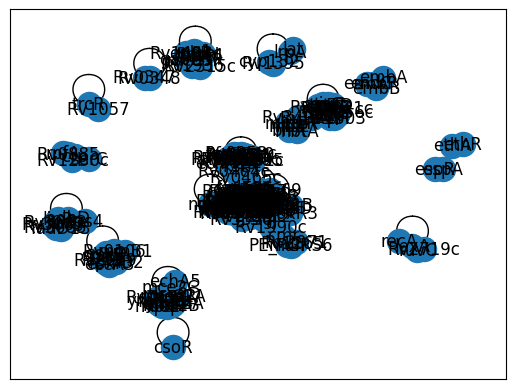

In [9]:
sanz_g = nx.from_pandas_edgelist(sanz_solid_df, 'RegName', 'TarName')
nx.draw_networkx(sanz_g, with_labels=True)

In [10]:
# exclude self-regulation -- we're excluding that from our analysis
sanz_solid_df = sanz_solid_df[~sanz_solid_df['Regulator'].eq(sanz_solid_df['Target'])].copy()
print(sanz_solid_df.shape)

(433, 14)


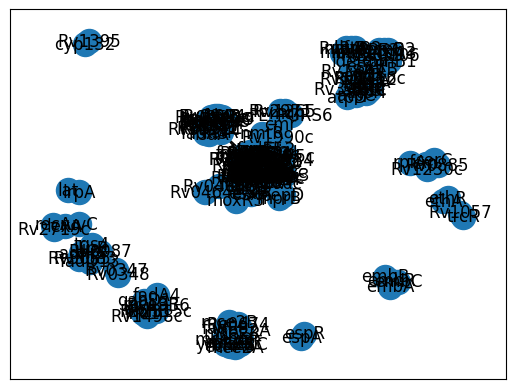

In [11]:
sanz_g = nx.from_pandas_edgelist(sanz_solid_df, 'RegName', 'TarName')
nx.draw_networkx(sanz_g, with_labels=True)

ugh, use Cytoscape

In [129]:
sanz_solid_df.to_csv('sanz_solid_df_full.csv', sep='\t', index=False)

## MCC vs Sanz

In [12]:
# takes a network df, with Regulator and Edge columns
# takes truth_edges as Series containing underscore-delimited strings representing each true edge
def calc_mccs(network_df, truth_edges, start=len(regulators_df), stop=None):
    if stop is None:
        stop = len(network_df)
        
    if 'Edge' not in network_df:
        network_df = network_df.copy()
        network_df['Edge'] = network_df['Regulator'].str.cat(network_df['Gene'], sep='_')

    truth_edges_set = set(truth_edges)
    mccs = []
    
    true_pos, false_pos, false_neg, true_neg = 0, 0, 0, 0
    for size in range(start, stop, 1): # step must be 1 for this method to work
        if size == start:
            true_pos, false_pos, false_neg, true_neg = chip_validation2.confusion_matrix(
            	truth_edges, network_df.loc[:size, 'Edge'], len(regulatory_space)) # note: slice here is inclusive
        else:
            next_edge = network_df.at[size, 'Edge']
            if next_edge in truth_edges_set: # a false negative has become a true positive
                false_neg -= 1
                true_pos += 1
            else: # a true negative has become a false positive
                true_neg -= 1
                false_pos += 1

        n = true_pos + true_neg + false_neg + false_pos
        s = (true_pos + false_neg) / n
        p = (true_pos + false_pos) / n
        mcc = (true_pos / n - s * p) / math.sqrt(p * s * (1 - s) * (1 - p))
        mccs.append(mcc)

    # max_ = max(mccs)
    # return mccs, max_, mccs.index(max_)
    return mccs

In [13]:
for i in range(len(constituent_networks_df)):
    start = time.time()
    df = constituent_networks_df.at[i, 'network_df']
    mccs_i = calc_mccs(df, sanz_solid_df['Regulator'].str.cat(sanz_solid_df['Target'], sep='_'))
    df.loc[len(regulators_df):, 'MCC'] = mccs_i
    print(f'Network {i} finished MCC calculation in {time.time() - start:.2f} seconds')

Network 0 finished MCC calculation in 0.13 seconds
Network 1 finished MCC calculation in 0.12 seconds
Network 2 finished MCC calculation in 1.59 seconds
Network 3 finished MCC calculation in 1.60 seconds
Network 4 finished MCC calculation in 0.64 seconds
Network 5 finished MCC calculation in 0.84 seconds
Network 6 finished MCC calculation in 2.00 seconds
Network 7 finished MCC calculation in 1.10 seconds
Network 8 finished MCC calculation in 0.42 seconds
Network 9 finished MCC calculation in 0.43 seconds
Network 10 finished MCC calculation in 0.32 seconds
Network 11 finished MCC calculation in 0.04 seconds


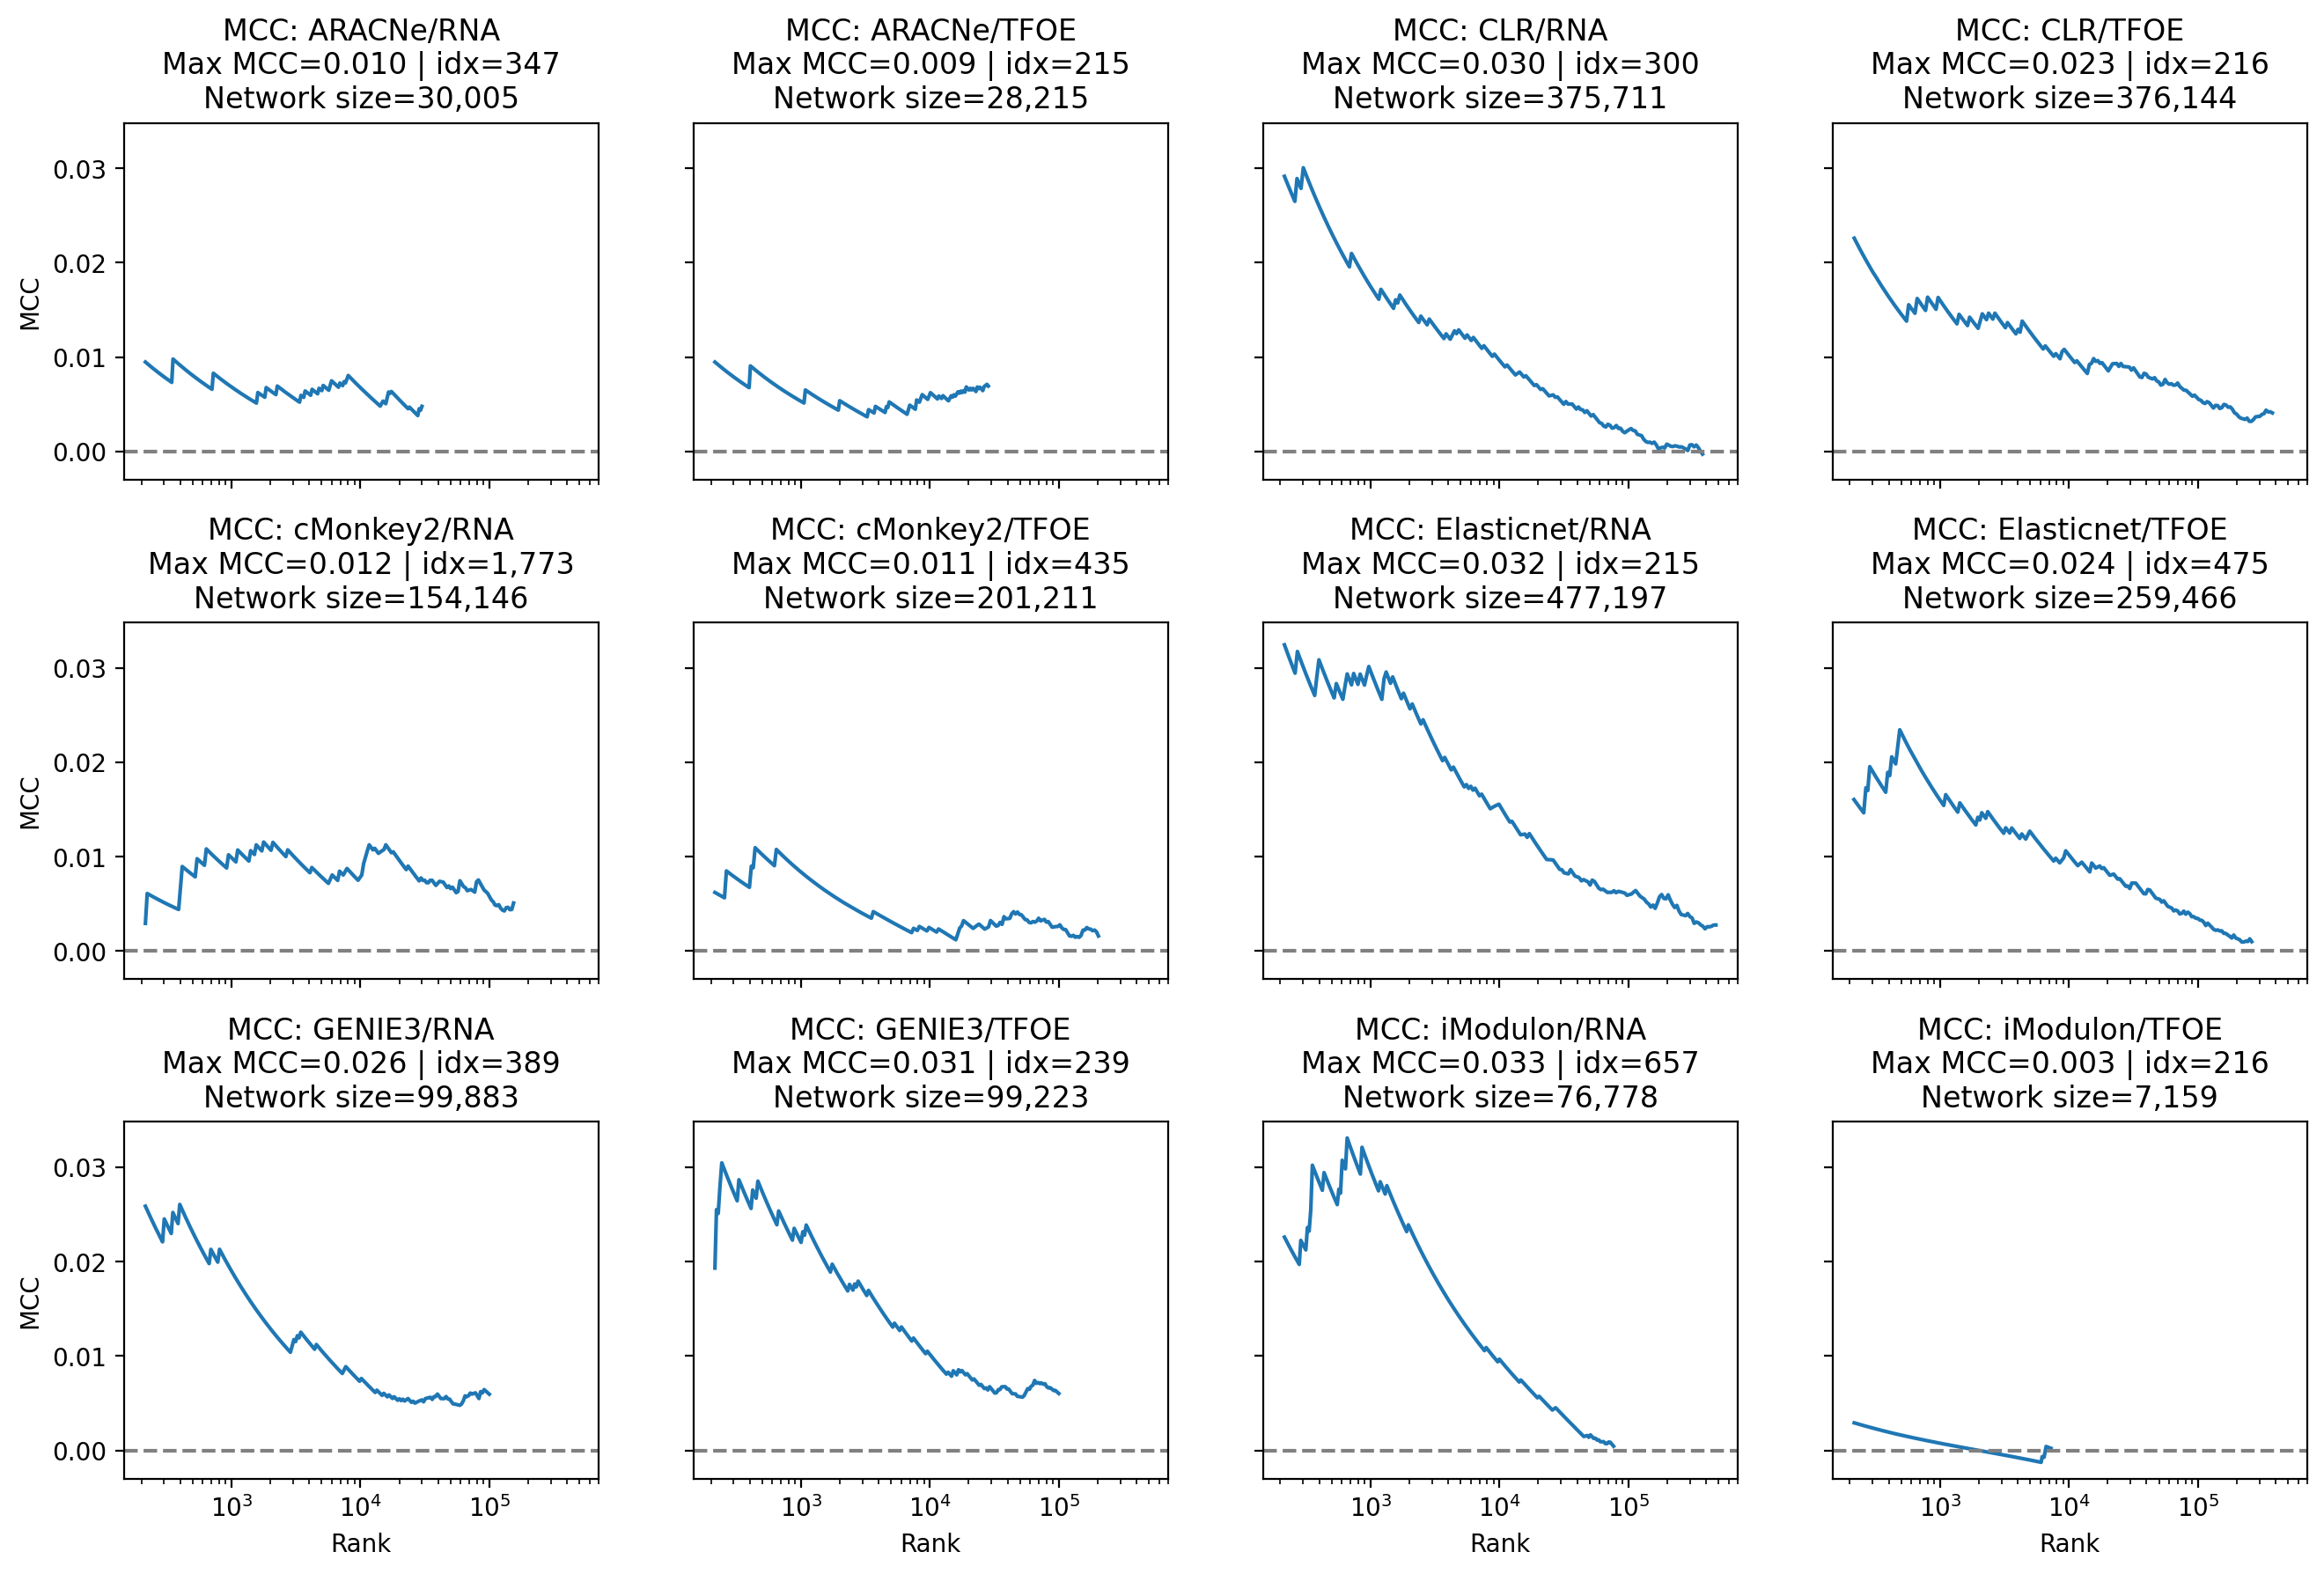

In [14]:
fig = plt.figure(figsize=(16, 10), dpi=200)
axs = fig.subplots(nrows=3, ncols=4, sharex=True, sharey=True, squeeze=True, gridspec_kw={'hspace': 0.4}).flatten()

for i in range(len(axs)):
    df_i = constituent_networks_df.at[i, 'network_df']
    max_mcc = df_i['MCC'].max()
    ax = sns.lineplot(
        # data=df_i.iloc[list(range(len(regulators_df), len(df_i), len(df_i)//1000)), :],
        data=df_i.iloc[[int(n) for n in np.geomspace(len(regulators_df), len(df_i)-1, 200)], :],
        x='Rank', y='MCC', ax=axs[i])
    ax.set_xscale('log', base=10)
    ax.axhline(y=0, color='grey', linestyle='--')
    ax.set_title((
        'MCC: '
        f"{constituent_networks_df.at[i, 'Method']}/{constituent_networks_df.at[i, 'Dataset']}\n"
        f"Max MCC={max_mcc:.3f} | "
        f"idx={df_i.loc[df_i['MCC'].eq(max_mcc), 'Rank'].iloc[0]:,}\n"
        f"Network size={len(df_i):,}"))

## Compare vs random

In [15]:
regulatory_space_list = regulatory_space.to_list()

def random_network(size):
    return pd.DataFrame(
        data=list(range(1, size+1)),
        index=pd.MultiIndex.from_tuples(random.sample(regulatory_space_list, k=size), names=['Regulator', 'Gene']),
        columns=['Rank'],
    ).reset_index()

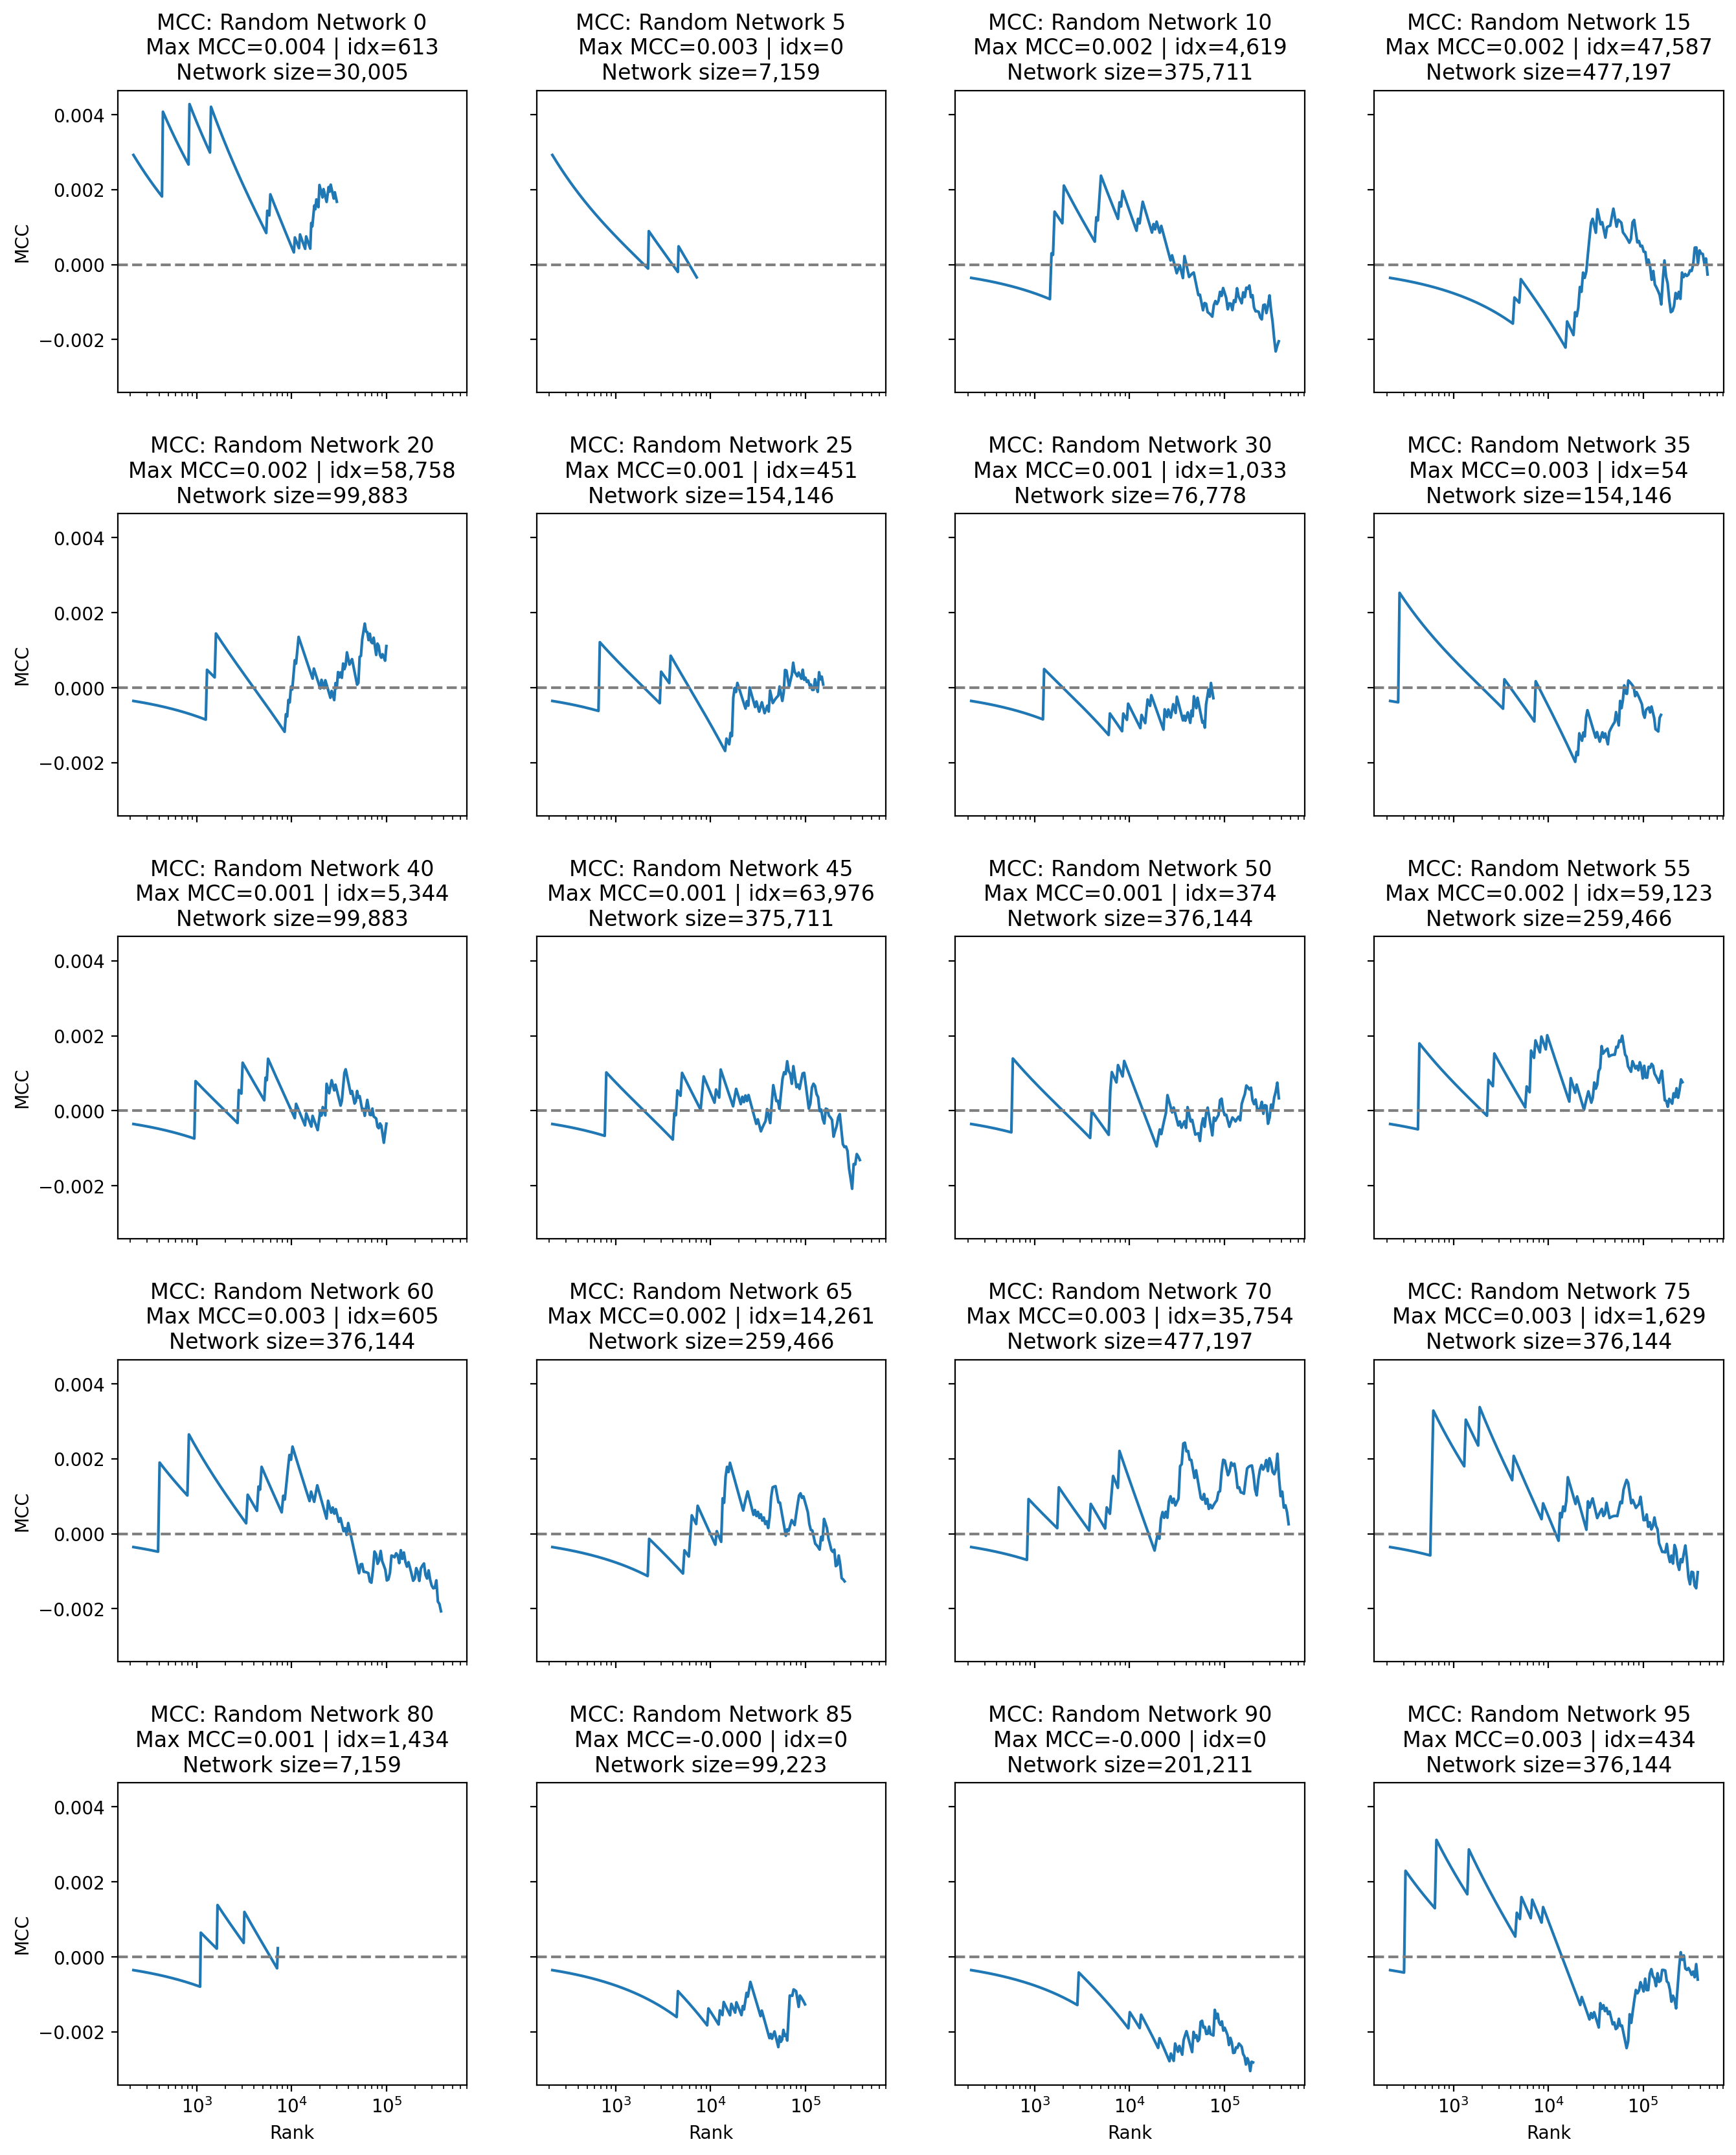

In [16]:
simulations = 100

plot_count = 20
random_mccs = []

fig = plt.figure(figsize=(16, plot_count), dpi=200)
axs = fig.subplots(nrows=math.ceil(plot_count/4), ncols=4, sharex=True, sharey=True, squeeze=True, gridspec_kw={'hspace': 0.4}).flatten()
plot_idxs = list(range(0, simulations, simulations//plot_count))

sizes = [len(constituent_networks_df.at[i, 'network_df']) for i in range(len(constituent_networks_df))]
truth_edges = sanz_solid_df['Regulator'].str.cat(sanz_solid_df['Target'], sep='_')

for i in range(simulations):
    size = random.choice(sizes)
    df_i = random_network(size)

    mccs_i = calc_mccs(df_i, truth_edges)
    df_i.loc[len(regulators_df):, 'MCC'] = mccs_i
    random_mccs.append(mccs_i)
    max_mcc = df_i['MCC'].max()

    if i in plot_idxs:
        ax = axs[i * plot_count // simulations]
        ax = sns.lineplot(
            # data=df_i.iloc[list(range(len(regulators_df), len(df_i), len(df_i)//1000)), :],
            data=df_i.iloc[[int(n) for n in np.geomspace(len(regulators_df), len(df_i)-1, 200)], :],
            x='Rank', y='MCC', ax=ax)
        ax.set_xscale('log', base=10)
        ax.axhline(y=0, color='grey', linestyle='--')
        ax.set_title((
            f'MCC: Random Network {i}\n'
            f"Max MCC={max_mcc:.3f} | "
            f"idx={mccs_i.index(max_mcc):,}\n"
            f"Network size={len(df_i):,}"))

In [17]:
max_random100_mcc = max(max(mccs_list) for mccs_list in random_mccs)
max_random100_mcc

0.0068674339751354

In [14]:
randnet_spawner_df = pd.DataFrame(
    data=list(range(1, len(regulatory_space_list)+1)),
    index=pd.MultiIndex.from_tuples(regulatory_space_list, names=['Regulator', 'Gene']),
    columns=['Rank'],
).reset_index()
randnet_spawner_df['Edge'] = randnet_spawner_df['Regulator'].str.cat(randnet_spawner_df['Gene'], sep='_')

def random_network(size): # mutate a single df for this purpose, for memory's sake: 1000 simulations with new dfs floundered
    int_idxs = random.sample(range(len(regulatory_space_list)), k=size)
    randnet_spawner_df.iloc[int_idxs, 2] = range(1, size+1) # modifying the df is ok since we use one sample at a time; iloc 2 is Rank
    df_i = randnet_spawner_df.iloc[int_idxs, :] # use iloc so we aren't relying on our changing index
    df_i.reset_index(inplace=True)
    return df_i

In [99]:
simulations = 1000

max_random_mccs2 = np.zeros(simulations)
sizes = [len(constituent_networks_df.at[i, 'network_df']) for i in range(len(constituent_networks_df))]

start = time.time()
for i in range(simulations):
    size = random.choice(sizes)
    df_i = random_network(size)

    mccs_i = calc_mccs(df_i, truth_edges)
    max_random_mccs2[i] = max(mccs_i)

    if i % 100 == 99:
        print(i+1, 'iterations completed (', time.time() - start, 'seconds total elapsed so far )')

print('1000 random MCC simulations completed in', time.time() - start, 'seconds')

100 iterations completed ( 86.59785985946655 seconds total elapsed so far )
200 iterations completed ( 183.53978896141052 seconds total elapsed so far )
300 iterations completed ( 279.22639656066895 seconds total elapsed so far )
400 iterations completed ( 392.11009645462036 seconds total elapsed so far )
500 iterations completed ( 499.23068952560425 seconds total elapsed so far )
600 iterations completed ( 593.285261631012 seconds total elapsed so far )
700 iterations completed ( 693.6084365844727 seconds total elapsed so far )
800 iterations completed ( 809.4066767692566 seconds total elapsed so far )
900 iterations completed ( 909.8742125034332 seconds total elapsed so far )
1000 iterations completed ( 1027.1989812850952 seconds total elapsed so far )
1000 random MCC simulations completed in 1027.1989812850952 seconds


In [101]:
print('Max MCC achieved in 1000 simulations:', max(max_random_mccs2))

Max MCC achieved in 1000 simulations: 0.0064616590398913175


## Attempt to threshold using MCC

In [18]:
all_mccs = np.concatenate([df['MCC'].dropna() for df in constituent_networks_df['network_df']])
scipy.stats.describe(all_mccs)

DescribeResult(nobs=2182570, minmax=(-0.0012571465657122, 0.03315047462970703), mean=0.0043524237399278735, variance=9.614528294102639e-06, skewness=2.030348533280039, kurtosis=9.702149075347178)

In [19]:
print('Mean of means:')
np.mean([df['MCC'].mean() for df in constituent_networks_df['network_df']])

Mean of means:


0.0045311863948956175

In [20]:
print('Lowest max:')
min(df['MCC'].max() for df in constituent_networks_df['network_df'])

Lowest max:


0.0029248529572042346

In [21]:
print('\n'.join(f"{row['Method'] + '/' + row['Dataset']:>15s}: {row['network_df']['MCC'].max():.3f}" for idx, row in constituent_networks_df.iterrows()))

     ARACNe/RNA: 0.010
    ARACNe/TFOE: 0.009
        CLR/RNA: 0.030
       CLR/TFOE: 0.023
   cMonkey2/RNA: 0.012
  cMonkey2/TFOE: 0.011
 Elasticnet/RNA: 0.032
Elasticnet/TFOE: 0.024
     GENIE3/RNA: 0.026
    GENIE3/TFOE: 0.031
   iModulon/RNA: 0.033
  iModulon/TFOE: 0.003


## Or AUPR?

In [22]:
sanz_solid_df['Score'] = sanz_solid_df['Sources_count'].astype(int) * sanz_solid_df['Methods_count'].astype(int) / 100

sanz_solid_df[['Regulator', 'Target', 'Score']].to_csv('sanz_solid_df.csv', sep='\t', index=False, header=False)

In [23]:
constituent_networks_df['AUPR_sanz'] = constituent_networks_df['File'].map(
    lambda file: chip_validation2.main('sanz_solid_df.csv', file))

constituent_networks_df

,Method,Dataset,File,network_df,AUPR_sanz
0,ARACNe,RNA,../aracne_mtb-rna-20240625-50b-pneg6_nonoperon...,Regulator Gene Rank Score M...,2.14e-02
1,ARACNe,TFOE,../aracne_tfoefullpysnail-50b-pneg6_nonoperon.txt,index Regulator Gene Rank Score ...,5.99e-04
2,CLR,RNA,../clr_mtb-rna-20240625_nonoperon.txt,Regulator Gene Rank Score ...,5.93e-04
3,CLR,TFOE,../clr_tfoefullpysnail_nonoperon.txt,index Regulator Gene Rank ...,7.32e-04
4,cMonkey2,RNA,../cmonkey2_mtb-rna-20240625_nonoperon.txt,Regulator Gene Rank Score ...,7.08e-04
5,cMonkey2,TFOE,../cmonkey2_tfoe-full-pysnail_nonoperon.txt,index Regulator Gene Rank Sco...,5.58e-04
6,Elasticnet,RNA,../elasticnet_v0.2_mtb-rna-20240625_nonoperon.txt,Regulator Gene Rank Score ...,7.87e-04
7,Elasticnet,TFOE,../elasticnet_v0.2_tfoe-full-pysnail_nonoperon...,index Regulator Gene Rank ...,6.38e-04
8,GENIE3,RNA,../genie3_mtb-rna-20240625_nonoperon.txt,Regulator Gene Rank Score ...,2.26e-02
9,GENIE3,TFOE,../genie3_tfoe-full-pysnail_nonoperon.txt,index Regulator Gene Rank Sco...,7.17e-04


## Take a look at distribution

In [24]:
sanz_solid_df['Edge'] = sanz_solid_df['Regulator'].str.cat(sanz_solid_df['Target'], sep='_')

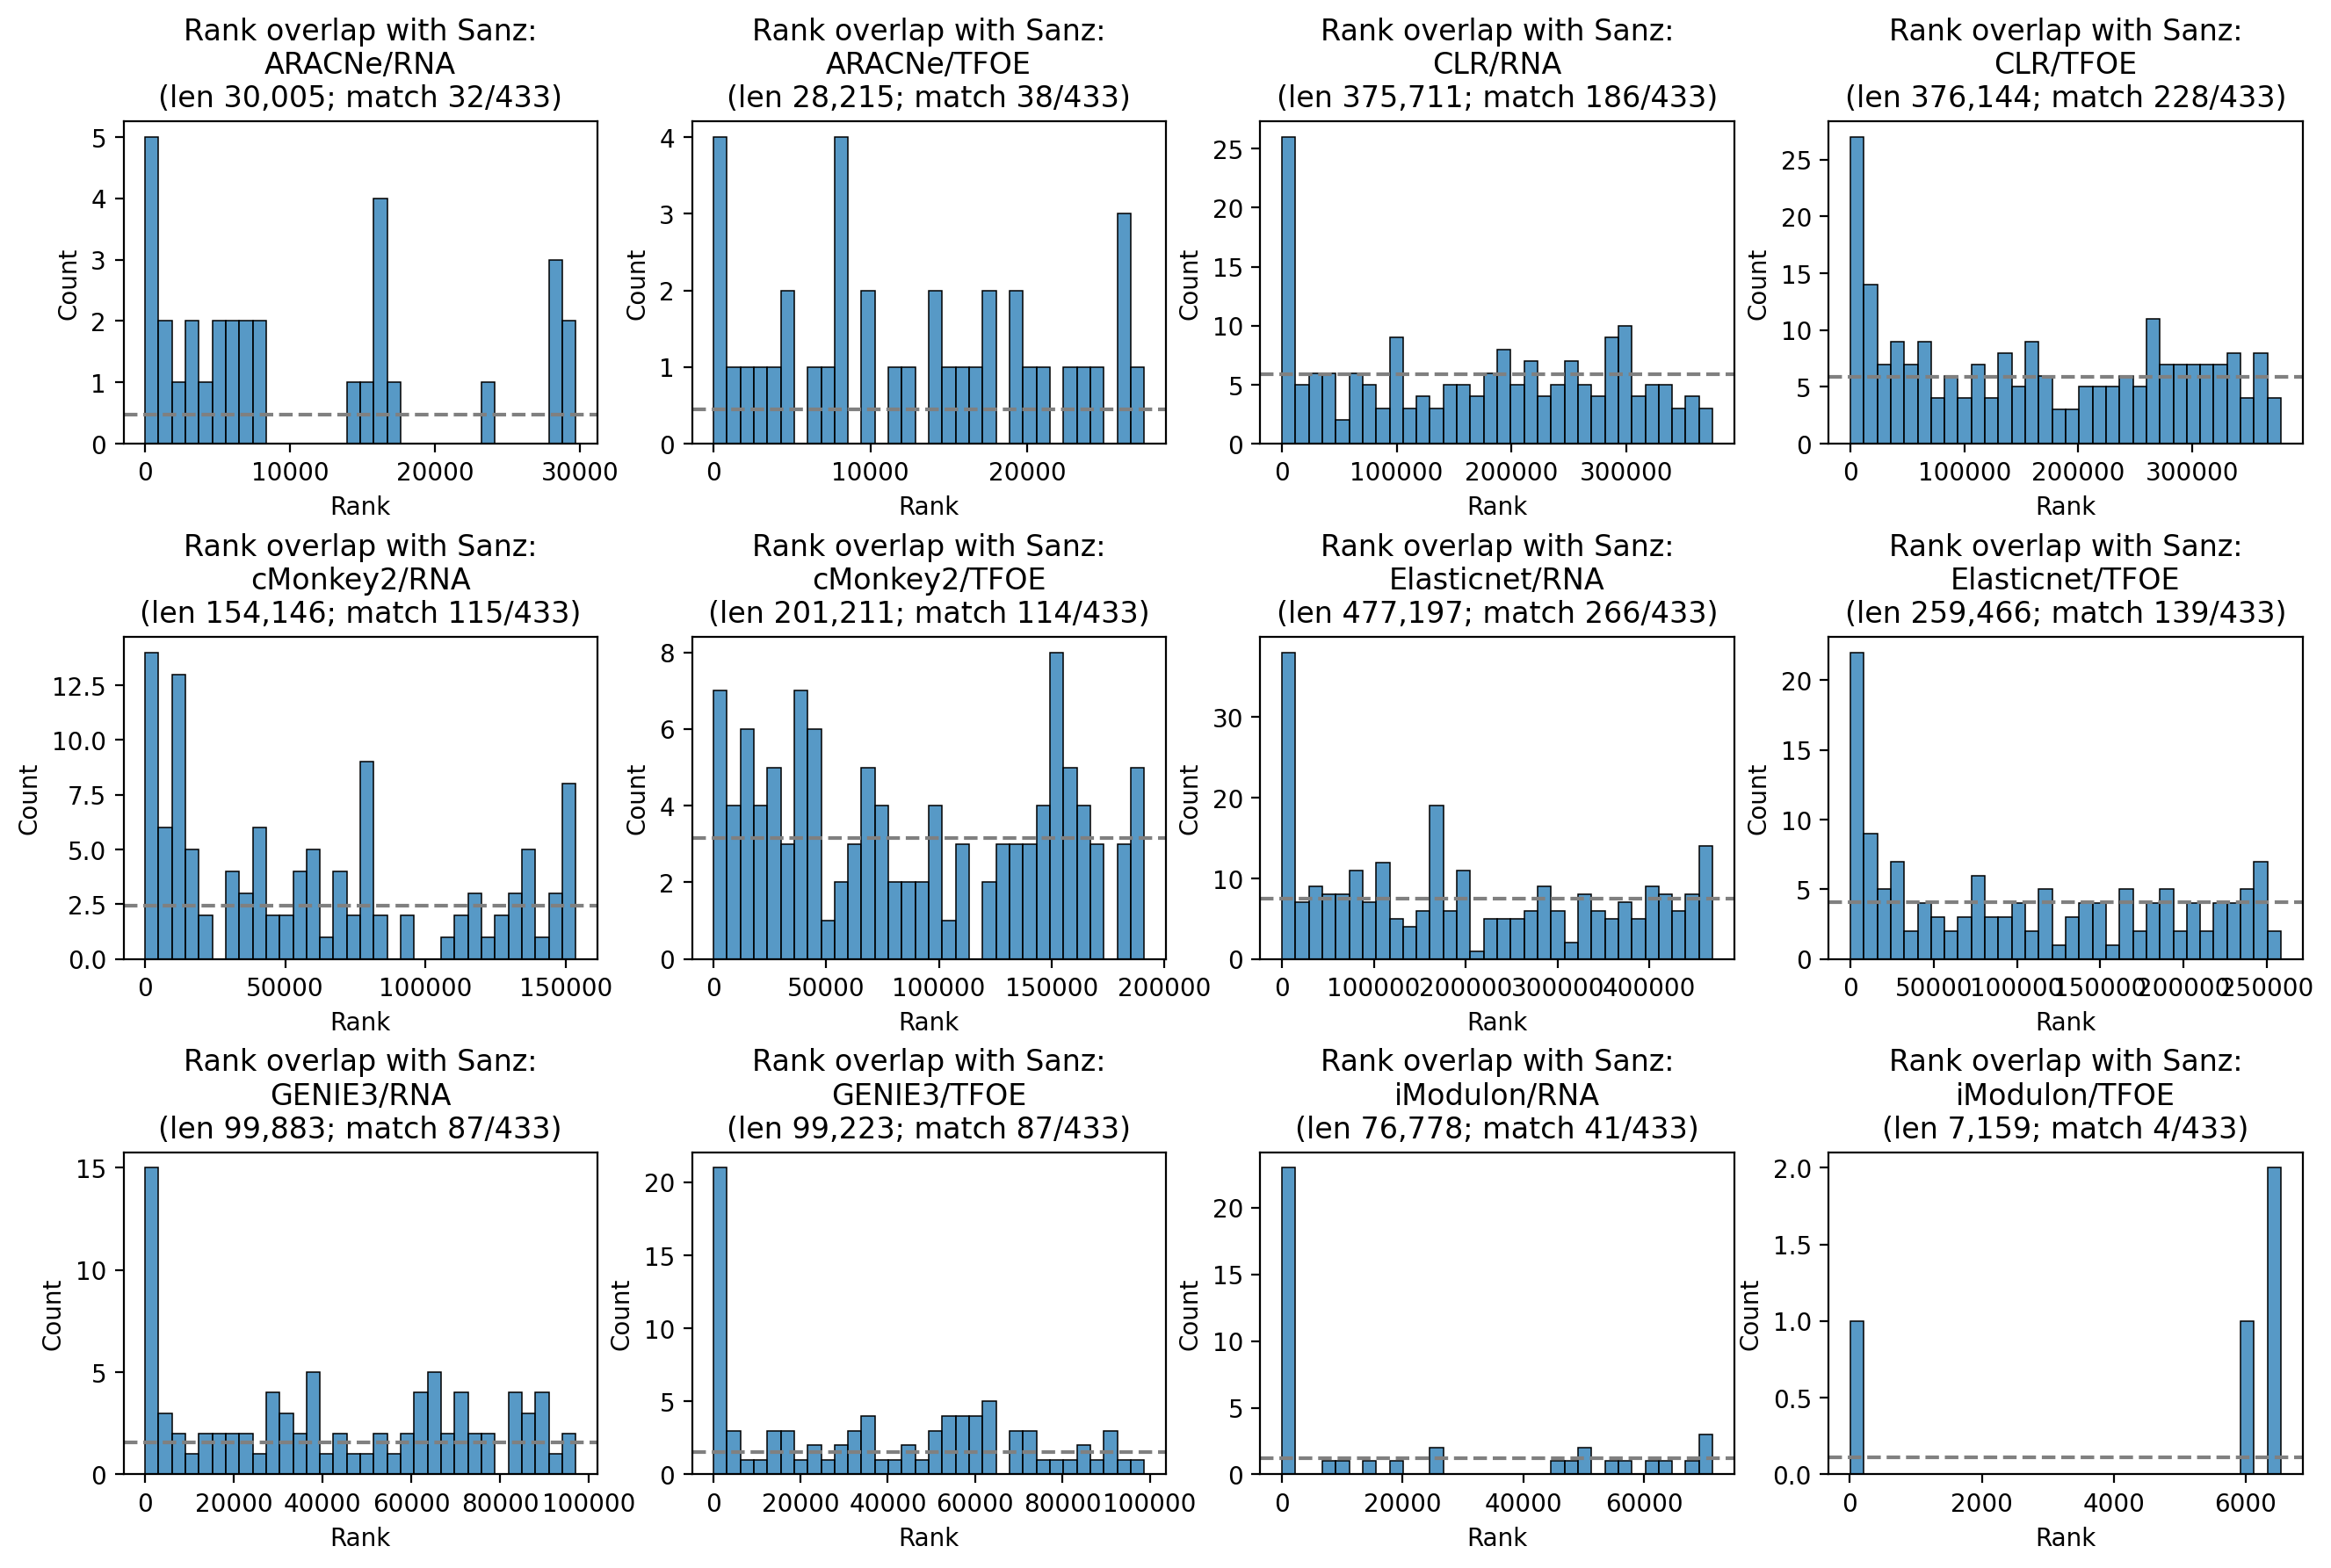

In [25]:
fig = plt.figure(figsize=(16, 10), dpi=200)
axs = fig.subplots(nrows=3, ncols=4, sharex=False, sharey=False, squeeze=True, gridspec_kw={'hspace': 0.6}).flatten()

for i in range(len(axs)):
    df_i = constituent_networks_df.at[i, 'network_df']
    df_i['Edge'] = df_i['Regulator'].str.cat(df_i['Gene'], sep='_')
    df_i2 = df_i[df_i['Edge'].isin(sanz_solid_df['Edge'])]

    bin_count = 32
    bin_size = len(df_i) / bin_count
    noise_per_bin = len(sanz_solid_df) * bin_size / len(regulatory_space)
    
    ax = sns.histplot(df_i2['Rank'], bins=bin_count, ax=axs[i])
    ax.axhline(noise_per_bin, color='grey', linestyle='--')
    ax.set_title((
        f"Rank overlap with Sanz:\n"
        f"{constituent_networks_df.at[i, 'Method']}/{constituent_networks_df.at[i, 'Dataset']}\n"
        f"(len {len(df_i):,}; match {len(df_i2)}/{len(sanz_solid_df)})"
    ))

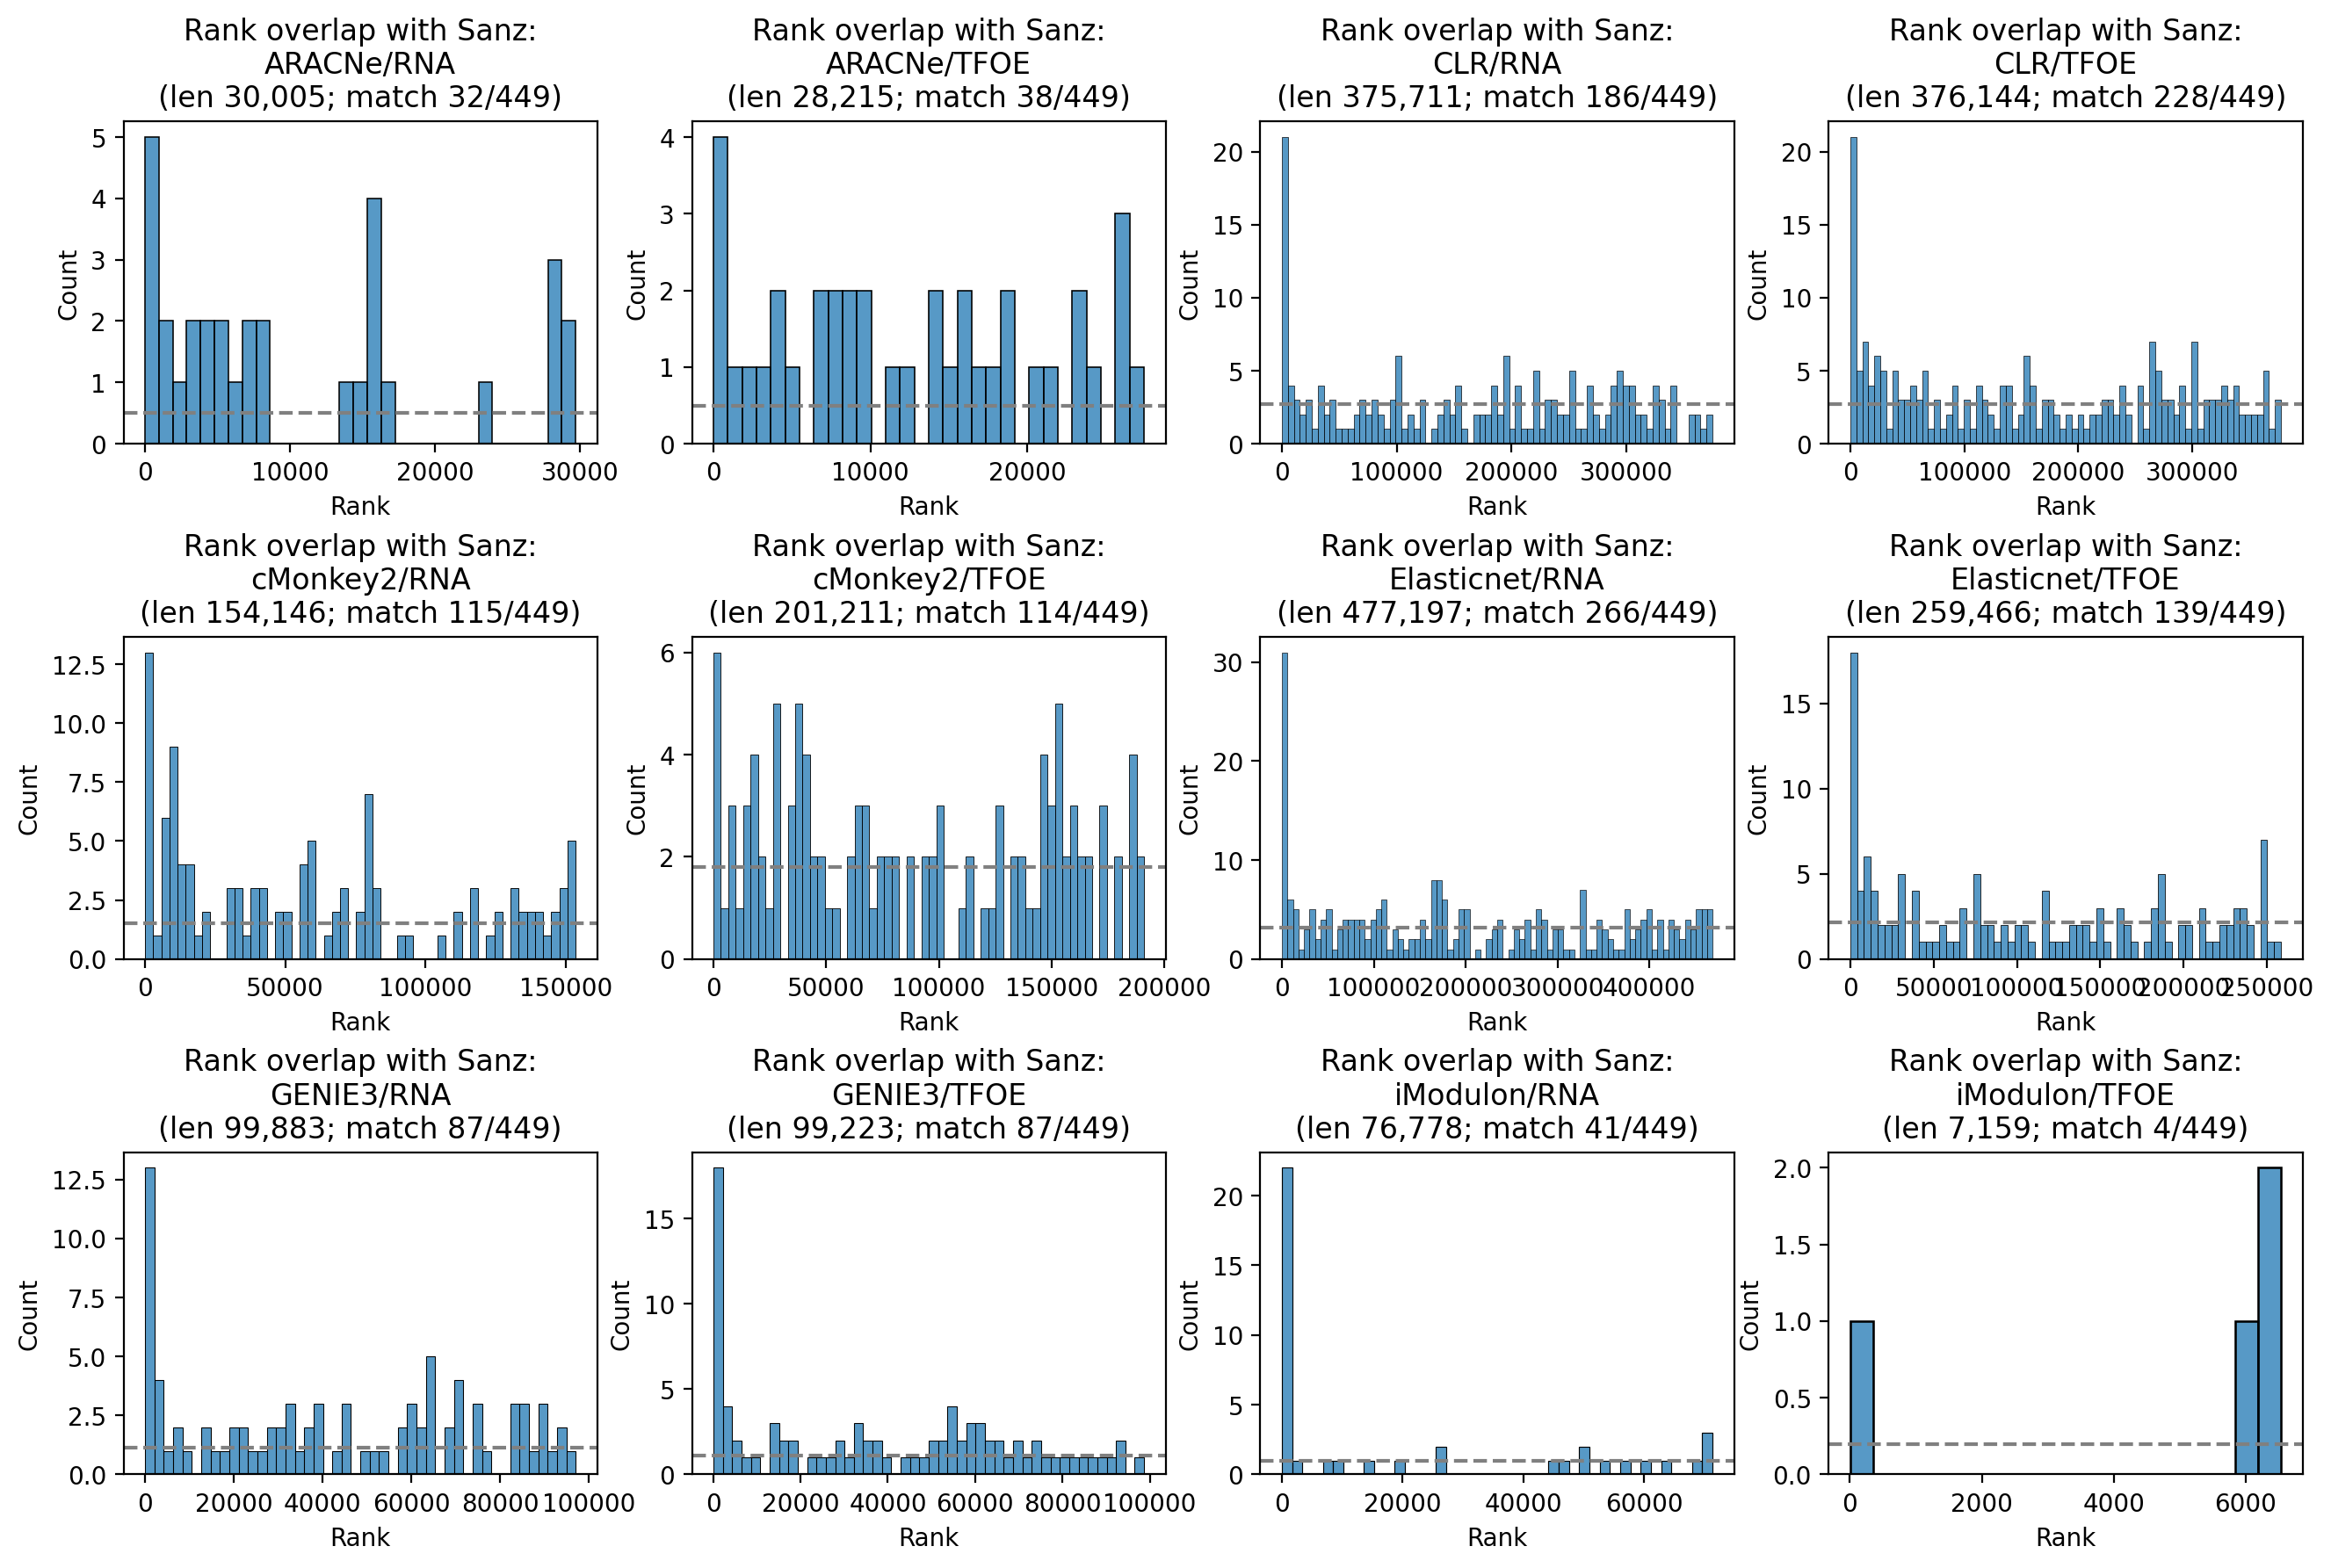

In [78]:
fig = plt.figure(figsize=(16, 10), dpi=200)
axs = fig.subplots(nrows=3, ncols=4, sharex=False, sharey=False, squeeze=True, gridspec_kw={'hspace': 0.6}).flatten()

for i in range(len(axs)):
    df_i = constituent_networks_df.at[i, 'network_df']
    df_i['Edge'] = df_i['Regulator'].str.cat(df_i['Gene'], sep='_')
    df_i2 = df_i[df_i['Edge'].isin(sanz_solid_df['Edge'])]

    bin_count = int(len(df_i) ** (1/3))
    bin_size = len(df_i) / bin_count
    noise_per_bin = len(sanz_solid_df) * bin_size / len(regulatory_space)
    
    ax = sns.histplot(df_i2['Rank'], bins=bin_count, ax=axs[i])
    ax.axhline(noise_per_bin, color='grey', linestyle='--')
    ax.set_title((
        f"Rank overlap with Sanz:\n"
        f"{constituent_networks_df.at[i, 'Method']}/{constituent_networks_df.at[i, 'Dataset']}\n"
        f"(len {len(df_i):,}; match {len(df_i2)}/{len(sanz_solid_df)})"
    ))

Some thoughts:
- It seems that these constituent networks are enriched for Sanz edges at the very beginning, followed by low-level matching throughout.
- I think this suggests that what we're seeing is a union of two distributions:
    1. A uniform distribution of false matches between the network and Sanz across the entire network. This is the only distribution we would get if the network consisted only of randomly-selected edges, and can be thought of as background noise.
    2. A smaller distribution of true matches at the top, where the network consists mainly of real inferred edges, many of which match with the high-confidence set of edges in Sanz. Since we expect these high-confidence edges to be among the most obvious relationships present in the supplied transcription data (the fact that they have been discovered suggests this), we would expect a "real network" based on these data to show many of these edges quickly and then rapidly decline -- perhaps a Poisson distribution with a small lambda value.
- The dashed lines represent the expected background noise level described in (1) above.
- This reminds me of the Storey-Tibshirani procedure for FDR correction.
- How do we separate the two distributions? Maybe we don't need to be rigorous about it? (Talk to Shuyi and Braden about this -- we may be able to adapt Storey-Tibshirani FDR to do this more rigorously)
- As an intuitive, non-rigorous method, we can observe where the histogram drops below the level of background noise. Where this happens, assuming the true match distribution (1) peaks before this point and (2) decreases monotonically from there, the true match distribution must not be contributing much any more, i.e., we're in the tail of that distribution. I think this gives us a lower bound on where the contribution of the true match distribution drops below the contribution of the background noise distribution.
    - Bin size: bin size will have a significant impact on where we draw the line. Larger bins allow for more smoothing of this noisy data, but give us crude discrimination -- e.g., we'll never be able to take a smaller set than the size of the first bin.
      - I think larger is better. Finer discrimination is better when we have consistent enough data to make that call with reasonable support -- if you need smoothing, then you're admitting fine discrimination is out the window.
      - Larger bin sizes (= fewer bins) is also better for visualization, and it would be nice to be able to clearly show exactly what we've done.
      - The square root of the network size jumps out to me as a decent bin size to try, yielding x bins each representing x values.
        -  This yields bin sizes (= bin counts) ranging from 85 to 691.
        -  I think hundreds of bins is too many. Based on the numbers I've tried (20, 32, 50, 100), even 100 yields too much noise, and honestly 50 still seems maybe a little too noisy.
      -  32 yields (mostly) decently smoothed histograms, and is a nice round number (I'm a fan of powers of two). Maybe we just go with that.
      -  Cube root of network size fits the desired range better... and does scale some with the size of the network which is nice.
      -  Compare the results of 32 vs cube root -- how do they look by eye?
        -  32 looks like it does a pretty good job on most networks. I think it's too lenient on the cMonkey2/TFOE network, which looks like mostly garbage to me. We could just exclude that network entirely...
        -  Cube root looks maybe stricter across the board... Gets less from cMonkey2/TFOE, which is nice, but I think it's unfairly strict with cMonkey2/RNA -- looks like there's still signal there that we're excluding.
        -  32 doesn't look great on the aggregated RNAseq network... but the cube root of 41k is 34! So cube root won't do any better. 4th root?
        -  Nah 4th root doesn't look like it really helps. Maybe we just stick to 32 for simplicity.

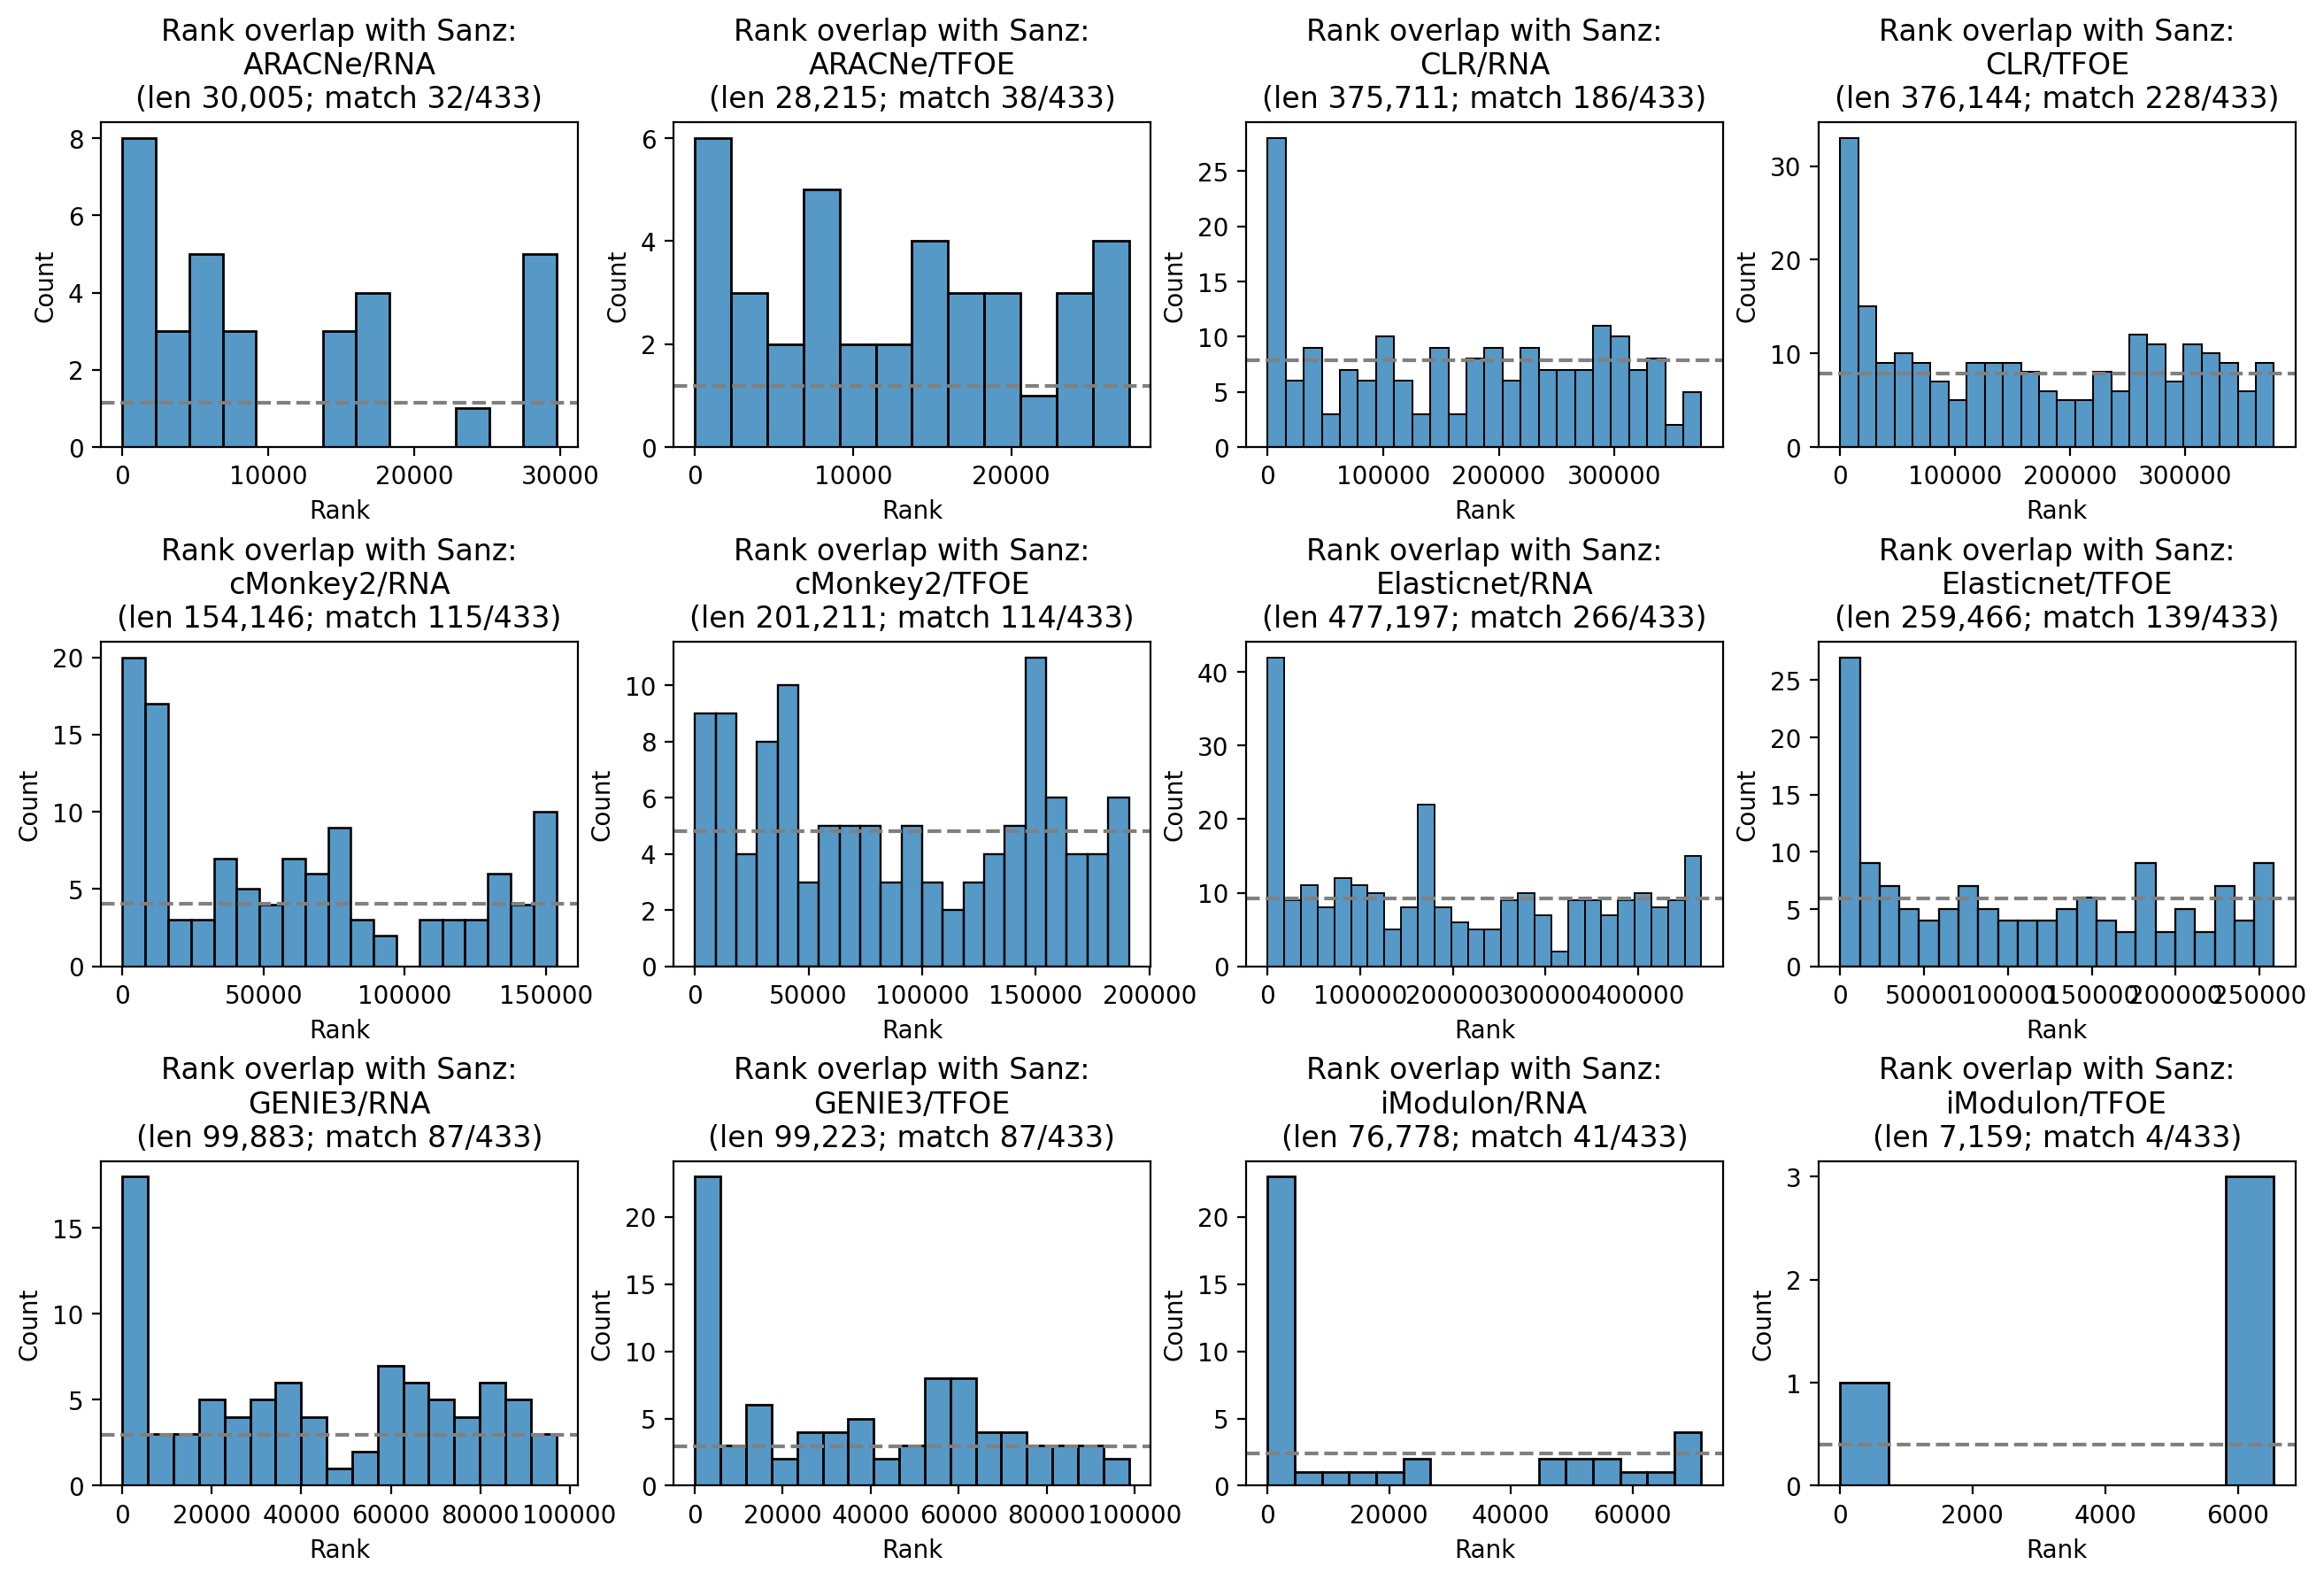

In [226]:
fig = plt.figure(figsize=(16, 10), dpi=200)
axs = fig.subplots(nrows=3, ncols=4, sharex=False, sharey=False, squeeze=True, gridspec_kw={'hspace': 0.6}).flatten()

for i in range(len(axs)):
    df_i = constituent_networks_df.at[i, 'network_df']
    df_i['Edge'] = df_i['Regulator'].str.cat(df_i['Gene'], sep='_')
    df_i2 = df_i[df_i['Edge'].isin(sanz_solid_df['Edge'])]

    bin_count = int(len(df_i) ** 0.25)
    bin_size = len(df_i) / bin_count
    noise_per_bin = len(sanz_solid_df) * bin_size / len(regulatory_space)
    
    ax = sns.histplot(df_i2['Rank'], bins=bin_count, ax=axs[i])
    ax.axhline(noise_per_bin, color='grey', linestyle='--')
    ax.set_title((
        f"Rank overlap with Sanz:\n"
        f"{constituent_networks_df.at[i, 'Method']}/{constituent_networks_df.at[i, 'Dataset']}\n"
        f"(len {len(df_i):,}; match {len(df_i2)}/{len(sanz_solid_df)})"
    ))

### Try truncating with distribution-style cutoff

In [26]:
def distribution_cutoff(network_df, true_edges, bin_count=32, hist_col='Rank', space_size=len(regulatory_space)):
    hist_values, bin_edges = np.histogram(network_df.loc[network_df['Edge'].isin(true_edges), hist_col], bins=bin_count)
    
    bin_size = len(network_df) // bin_count
    noise_per_bin = len(true_edges) * bin_size / space_size

    for i, hist_value in enumerate(hist_values):
        if hist_value < noise_per_bin:
            return int(bin_edges[i]) # bin_edges[i] is the left bound of hist_value[i]'s bin, the first bin to exclude
    else:                            # thus this is an exclusive right bound for our truncated network, though pretending this is precise is silly
        return len(network_df) # if we never drop below noise level the whole network is enriched \o/

In [27]:
print('===== Truncation with bin size of 32 =====')

for idx, row in constituent_networks_df.iterrows():
    cutoff = distribution_cutoff(row['network_df'], sanz_solid_df['Edge'])
    print(f"{row['Method']:>10s}/{row['Dataset']:4s}: old_length={len(row['network_df']): 8,d} new_length={cutoff: 7,d}")

===== Truncation with bin size of 32 =====
    ARACNe/RNA : old_length=  30,005 new_length=  8,360
    ARACNe/TFOE: old_length=  28,215 new_length=  5,151
       CLR/RNA : old_length= 375,711 new_length= 11,724
       CLR/TFOE: old_length= 376,144 new_length= 70,824
  cMonkey2/RNA : old_length= 154,146 new_length= 19,203
  cMonkey2/TFOE: old_length= 201,211 new_length= 29,868
Elasticnet/RNA : old_length= 477,197 new_length= 14,650
Elasticnet/TFOE: old_length= 259,466 new_length= 32,325
    GENIE3/RNA : old_length=  99,883 new_length=  9,097
    GENIE3/TFOE: old_length=  99,223 new_length=  6,219
  iModulon/RNA : old_length=  76,778 new_length=  2,231
  iModulon/TFOE: old_length=   7,159 new_length=    210


In [28]:
constituent_networks_df['truncated_df'] = constituent_networks_df['network_df'].map(
    lambda network_df: network_df.iloc[:distribution_cutoff(network_df, sanz_solid_df['Edge']), :])

#### Aggregate without a sharing requirement

In [29]:
distenriched_rna_df = aggregate_networks.aggregate(
    constituent_networks_df.loc[constituent_networks_df['Dataset'].eq('RNA'), 'truncated_df'],
    length_cap=-1, threshold=1)
distenriched_rna_df.columns = [multi_column[0] for multi_column in distenriched_rna_df.columns] # somehow got to be multi-index; revert
distenriched_rna_df['Edge'] = distenriched_rna_df['Regulator'].str.cat(distenriched_rna_df['Gene'], sep='_')
distenriched_rna_df['Rank'] = distenriched_rna_df.index.to_series() + 1
print(distenriched_rna_df.shape)
distenriched_rna_df.head()

(41696, 5)


,Regulator,Gene,Score,Edge,Rank
0,Rv3133c,Rv3132c,59999940,Rv3133c_Rv3132c,1
1,Rv3417c,Rv0440,59999921,Rv3417c_Rv0440,2
2,Rv0678,Rv0676c,59999843,Rv0678_Rv0676c,3
3,Rv2912c,Rv2913c,59999743,Rv2912c_Rv2913c,4
4,Rv3249c,Rv3252c,59999735,Rv3249c_Rv3252c,5


In [223]:
distenriched_rna_df[['Regulator', 'Gene', 'Rank']].to_csv(
    'aggregate-mtb_candidate_v3_rnaonly.txt', sep='\t', index=False, header=False)

In [30]:
distenriched_tfoe_df = aggregate_networks.aggregate(
    constituent_networks_df.loc[constituent_networks_df['Dataset'].eq('TFOE'), 'truncated_df'],
    length_cap=-1, threshold=1)
distenriched_tfoe_df.columns = [multi_column[0] for multi_column in distenriched_tfoe_df.columns] # somehow got to be multi-index; revert
distenriched_tfoe_df['Edge'] = distenriched_tfoe_df['Regulator'].str.cat(distenriched_tfoe_df['Gene'], sep='_')
distenriched_tfoe_df['Rank'] = distenriched_tfoe_df.index.to_series() + 1
print(distenriched_tfoe_df.shape)
distenriched_tfoe_df.head()

(105551, 5)


,Regulator,Gene,Score,Edge,Rank
0,Rv2160A,Rv2160c,59999906,Rv2160A_Rv2160c,1
1,Rv2160c,Rv2160A,59999903,Rv2160c_Rv2160A,2
2,Rv1657,Rv1658,59999699,Rv1657_Rv1658,3
3,Rv0823c,Rv1178,59999672,Rv0823c_Rv1178,4
4,Rv0081,Rv0085,59999577,Rv0081_Rv0085,5


Ok... now I have an aggregate RNASeq network and an aggregate TFOE network. We want to compare them against each other... MCC? Try it.

In [31]:
mccs_rna_on_tfoe = calc_mccs(distenriched_rna_df, distenriched_tfoe_df['Edge'])
mccs_tfoe_on_rna = calc_mccs(distenriched_tfoe_df, distenriched_rna_df['Edge'])

distenriched_rna_df.loc[len(regulators_df):, 'MCC_on_TFOE'] = mccs_rna_on_tfoe
distenriched_tfoe_df.loc[len(regulators_df):, 'MCC_on_RNA'] = mccs_tfoe_on_rna

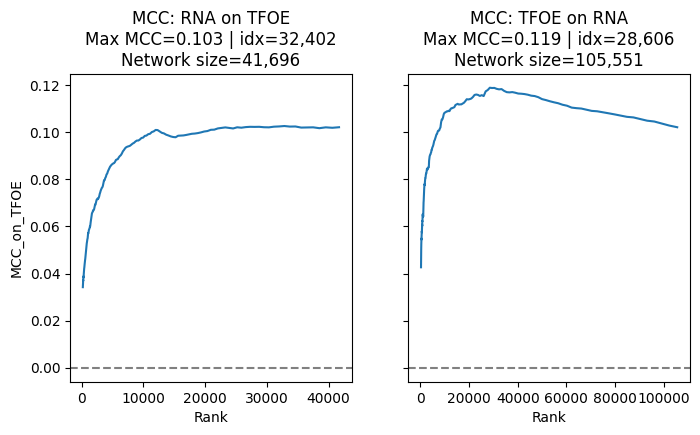

In [32]:
fig = plt.figure(figsize=(8, 4), dpi=100)
axs = fig.subplots(nrows=1, ncols=2, sharex=False, sharey=True, squeeze=True).flatten()

max_mcc1 = distenriched_rna_df['MCC_on_TFOE'].max()
ax = sns.lineplot(
    # data=df_i.iloc[list(range(len(regulators_df), len(df_i), len(df_i)//1000)), :],
    data=distenriched_rna_df.iloc[[int(n) for n in np.geomspace(len(regulators_df), len(distenriched_rna_df)-1, 200)], :],
    x='Rank', y='MCC_on_TFOE', ax=axs[0])
# ax.set_xscale('log', base=10)
ax.axhline(y=0, color='grey', linestyle='--')
ax.set_title((
    'MCC: RNA on TFOE\n'
    f"Max MCC={max_mcc1:.3f} | "
    f"idx={distenriched_rna_df.loc[distenriched_rna_df['MCC_on_TFOE'].eq(max_mcc1), 'Rank'].iloc[0]:,}\n"
    f"Network size={len(distenriched_rna_df):,}"))

max_mcc2 = distenriched_tfoe_df['MCC_on_RNA'].max()
ax = sns.lineplot(
    # data=df_i.iloc[list(range(len(regulators_df), len(df_i), len(df_i)//1000)), :],
    data=distenriched_tfoe_df.iloc[[int(n) for n in np.geomspace(len(regulators_df), len(distenriched_tfoe_df)-1, 200)], :],
    x='Rank', y='MCC_on_RNA', ax=axs[1])
# ax.set_xscale('log', base=10)
ax.axhline(y=0, color='grey', linestyle='--')
ax.set_title((
    'MCC: TFOE on RNA\n'
    f"Max MCC={max_mcc2:.3f} | "
    f"idx={distenriched_tfoe_df.loc[distenriched_tfoe_df['MCC_on_RNA'].eq(max_mcc2), 'Rank'].iloc[0]:,}\n"
    f"Network size={len(distenriched_tfoe_df):,}"));

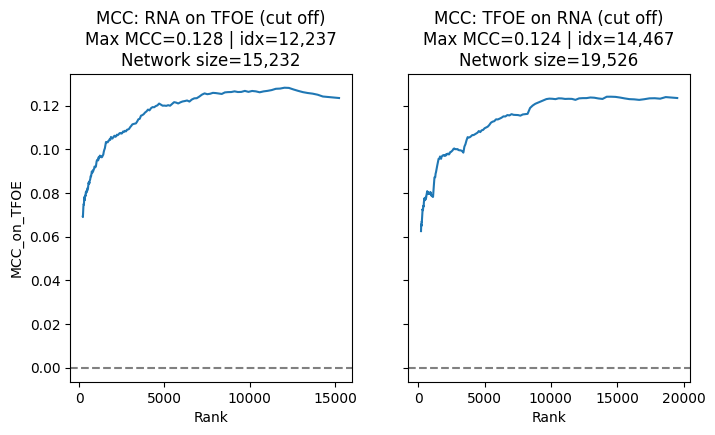

In [33]:
fig = plt.figure(figsize=(8, 4), dpi=100)
axs = fig.subplots(nrows=1, ncols=2, sharex=False, sharey=True, squeeze=True).flatten()

distenriched_rna_df_tr = distenriched_rna_df.iloc[:distribution_cutoff(distenriched_rna_df, sanz_solid_df['Edge'], bin_count=16), :]
distenriched_tfoe_df_tr = distenriched_tfoe_df.iloc[:distribution_cutoff(distenriched_tfoe_df, sanz_solid_df['Edge'], bin_count=16), :]

distenriched_rna_df_tr.loc[len(regulators_df):, 'MCC_on_TFOE'] = calc_mccs(distenriched_rna_df_tr, distenriched_tfoe_df_tr['Edge'])
distenriched_tfoe_df_tr.loc[len(regulators_df):, 'MCC_on_RNA'] = calc_mccs(distenriched_tfoe_df_tr, distenriched_rna_df_tr['Edge'])

max_mcc1_tr = distenriched_rna_df_tr['MCC_on_TFOE'].max()
ax = sns.lineplot(
    data=distenriched_rna_df_tr.iloc[[int(n) for n in np.geomspace(len(regulators_df), len(distenriched_rna_df_tr)-1, 200)], :],
    x='Rank', y='MCC_on_TFOE', ax=axs[0])
ax.axhline(y=0, color='grey', linestyle='--')
ax.set_title((
    'MCC: RNA on TFOE (cut off)\n'
    f"Max MCC={max_mcc1_tr:.3f} | "
    f"idx={distenriched_rna_df_tr.loc[distenriched_rna_df_tr['MCC_on_TFOE'].eq(max_mcc1_tr), 'Rank'].iloc[0]:,}\n"
    f"Network size={len(distenriched_rna_df_tr):,}"))

max_mcc2_tr = distenriched_tfoe_df_tr['MCC_on_RNA'].max()
ax = sns.lineplot(
    data=distenriched_tfoe_df_tr.iloc[[int(n) for n in np.geomspace(len(regulators_df), len(distenriched_tfoe_df_tr)-1, 200)], :],
    x='Rank', y='MCC_on_RNA', ax=axs[1])
# ax.set_xscale('log', base=10)
ax.axhline(y=0, color='grey', linestyle='--')
ax.set_title((
    'MCC: TFOE on RNA (cut off)\n'
    f"Max MCC={max_mcc2_tr:.3f} | "
    f"idx={distenriched_tfoe_df_tr.loc[distenriched_tfoe_df_tr['MCC_on_RNA'].eq(max_mcc2_tr), 'Rank'].iloc[0]:,}\n"
    f"Network size={len(distenriched_tfoe_df_tr):,}"));

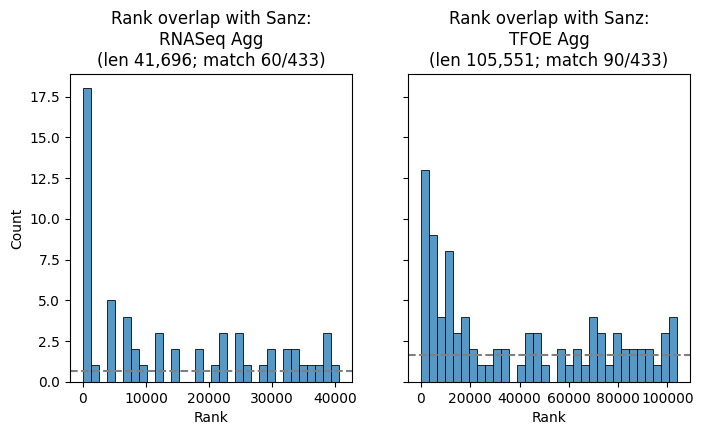

In [34]:
fig = plt.figure(figsize=(8, 4), dpi=100)
axs = fig.subplots(nrows=1, ncols=2, sharex=False, sharey=True, squeeze=True).flatten()
networks = (distenriched_rna_df, distenriched_tfoe_df)
labels = ('RNASeq Agg', 'TFOE Agg')

for i in range(len(axs)):
    df_i = networks[i]
    df_i2 = df_i[df_i['Edge'].isin(sanz_solid_df['Edge'])]

    bin_count = 32
    bin_size = len(df_i) // bin_count
    noise_per_bin = len(sanz_solid_df) * bin_size / len(regulatory_space)
    
    ax = sns.histplot(df_i2['Rank'], bins=bin_count, ax=axs[i])
    ax.axhline(noise_per_bin, color='grey', linestyle='--')
    ax.set_title((
        f"Rank overlap with Sanz:\n{labels[i]}\n"
        f"(len {len(df_i):,}; match {len(df_i2)}/{len(sanz_solid_df)})"
    ))

I think we need more smoothing on RNAseq -- it looks to me like there's still a trend there, like we're leaving some good stuff behind. How does 16 look on this dataset?

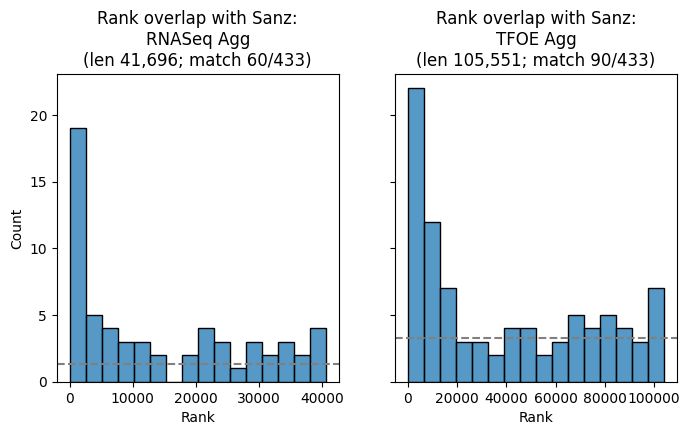

In [35]:
fig = plt.figure(figsize=(8, 4), dpi=100)
axs = fig.subplots(nrows=1, ncols=2, sharex=False, sharey=True, squeeze=True).flatten()
networks = (distenriched_rna_df, distenriched_tfoe_df)
labels = ('RNASeq Agg', 'TFOE Agg')

for i in range(len(axs)):
    df_i = networks[i]
    df_i2 = df_i[df_i['Edge'].isin(sanz_solid_df['Edge'])]

    bin_count = 16
    bin_size = len(df_i) // bin_count
    noise_per_bin = len(sanz_solid_df) * bin_size / len(regulatory_space)
    
    ax = sns.histplot(df_i2['Rank'], bins=bin_count, ax=axs[i])
    ax.axhline(noise_per_bin, color='grey', linestyle='--')
    ax.set_title((
        f"Rank overlap with Sanz:\n{labels[i]}\n"
        f"(len {len(df_i):,}; match {len(df_i2)}/{len(sanz_solid_df)})"
    ))

Not bad.... the result is similar for TFOE, but I think better representative of the pattern I think I see in RNAseq.

In [36]:
distenriched1_df = aggregate_networks.aggregate(
    (
        distenriched_rna_df.iloc[:distribution_cutoff(distenriched_rna_df, sanz_solid_df['Edge'], bin_count=16), :],
        distenriched_tfoe_df.iloc[:distribution_cutoff(distenriched_tfoe_df, sanz_solid_df['Edge'], bin_count=16), :],
    ),
    length_cap=-1, threshold=1)
# distenriched_rna_df.columns = [multi_column[0] for multi_column in distenriched_rna_df.columns] # somehow got to be multi-index; revert
distenriched1_df['Edge'] = distenriched1_df['Regulator'].str.cat(distenriched1_df['Gene'], sep='_')
distenriched1_df['Rank'] = distenriched1_df.index.to_series() + 1
print(distenriched1_df.shape)
distenriched1_df.head()

(32326, 5)


,Regulator,Gene,Score,Edge,Rank
,,,,,
0,Rv1657,Rv1659,19999984,Rv1657_Rv1659,1
1,Rv1657,Rv1658,19999984,Rv1657_Rv1658,2
2,Rv3249c,Rv3250c,19999978,Rv3249c_Rv3250c,3
3,Rv0081,Rv0085,19999974,Rv0081_Rv0085,4
4,Rv3417c,Rv0440,19999969,Rv3417c_Rv0440,5


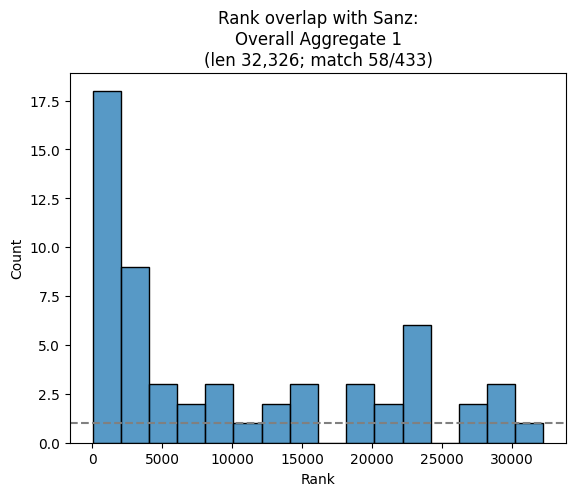

In [37]:
distenriched1_df_sanz = distenriched1_df[distenriched1_df['Edge'].isin(sanz_solid_df['Edge'])]

bin_count = 16
bin_size = len(distenriched1_df) // bin_count
noise_per_bin = len(sanz_solid_df) * bin_size / len(regulatory_space)

ax = sns.histplot(distenriched1_df_sanz['Rank'], bins=bin_count)
ax.axhline(noise_per_bin, color='grey', linestyle='--')
ax.set_title((
    f"Rank overlap with Sanz:\nOverall Aggregate 1\n"
    f"(len {len(distenriched1_df):,}; match {len(distenriched1_df_sanz)}/{len(sanz_solid_df)})"
));

In [38]:
distenriched1_2_df = aggregate_networks.aggregate(
    (
        distenriched_rna_df,
        distenriched_tfoe_df.iloc[:distribution_cutoff(distenriched_tfoe_df, sanz_solid_df['Edge'], bin_count=16), :],
    ),
    length_cap=-1, threshold=1)
distenriched1_2_df['Edge'] = distenriched1_2_df['Regulator'].str.cat(distenriched1_2_df['Gene'], sep='_')
distenriched1_2_df['Rank'] = distenriched1_2_df.index.to_series() + 1
print(distenriched1_2_df.shape)
distenriched1_2_df.head()

(57141, 5)


,Regulator,Gene,Score,Edge,Rank
,,,,,
0,Rv1657,Rv1659,19999984,Rv1657_Rv1659,1
1,Rv1657,Rv1658,19999984,Rv1657_Rv1658,2
2,Rv3249c,Rv3250c,19999978,Rv3249c_Rv3250c,3
3,Rv0081,Rv0085,19999974,Rv0081_Rv0085,4
4,Rv3417c,Rv0440,19999969,Rv3417c_Rv0440,5


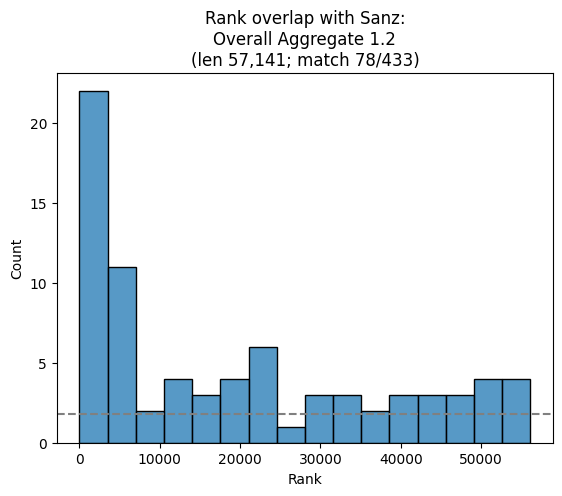

In [39]:
distenriched1_2_df_sanz = distenriched1_2_df[distenriched1_2_df['Edge'].isin(sanz_solid_df['Edge'])]

bin_count = 16
bin_size = len(distenriched1_2_df) // bin_count
noise_per_bin = len(sanz_solid_df) * bin_size / len(regulatory_space)

ax = sns.histplot(distenriched1_2_df_sanz['Rank'], bins=bin_count)
ax.axhline(noise_per_bin, color='grey', linestyle='--')
ax.set_title((
    f"Rank overlap with Sanz:\nOverall Aggregate 1.2\n"
    f"(len {len(distenriched1_2_df):,}; match {len(distenriched1_2_df_sanz)}/{len(sanz_solid_df)})"
));

#### Now try aggregating with a sharing requirement

In [40]:
distenriched_rna_df2 = aggregate_networks.aggregate(
    constituent_networks_df.loc[constituent_networks_df['Dataset'].eq('RNA'), 'truncated_df'],
    length_cap=-1, threshold=2)
distenriched_rna_df2.columns = [multi_column[0] for multi_column in distenriched_rna_df2.columns] # somehow got to be multi-index; revert
distenriched_rna_df2['Edge'] = distenriched_rna_df2['Regulator'].str.cat(distenriched_rna_df2['Gene'], sep='_')
distenriched_rna_df2['Rank'] = distenriched_rna_df2.index.to_series() + 1
print(distenriched_rna_df2.shape)
display(distenriched_rna_df2.head())

distenriched_tfoe_df2 = aggregate_networks.aggregate(
    constituent_networks_df.loc[constituent_networks_df['Dataset'].eq('TFOE'), 'truncated_df'],
    length_cap=-1, threshold=2)
distenriched_tfoe_df2.columns = [multi_column[0] for multi_column in distenriched_tfoe_df2.columns] # somehow got to be multi-index; revert
distenriched_tfoe_df2['Edge'] = distenriched_tfoe_df2['Regulator'].str.cat(distenriched_tfoe_df2['Gene'], sep='_')
distenriched_tfoe_df2['Rank'] = distenriched_tfoe_df2.index.to_series() + 1
print(distenriched_tfoe_df2.shape)
display(distenriched_tfoe_df2.head())

(12216, 5)


,Regulator,Gene,Score,Edge,Rank
0,Rv3133c,Rv3132c,59999940,Rv3133c_Rv3132c,1
1,Rv3417c,Rv0440,59999921,Rv3417c_Rv0440,2
2,Rv0678,Rv0676c,59999843,Rv0678_Rv0676c,3
3,Rv2912c,Rv2913c,59999743,Rv2912c_Rv2913c,4
4,Rv3249c,Rv3252c,59999735,Rv3249c_Rv3252c,5


(26175, 5)


,Regulator,Gene,Score,Edge,Rank
0,Rv2160A,Rv2160c,59999906,Rv2160A_Rv2160c,1
1,Rv2160c,Rv2160A,59999903,Rv2160c_Rv2160A,2
2,Rv1657,Rv1658,59999699,Rv1657_Rv1658,3
3,Rv0823c,Rv1178,59999672,Rv0823c_Rv1178,4
4,Rv0081,Rv0085,59999577,Rv0081_Rv0085,5


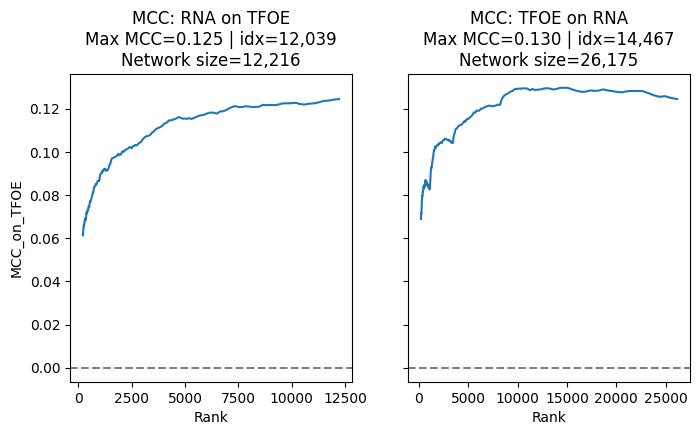

In [41]:
distenriched_rna_df2.loc[len(regulators_df):, 'MCC_on_TFOE'] = calc_mccs(distenriched_rna_df2, distenriched_tfoe_df2['Edge'])
distenriched_tfoe_df2.loc[len(regulators_df):, 'MCC_on_RNA'] = calc_mccs(distenriched_tfoe_df2, distenriched_rna_df2['Edge'])

fig = plt.figure(figsize=(8, 4), dpi=100)
axs = fig.subplots(nrows=1, ncols=2, sharex=False, sharey=True, squeeze=True).flatten()

max_mcc2_1 = distenriched_rna_df2['MCC_on_TFOE'].max()
ax = sns.lineplot(
    data=distenriched_rna_df2.iloc[[int(n) for n in np.geomspace(len(regulators_df), len(distenriched_rna_df2)-1, 200)], :],
    x='Rank', y='MCC_on_TFOE', ax=axs[0])
ax.axhline(y=0, color='grey', linestyle='--')
ax.set_title((
    'MCC: RNA on TFOE\n'
    f"Max MCC={max_mcc2_1:.3f} | "
    f"idx={distenriched_rna_df2.loc[distenriched_rna_df2['MCC_on_TFOE'].eq(max_mcc2_1), 'Rank'].iloc[0]:,}\n"
    f"Network size={len(distenriched_rna_df2):,}"))

max_mcc2_2 = distenriched_tfoe_df2['MCC_on_RNA'].max()
ax = sns.lineplot(
    data=distenriched_tfoe_df2.iloc[[int(n) for n in np.geomspace(len(regulators_df), len(distenriched_tfoe_df2)-1, 200)], :],
    x='Rank', y='MCC_on_RNA', ax=axs[1])
ax.axhline(y=0, color='grey', linestyle='--')
ax.set_title((
    'MCC: TFOE on RNA\n'
    f"Max MCC={max_mcc2_2:.3f} | "
    f"idx={distenriched_tfoe_df2.loc[distenriched_tfoe_df2['MCC_on_RNA'].eq(max_mcc2_2), 'Rank'].iloc[0]:,}\n"
    f"Network size={len(distenriched_tfoe_df2):,}"));

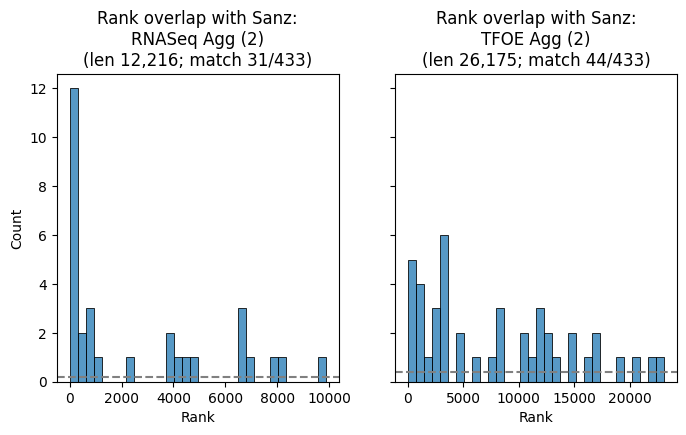

In [42]:
fig = plt.figure(figsize=(8, 4), dpi=100)
axs = fig.subplots(nrows=1, ncols=2, sharex=False, sharey=True, squeeze=True).flatten()
networks = (distenriched_rna_df2, distenriched_tfoe_df2)
labels = ('RNASeq Agg (2)', 'TFOE Agg (2)')

for i in range(len(axs)):
    df_i = networks[i]
    df_i2 = df_i[df_i['Edge'].isin(sanz_solid_df['Edge'])]

    bin_count = 32
    bin_size = len(df_i) // bin_count
    noise_per_bin = len(sanz_solid_df) * bin_size / len(regulatory_space)
    
    ax = sns.histplot(df_i2['Rank'], bins=bin_count, ax=axs[i])
    ax.axhline(noise_per_bin, color='grey', linestyle='--')
    ax.set_title((
        f"Rank overlap with Sanz:\n{labels[i]}\n"
        f"(len {len(df_i):,}; match {len(df_i2)}/{len(sanz_solid_df)})"
    ))

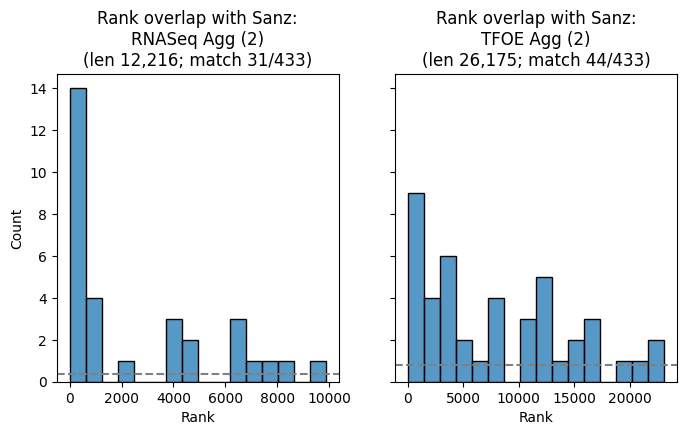

In [43]:
fig = plt.figure(figsize=(8, 4), dpi=100)
axs = fig.subplots(nrows=1, ncols=2, sharex=False, sharey=True, squeeze=True).flatten()
networks = (distenriched_rna_df2, distenriched_tfoe_df2)
labels = ('RNASeq Agg (2)', 'TFOE Agg (2)')

for i in range(len(axs)):
    df_i = networks[i]
    df_i2 = df_i[df_i['Edge'].isin(sanz_solid_df['Edge'])]

    bin_count = 16
    bin_size = len(df_i) // bin_count
    noise_per_bin = len(sanz_solid_df) * bin_size / len(regulatory_space)
    
    ax = sns.histplot(df_i2['Rank'], bins=bin_count, ax=axs[i])
    ax.axhline(noise_per_bin, color='grey', linestyle='--')
    ax.set_title((
        f"Rank overlap with Sanz:\n{labels[i]}\n"
        f"(len {len(df_i):,}; match {len(df_i2)}/{len(sanz_solid_df)})"
    ))

I almost feel like here... we don't need to cut off again. Like, it kinda looks like we've already rejected the whole rejection region. Maybe we can try it with and without.

In [44]:
distenriched2_df = aggregate_networks.aggregate(
    (
        distenriched_rna_df2,
        distenriched_tfoe_df2,
    ),
    length_cap=-1, threshold=1)
distenriched2_df['Edge'] = distenriched2_df['Regulator'].str.cat(distenriched2_df['Gene'], sep='_')
distenriched2_df['Rank'] = distenriched2_df.index.to_series() + 1
print(distenriched2_df.shape)
distenriched1_df.head()

(35844, 5)


,Regulator,Gene,Score,Edge,Rank
,,,,,
0,Rv1657,Rv1659,19999984,Rv1657_Rv1659,1
1,Rv1657,Rv1658,19999984,Rv1657_Rv1658,2
2,Rv3249c,Rv3250c,19999978,Rv3249c_Rv3250c,3
3,Rv0081,Rv0085,19999974,Rv0081_Rv0085,4
4,Rv3417c,Rv0440,19999969,Rv3417c_Rv0440,5


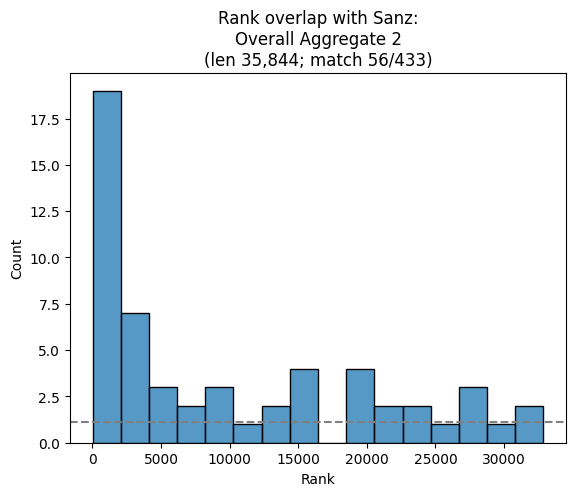

In [45]:
distenriched2_df_sanz = distenriched2_df[distenriched2_df['Edge'].isin(sanz_solid_df['Edge'])]

bin_count = 16
bin_size = len(distenriched2_df) // bin_count
noise_per_bin = len(sanz_solid_df) * bin_size / len(regulatory_space)

ax = sns.histplot(distenriched2_df_sanz['Rank'], bins=bin_count)
ax.axhline(noise_per_bin, color='grey', linestyle='--')
ax.set_title((
    f"Rank overlap with Sanz:\nOverall Aggregate 2\n"
    f"(len {len(distenriched2_df):,}; match {len(distenriched2_df_sanz)}/{len(sanz_solid_df)})"
));

In [46]:
distenriched2_2_df = aggregate_networks.aggregate(
    (
        distenriched_rna_df2.iloc[:distribution_cutoff(distenriched_rna_df2, sanz_solid_df['Edge'], bin_count=16), :],
        distenriched_tfoe_df2.iloc[:distribution_cutoff(distenriched_tfoe_df2, sanz_solid_df['Edge'], bin_count=16), :],
    ),
    length_cap=-1, threshold=1)
distenriched2_2_df['Edge'] = distenriched2_2_df['Regulator'].str.cat(distenriched2_2_df['Gene'], sep='_')
distenriched2_2_df['Rank'] = distenriched2_2_df.index.to_series() + 1
print(distenriched2_2_df.shape)
distenriched2_2_df.head()

(9537, 5)


,Regulator,Gene,Score,Edge,Rank
,,,,,
0,Rv1657,Rv1659,19999984,Rv1657_Rv1659,1
1,Rv1657,Rv1658,19999984,Rv1657_Rv1658,2
2,Rv3249c,Rv3250c,19999978,Rv3249c_Rv3250c,3
3,Rv0081,Rv0085,19999974,Rv0081_Rv0085,4
4,Rv3417c,Rv0440,19999969,Rv3417c_Rv0440,5


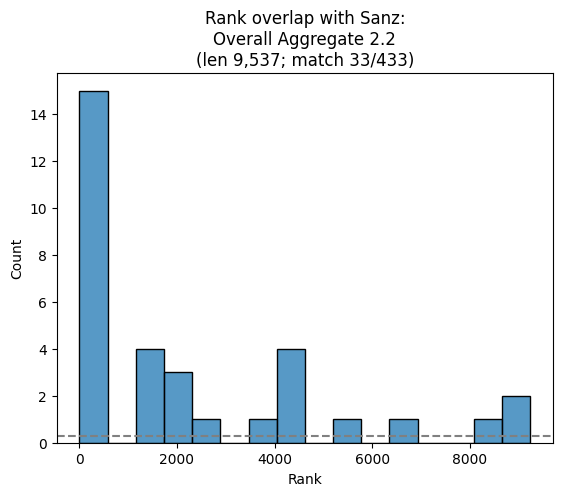

In [47]:
distenriched2_2_df_sanz = distenriched2_2_df[distenriched2_2_df['Edge'].isin(sanz_solid_df['Edge'])]

bin_count = 16
bin_size = len(distenriched2_2_df) // bin_count
noise_per_bin = len(sanz_solid_df) * bin_size / len(regulatory_space)

ax = sns.histplot(distenriched2_2_df_sanz['Rank'], bins=bin_count)
ax.axhline(noise_per_bin, color='grey', linestyle='--')
ax.set_title((
    f"Rank overlap with Sanz:\nOverall Aggregate 2.2\n"
    f"(len {len(distenriched2_2_df):,}; match {len(distenriched2_2_df_sanz)}/{len(sanz_solid_df)})"
));

### After throwing out bad networks

In [48]:
constituent_networks_df[constituent_networks_df['Dataset'].eq('TFOE')]

,Method,Dataset,File,network_df,AUPR_sanz,truncated_df
1,ARACNe,TFOE,../aracne_tfoefullpysnail-50b-pneg6_nonoperon.txt,index Regulator Gene Rank Score ...,5.99e-04,index Regulator Gene Rank Score ...
3,CLR,TFOE,../clr_tfoefullpysnail_nonoperon.txt,index Regulator Gene Rank ...,7.32e-04,index Regulator Gene Rank Score...
5,cMonkey2,TFOE,../cmonkey2_tfoe-full-pysnail_nonoperon.txt,index Regulator Gene Rank Sco...,5.58e-04,index Regulator Gene Rank Score ...
7,Elasticnet,TFOE,../elasticnet_v0.2_tfoe-full-pysnail_nonoperon...,index Regulator Gene Rank ...,6.38e-04,index Regulator Gene Rank Score ...
9,GENIE3,TFOE,../genie3_tfoe-full-pysnail_nonoperon.txt,index Regulator Gene Rank Sco...,7.17e-04,index Regulator Gene Rank Score ...
11,iModulon,TFOE,../imodulon_tfoe-full-pysnail_nonoperon_dedup.txt,index Regulator Gene Rank Score...,4.62e-04,index Regulator Gene Rank Score MC...


throw out ARACNe, cMonkey2, iModulon; so keep idxs 3, 7, 9

In [49]:
distenriched_tfoe3_df = aggregate_networks.aggregate(
    constituent_networks_df.loc[[3, 7, 9], 'truncated_df'],
    length_cap=-1, threshold=1)
distenriched_tfoe3_df.columns = [multi_column[0] for multi_column in distenriched_tfoe3_df.columns] # somehow got to be multi-index; revert
distenriched_tfoe3_df['Edge'] = distenriched_tfoe3_df['Regulator'].str.cat(distenriched_tfoe3_df['Gene'], sep='_')
distenriched_tfoe3_df['Rank'] = distenriched_tfoe3_df.index.to_series() + 1
print(distenriched_tfoe3_df.shape)
distenriched_tfoe3_df.head()

(87632, 5)


,Regulator,Gene,Score,Edge,Rank
0,Rv2989,Rv2988c,29999999,Rv2989_Rv2988c,1
1,Rv2160A,Rv2160c,29999992,Rv2160A_Rv2160c,2
2,Rv2160c,Rv2160A,29999988,Rv2160c_Rv2160A,3
3,Rv2989,Rv2987c,29999984,Rv2989_Rv2987c,4
4,Rv3583c,Rv1872c,29999965,Rv3583c_Rv1872c,5


In [222]:
distenriched_tfoe3_df[['Regulator', 'Gene', 'Rank']].to_csv(
    'aggregate-mtb_candidate_v3_tfoeonly.txt', sep='\t', index=False, header=False)

In [50]:
distenriched_rna_df.loc[len(regulators_df):, 'MCC_on_TFOE3'] = calc_mccs(distenriched_rna_df, distenriched_tfoe3_df['Edge'])
distenriched_tfoe3_df.loc[len(regulators_df):, 'MCC_on_RNA'] = calc_mccs(distenriched_tfoe3_df, distenriched_rna_df['Edge'])

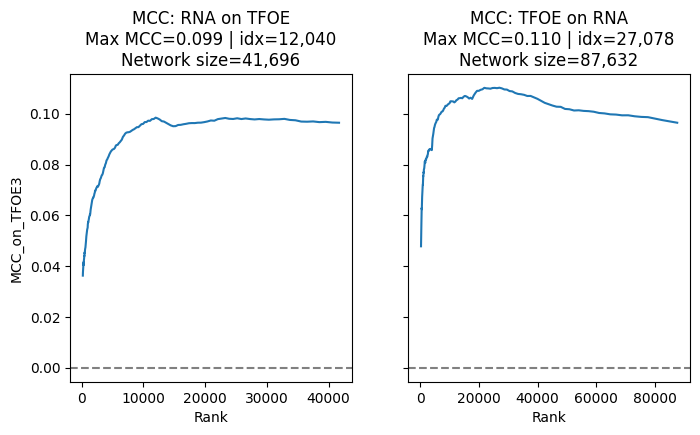

In [51]:
fig = plt.figure(figsize=(8, 4), dpi=100)
axs = fig.subplots(nrows=1, ncols=2, sharex=False, sharey=True, squeeze=True).flatten()

max_mcc1 = distenriched_rna_df['MCC_on_TFOE3'].max()
ax = sns.lineplot(
    # data=df_i.iloc[list(range(len(regulators_df), len(df_i), len(df_i)//1000)), :],
    data=distenriched_rna_df.iloc[[int(n) for n in np.geomspace(len(regulators_df), len(distenriched_rna_df)-1, 200)], :],
    x='Rank', y='MCC_on_TFOE3', ax=axs[0])
# ax.set_xscale('log', base=10)
ax.axhline(y=0, color='grey', linestyle='--')
ax.set_title((
    'MCC: RNA on TFOE\n'
    f"Max MCC={max_mcc1:.3f} | "
    f"idx={distenriched_rna_df.loc[distenriched_rna_df['MCC_on_TFOE3'].eq(max_mcc1), 'Rank'].iloc[0]:,}\n"
    f"Network size={len(distenriched_rna_df):,}"))

max_mcc2 = distenriched_tfoe3_df['MCC_on_RNA'].max()
ax = sns.lineplot(
    # data=df_i.iloc[list(range(len(regulators_df), len(df_i), len(df_i)//1000)), :],
    data=distenriched_tfoe3_df.iloc[[int(n) for n in np.geomspace(len(regulators_df), len(distenriched_tfoe3_df)-1, 200)], :],
    x='Rank', y='MCC_on_RNA', ax=axs[1])
# ax.set_xscale('log', base=10)
ax.axhline(y=0, color='grey', linestyle='--')
ax.set_title((
    'MCC: TFOE on RNA\n'
    f"Max MCC={max_mcc2:.3f} | "
    f"idx={distenriched_tfoe3_df.loc[distenriched_tfoe3_df['MCC_on_RNA'].eq(max_mcc2), 'Rank'].iloc[0]:,}\n"
    f"Network size={len(distenriched_tfoe3_df):,}"));

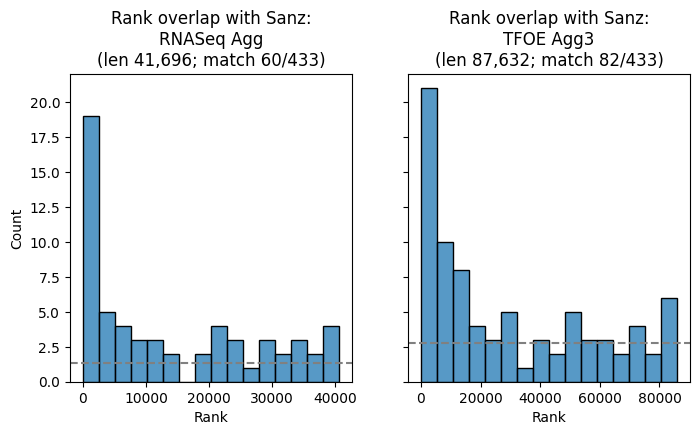

In [52]:
fig = plt.figure(figsize=(8, 4), dpi=100)
axs = fig.subplots(nrows=1, ncols=2, sharex=False, sharey=True, squeeze=True).flatten()
networks = (distenriched_rna_df, distenriched_tfoe3_df)
labels = ('RNASeq Agg', 'TFOE Agg3')

for i in range(len(axs)):
    df_i = networks[i]
    df_i2 = df_i[df_i['Edge'].isin(sanz_solid_df['Edge'])]

    bin_count = 16
    bin_size = len(df_i) // bin_count
    noise_per_bin = len(sanz_solid_df) * bin_size / len(regulatory_space)
    
    ax = sns.histplot(df_i2['Rank'], bins=bin_count, ax=axs[i])
    ax.axhline(noise_per_bin, color='grey', linestyle='--')
    ax.set_title((
        f"Rank overlap with Sanz:\n{labels[i]}\n"
        f"(len {len(df_i):,}; match {len(df_i2)}/{len(sanz_solid_df)})"
    ))

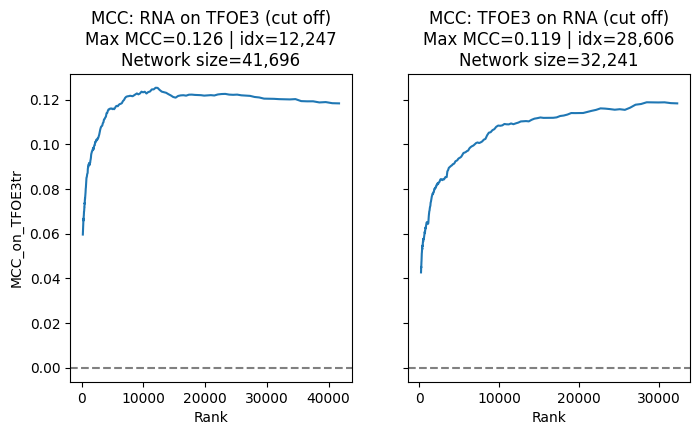

In [53]:
fig = plt.figure(figsize=(8, 4), dpi=100)
axs = fig.subplots(nrows=1, ncols=2, sharex=False, sharey=True, squeeze=True).flatten()

# distenriched_rna_df_tr = distenriched_rna_df.iloc[:distribution_cutoff(distenriched_rna_df, sanz_solid_df['Edge'], bin_count=16), :]
distenriched_tfoe3_df_tr = distenriched_tfoe_df.iloc[:distribution_cutoff(distenriched_tfoe3_df, sanz_solid_df['Edge'], bin_count=16), :]

distenriched_rna_df.loc[len(regulators_df):, 'MCC_on_TFOE3tr'] = calc_mccs(distenriched_rna_df, distenriched_tfoe3_df_tr['Edge'])
distenriched_tfoe3_df_tr.loc[len(regulators_df):, 'MCC_on_RNA'] = calc_mccs(distenriched_tfoe3_df_tr, distenriched_rna_df['Edge'])

max_mcc1_tr = distenriched_rna_df['MCC_on_TFOE3tr'].max()
ax = sns.lineplot(
    data=distenriched_rna_df.iloc[[int(n) for n in np.geomspace(len(regulators_df), len(distenriched_rna_df)-1, 200)], :],
    x='Rank', y='MCC_on_TFOE3tr', ax=axs[0])
ax.axhline(y=0, color='grey', linestyle='--')
ax.set_title((
    'MCC: RNA on TFOE3 (cut off)\n'
    f"Max MCC={max_mcc1_tr:.3f} | "
    f"idx={distenriched_rna_df_tr.loc[distenriched_rna_df['MCC_on_TFOE3tr'].eq(max_mcc1_tr), 'Rank'].iloc[0]:,}\n"
    f"Network size={len(distenriched_rna_df):,}"))

max_mcc2_tr = distenriched_tfoe3_df_tr['MCC_on_RNA'].max()
ax = sns.lineplot(
    data=distenriched_tfoe3_df_tr.iloc[[int(n) for n in np.geomspace(len(regulators_df), len(distenriched_tfoe3_df_tr)-1, 200)], :],
    x='Rank', y='MCC_on_RNA', ax=axs[1])
ax.axhline(y=0, color='grey', linestyle='--')
ax.set_title((
    'MCC: TFOE3 on RNA (cut off)\n'
    f"Max MCC={max_mcc2_tr:.3f} | "
    f"idx={distenriched_tfoe3_df_tr.loc[distenriched_tfoe3_df_tr['MCC_on_RNA'].eq(max_mcc2_tr), 'Rank'].iloc[0]:,}\n"
    f"Network size={len(distenriched_tfoe3_df_tr):,}"));

In [54]:
distenriched3_df = aggregate_networks.aggregate(
    (
        distenriched_rna_df,
        distenriched_tfoe3_df_tr,
    ),
    length_cap=-1, threshold=1)
distenriched3_df.columns = [multi_column[0] for multi_column in distenriched3_df.columns] # somehow got to be multi-index; revert
distenriched3_df['Edge'] = distenriched3_df['Regulator'].str.cat(distenriched3_df['Gene'], sep='_')
distenriched3_df['Rank'] = distenriched3_df.index.to_series() + 1
print(distenriched3_df.shape)
distenriched3_df.head()

(68226, 5)


,Regulator,Gene,Score,Edge,Rank
0,Rv1657,Rv1659,19999984,Rv1657_Rv1659,1
1,Rv1657,Rv1658,19999984,Rv1657_Rv1658,2
2,Rv3249c,Rv3250c,19999978,Rv3249c_Rv3250c,3
3,Rv0081,Rv0085,19999974,Rv0081_Rv0085,4
4,Rv3417c,Rv0440,19999969,Rv3417c_Rv0440,5


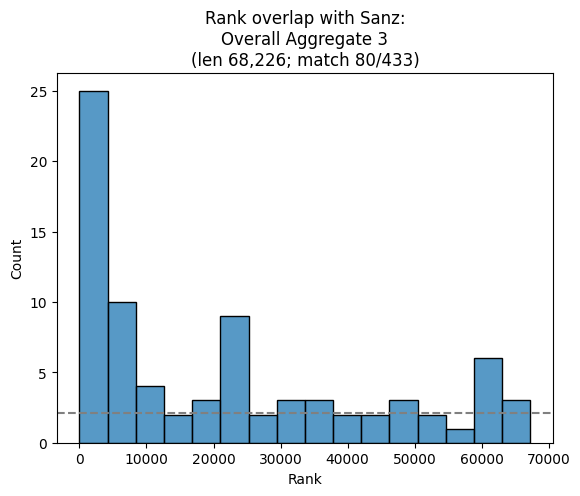

In [55]:
distenriched3_df_sanz = distenriched3_df[distenriched3_df['Edge'].isin(sanz_solid_df['Edge'])]

bin_count = 16
bin_size = len(distenriched3_df) // bin_count
noise_per_bin = len(sanz_solid_df) * bin_size / len(regulatory_space)

ax = sns.histplot(distenriched3_df_sanz['Rank'], bins=bin_count)
ax.axhline(noise_per_bin, color='grey', linestyle='--')
ax.set_title((
    f"Rank overlap with Sanz:\nOverall Aggregate 3\n"
    f"(len {len(distenriched3_df):,}; match {len(distenriched3_df_sanz)}/{len(sanz_solid_df)})"
));

In [56]:
distenriched3_df_tr = distenriched3_df.iloc[:distribution_cutoff(distenriched3_df, sanz_solid_df['Edge'], bin_count=16), :].copy()
print(distenriched3_df_tr.shape)
distenriched3_df_tr.head()

(12612, 5)


,Regulator,Gene,Score,Edge,Rank
0,Rv1657,Rv1659,19999984,Rv1657_Rv1659,1
1,Rv1657,Rv1658,19999984,Rv1657_Rv1658,2
2,Rv3249c,Rv3250c,19999978,Rv3249c_Rv3250c,3
3,Rv0081,Rv0085,19999974,Rv0081_Rv0085,4
4,Rv3417c,Rv0440,19999969,Rv3417c_Rv0440,5


`distenriched3_df` represents high confidence, large-ish network.

`distenriched3_df_tr` represents highest confidence network.

We'll send both over and see what the Yang lab is interested in.

## Test candidate aggregate networks against ChIP-Seq

In [57]:
chipseq_df = pd.read_csv('../../mount/chipseq_intersect.csv', sep='\t', header=None, names=['Regulator', 'Gene', 'p_val'])
chipseq_df['Edge'] = chipseq_df['Regulator'].str.cat(chipseq_df['Gene'], sep='_')
chipseq_df

,Regulator,Gene,p_val,Edge
0,Rv0022c,Rv0029,0.00e+00,Rv0022c_Rv0029
1,Rv1033c,Rv2132,0.00e+00,Rv1033c_Rv2132
2,Rv1033c,Rv2145c,0.00e+00,Rv1033c_Rv2145c
3,Rv1033c,Rv2147c,0.00e+00,Rv1033c_Rv2147c
4,Rv1033c,Rv2148c,0.00e+00,Rv1033c_Rv2148c
...,...,...,...,...
5173,Rv0891c,Rv3461c,9.83e-03,Rv0891c_Rv3461c
5174,Rv0891c,Rv3461c,9.83e-03,Rv0891c_Rv3461c
5175,Rv0691c,Rv0454,9.86e-03,Rv0691c_Rv0454
5176,Rv0967,Rv1405c,9.86e-03,Rv0967_Rv1405c


In [58]:
distenriched3_df.loc[len(regulators_df):, 'MCC_on_ChIP'] =  calc_mccs(distenriched3_df, chipseq_df['Edge'])
distenriched3_df_tr.loc[len(regulators_df):, 'MCC_on_ChIP'] =  calc_mccs(distenriched3_df_tr, chipseq_df['Edge'])

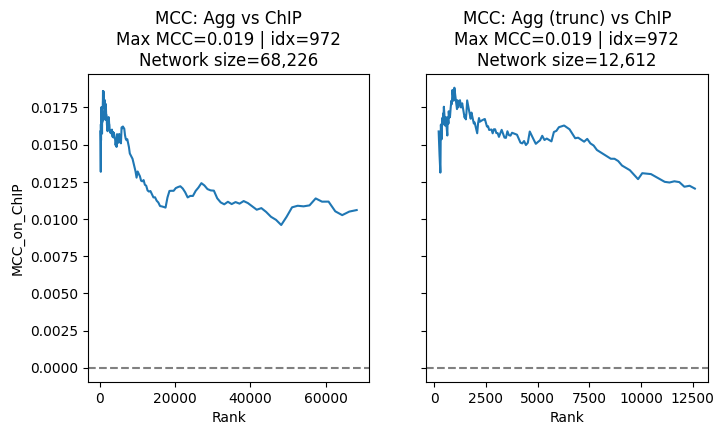

In [59]:
fig = plt.figure(figsize=(8, 4), dpi=100)
axs = fig.subplots(nrows=1, ncols=2, sharex=False, sharey=True, squeeze=True).flatten()

max_mcc3 = distenriched3_df['MCC_on_ChIP'].max()
ax = sns.lineplot(
    data=distenriched3_df.iloc[[int(n) for n in np.geomspace(len(regulators_df), len(distenriched3_df)-1, 200)], :],
    x='Rank', y='MCC_on_ChIP', ax=axs[0])
ax.axhline(y=0, color='grey', linestyle='--')
ax.set_title((
    'MCC: Agg vs ChIP\n'
    f"Max MCC={max_mcc3:.3f} | "
    f"idx={distenriched3_df.loc[distenriched3_df['MCC_on_ChIP'].eq(max_mcc3), 'Rank'].iloc[0]:,}\n"
    f"Network size={len(distenriched3_df):,}"))

max_mcc3_tr = distenriched3_df_tr['MCC_on_ChIP'].max()
ax = sns.lineplot(
    data=distenriched3_df_tr.iloc[[int(n) for n in np.geomspace(len(regulators_df), len(distenriched3_df_tr)-1, 200)], :],
    x='Rank', y='MCC_on_ChIP', ax=axs[1])
ax.axhline(y=0, color='grey', linestyle='--')
ax.set_title((
    'MCC: Agg (trunc) vs ChIP\n'
    f"Max MCC={max_mcc3_tr:.3f} | "
    f"idx={distenriched3_df_tr.loc[distenriched3_df_tr['MCC_on_ChIP'].eq(max_mcc3_tr), 'Rank'].iloc[0]:,}\n"
    f"Network size={len(distenriched3_df_tr):,}"));

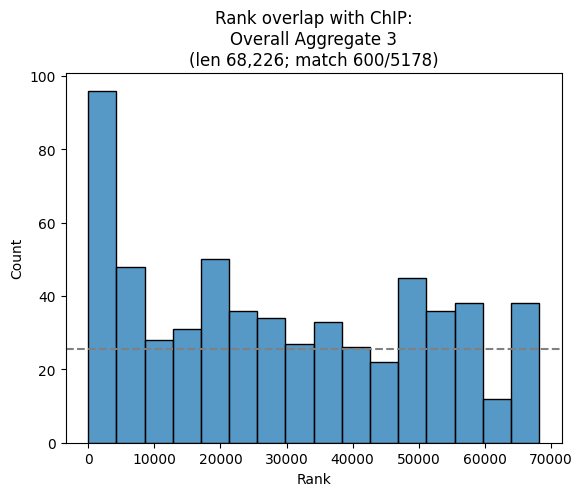

In [60]:
distenriched3_df_chip = distenriched3_df[distenriched3_df['Edge'].isin(chipseq_df['Edge'])]

bin_count = 16
bin_size = len(distenriched3_df) // bin_count
noise_per_bin = len(chipseq_df) * bin_size / len(regulatory_space)

ax = sns.histplot(distenriched3_df_chip['Rank'], bins=bin_count)
ax.axhline(noise_per_bin, color='grey', linestyle='--')
ax.set_title((
    f"Rank overlap with ChIP:\nOverall Aggregate 3\n"
    f"(len {len(distenriched3_df):,}; match {len(distenriched3_df_chip)}/{len(chipseq_df)})"
));

## Save aggregated network!

In [61]:
distenriched3_df

,Regulator,Gene,Score,Edge,Rank,MCC_on_ChIP
0,Rv1657,Rv1659,19999984,Rv1657_Rv1659,1,NaN
1,Rv1657,Rv1658,19999984,Rv1657_Rv1658,2,NaN
2,Rv3249c,Rv3250c,19999978,Rv3249c_Rv3250c,3,NaN
3,Rv0081,Rv0085,19999974,Rv0081_Rv0085,4,NaN
4,Rv3417c,Rv0440,19999969,Rv3417c_Rv0440,5,NaN
...,...,...,...,...,...,...
68221,Rv0608,Rv2722,9958309,Rv0608_Rv2722,68222,0.01
68222,Rv2327,Rv0690c,9958308,Rv2327_Rv0690c,68223,0.01
68223,Rv0135c,Rv3744,9958307,Rv0135c_Rv3744,68224,0.01
68224,Rv1909c,Rv2307D,9958306,Rv1909c_Rv2307D,68225,0.01


In [167]:
distenriched3_df[['Regulator', 'Gene', 'Rank']].to_csv('aggregate-mtb_candidate_v3_undirected.txt', sep='\t', index=False, header=False)

In [176]:
print('Regulators in network:', len(distenriched3_df['Regulator'].unique()), f'(out of {len(regulators_df[0])})')
print('Genes in network:', len(distenriched3_df['Gene'].unique()), f'(out of {len(annotation_df['Locus'].unique())})')

Regulators in network: 214 (out of 214)
Genes in network: 4027 (out of 4031)


In [178]:
print('Genes excluded from this network:')
annotation_df.loc[~annotation_df['Locus'].isin(distenriched3_df['Gene']), 'Locus']

Genes excluded from this network:


119     Rv1954A
2686    Rv1755c
3566    Rv2998A
4184    Rv0277A
Name: Locus, dtype: object

In [181]:
distenriched3_df[distenriched3_df['Gene'].eq('Rv0061c')]

,Regulator,Gene,Score,Edge,Rank,MCC_on_ChIP,Direction_analysis2
5771,Rv0653c,Rv0061c,9999876,Rv0653c_Rv0061c,5772,0.02,UP
15864,Rv3219,Rv0061c,9992881,Rv3219_Rv0061c,15865,0.01,resolve
21557,Rv0737,Rv0061c,9989408,Rv0737_Rv0061c,21558,0.01,resolve
21668,Rv3143,Rv0061c,9989338,Rv3143_Rv0061c,21669,0.01,UP
24122,Rv1027c,Rv0061c,9987876,Rv1027c_Rv0061c,24123,0.01,resolve
27089,Rv3055,Rv0061c,9986172,Rv3055_Rv0061c,27090,0.01,resolve
32070,Rv0043c,Rv0061c,9983306,Rv0043c_Rv0061c,32071,0.01,resolve
34615,Rv0054,Rv0061c,9981838,Rv0054_Rv0061c,34616,0.01,UP
35520,Rv1776c,Rv0061c,9981307,Rv1776c_Rv0061c,35521,0.01,UP
44274,Rv2887,Rv0061c,9976314,Rv2887_Rv0061c,44275,0.01,resolve


### \[reanalysis after the fact\]

So far I've been assuming the background noise will be `validation_size * network_size / regulatory_space_size / bin_count`. However, I think this might be an oversimplification. I think this situation actually represents a hypergeometric trial -- we're sampling _without replacement_. Compare the naive value with the expected value of a hypergeometric distribution.

In [252]:
# pop = len(regulatory_space)
# obj_of_interest = len(sanz_solid_df)
# hypergeom_n_draws = length of each network
# hypergeom_k_succ = number we are curious about

for i in range(len(axs)):
    df_i = constituent_networks_df.at[i, 'network_df']
    naive_noise_per_bin = len(sanz_solid_df) * len(df_i) / len(regulatory_space) / 32
    rand_var_experiment = scipy.stats.hypergeom(M=len(regulatory_space), n=len(sanz_solid_df), N=len(df_i))
    print(
        f'{constituent_networks_df.at[i, 'Method']:>10s}/{constituent_networks_df.at[i, 'Dataset']:<4s}, size {len(df_i):7,d}:',
        f'naive noise = {naive_noise_per_bin:.4f}, hypergeom mean = {rand_var_experiment.mean()/32:.4f}, hypergeom median = {rand_var_experiment.median()/32:.4f}'
    )

    ARACNe/RNA , size  30,005: naive noise = 0.4707, hypergeom mean = 0.4707, hypergeom median = 0.4688
    ARACNe/TFOE, size  28,215: naive noise = 0.4426, hypergeom mean = 0.4426, hypergeom median = 0.4375
       CLR/RNA , size 375,711: naive noise = 5.8934, hypergeom mean = 5.8934, hypergeom median = 5.9062
       CLR/TFOE, size 376,144: naive noise = 5.9002, hypergeom mean = 5.9002, hypergeom median = 5.9062
  cMonkey2/RNA , size 154,146: naive noise = 2.4179, hypergeom mean = 2.4179, hypergeom median = 2.4062
  cMonkey2/TFOE, size 201,211: naive noise = 3.1562, hypergeom mean = 3.1562, hypergeom median = 3.1562
Elasticnet/RNA , size 477,197: naive noise = 7.4853, hypergeom mean = 7.4853, hypergeom median = 7.5000
Elasticnet/TFOE, size 259,466: naive noise = 4.0700, hypergeom mean = 4.0700, hypergeom median = 4.0625
    GENIE3/RNA , size  99,883: naive noise = 1.5668, hypergeom mean = 1.5668, hypergeom median = 1.5625
    GENIE3/TFOE, size  99,223: naive noise = 1.5564, hypergeom m

Ok, cool -- with these set sizes my estimation (which I'm pretty sure assumes drawing with replacement) approximates well the mean of the appropriate hypergeometric distribution, the more proper estimate of expected overlap-bin-counts.

#### What about hypergeometric tests? Do the 3 we excluded actually fail that test?

Hypergeometric test can quantify the chances that an overlap occurred by chance. According to wikipedia, it's identical to a one-tailed Fisher's exact test. So let's run that on each of the networks' overlap with Sanz.

In [238]:
regulatory_space2 = pd.Index(
    data=((regulator, gene) for regulator in regulators_df[0] for gene in annotation_df['Locus'].unique() if regulator != gene),
    name=('Regulator', 'Gene')
)
regulatory_space2

MultiIndex([('Rv0019c', 'Rv2007c'),
            ('Rv0019c',  'Rv3451'),
            ('Rv0019c',  'Rv3452'),
            ('Rv0019c', 'Rv2658c'),
            ('Rv0019c', 'Rv2612c'),
            ('Rv0019c', 'Rv1724c'),
            ('Rv0019c',  'Rv1772'),
            ('Rv0019c', 'Rv1778c'),
            ('Rv0019c', 'Rv1914c'),
            ('Rv0019c',  'Rv1957'),
            ...
            ( 'Rv3911',  'Rv3913'),
            ( 'Rv3911', 'Rv3918c'),
            ( 'Rv3911', 'Rv3916c'),
            ( 'Rv3911', 'Rv3919c'),
            ( 'Rv3911', 'Rv3920c'),
            ( 'Rv3911',  'Rv3216'),
            ( 'Rv3911', 'Rv3924c'),
            ( 'Rv3911', 'Rv0277A'),
            ( 'Rv3911', 'Rv2427A'),
            ( 'Rv3911', 'Rv3922c')],
           names=['Regulator', 'Gene'], length=862420)

In [246]:
# significance_result = scipy.stats.fisher_exact(chip_overlap_df[['up', 'down']])
df_i = constituent_networks_df.at[0, 'network_df']

in_sanz = df_i['Edge'].isin(sanz_solid_df['Edge']).sum()
out_sanz = len(df_i) - in_sanz
sanz_excl = len(sanz_solid_df) - in_sanz
both_excl = len(regulatory_space2) - in_sanz - out_sanz - sanz_excl

print(in_sanz, out_sanz, sanz_excl, both_excl)

contingency_df_i = pd.DataFrame(data=[
    [in_sanz, sanz_excl],
    [out_sanz, both_excl],
], columns=['in df', 'not in df'], index=['in Sanz', 'not in Sanz'])

display(contingency_df_i)

result_i = scipy.stats.fisher_exact(contingency_df_i, 'greater')
# result_i.statistic, result_i.pvalue, result_i.dof, result_i.expected_freq
print('p-value for first network:', result_i.pvalue)

32 29973 401 832014


,in df,not in df
in Sanz,32,401
not in Sanz,29973,832014


p-value for first network: 6.892818646444285e-05


In [242]:
for i in range(len(axs)):
    df_i = constituent_networks_df.at[i, 'network_df']
    in_sanz = df_i['Edge'].isin(sanz_solid_df['Edge']).sum()
    out_sanz = len(df_i) - in_sanz
    sanz_excl = len(sanz_solid_df) - in_sanz
    both_excl = len(regulatory_space2) - in_sanz - out_sanz - sanz_excl
    contingency_df_i = pd.DataFrame(data=[
        [in_sanz, sanz_excl],
        [out_sanz, both_excl],
    ], columns=['in df', 'not in df'], index=['in Sanz', 'not in Sanz'])
    result_i = scipy.stats.fisher_exact(contingency_df_i, 'greater')
    print(
        f'{constituent_networks_df.at[i, 'Method']:>10s}/{constituent_networks_df.at[i, 'Dataset']:<4s},',
        f'network validation overlap differs from random: {result_i.pvalue:.2g}'
    )

    ARACNe/RNA , network validation overlap differs from random: 6.9e-05
    ARACNe/TFOE, network validation overlap differs from random: 5.9e-08
       CLR/RNA , network validation overlap differs from random: 0.62
       CLR/TFOE, network validation overlap differs from random: 9.6e-05
  cMonkey2/RNA , network validation overlap differs from random: 4.7e-06
  cMonkey2/TFOE, network validation overlap differs from random: 0.079
Elasticnet/RNA , network validation overlap differs from random: 0.0059
Elasticnet/TFOE, network validation overlap differs from random: 0.19
    GENIE3/RNA , network validation overlap differs from random: 2.4e-07
    GENIE3/TFOE, network validation overlap differs from random: 1.8e-07
  iModulon/RNA , network validation overlap differs from random: 0.36
  iModulon/TFOE, network validation overlap differs from random: 0.48


Interesting. Doesn't take into account rank, so, e.g., CLR/RNA looks pretty bad looking at the total number of overlaps, but looking at the enrichment up front, I think it still looks pretty convincing.

Let's try the same test, but on the truncated networks!

In [259]:
enrichment_hypergeom_p_vals = []
for i in range(len(axs)):
    df_i = constituent_networks_df.at[i, 'truncated_df']
    in_sanz = df_i['Edge'].isin(sanz_solid_df['Edge']).sum()
    out_sanz = len(df_i) - in_sanz
    sanz_excl = len(sanz_solid_df) - in_sanz
    both_excl = len(regulatory_space2) - in_sanz - out_sanz - sanz_excl
    contingency_df_i = pd.DataFrame(data=[
        [in_sanz, sanz_excl],
        [out_sanz, both_excl],
    ], columns=['in df', 'not in df'], index=['in Sanz', 'not in Sanz'])
    result_i = scipy.stats.fisher_exact(contingency_df_i, 'greater')
    enrichment_hypergeom_p_vals.append(result_i.pvalue)
    print(
        f'{constituent_networks_df.at[i, 'Method']:>10s}/{constituent_networks_df.at[i, 'Dataset']:<4s},',
        f'network validation overlap differs from random: {result_i.pvalue:.2g}'
    )

df_i = distenriched3_df
in_sanz = df_i['Edge'].isin(sanz_solid_df['Edge']).sum()
out_sanz = len(df_i) - in_sanz
sanz_excl = len(sanz_solid_df) - in_sanz
both_excl = len(regulatory_space2) - in_sanz - out_sanz - sanz_excl
contingency_df_i = pd.DataFrame(data=[
    [in_sanz, sanz_excl],
    [out_sanz, both_excl],
], columns=['in df', 'not in df'], index=['in Sanz', 'not in Sanz'])
# result_i = scipy.stats.fisher_exact(contingency_df_i, 'greater')
result_i = scipy.stats.fisher_exact(contingency_df_i)
enrichment_hypergeom_p_vals.append(result_i.pvalue)
print(
    f'{"Aggregate":>10s}/{"Both":<4s},',
    f'network validation overlap differs from random: {result_i.pvalue:.2g}'
)

reject_pvals, enrichment_hypergeom_p_adjs, _, _ = statsmodels.stats.multitest.multipletests(
    # enrichment_hypergeom_p_vals, alpha=0.05, method='fdr_tsbky', is_sorted=False) # FDR doesn't seem to be able to do anything here...
    enrichment_hypergeom_p_vals, alpha=0.05, method='bonferroni', is_sorted=False) # FDR doesn't seem to be able to do anything here...
print(reject_pvals)
print(enrichment_hypergeom_p_adjs)

    ARACNe/RNA , network validation overlap differs from random: 8.3e-08
    ARACNe/TFOE, network validation overlap differs from random: 0.00034
       CLR/RNA , network validation overlap differs from random: 5.6e-10
       CLR/TFOE, network validation overlap differs from random: 4.1e-09
  cMonkey2/RNA , network validation overlap differs from random: 1.6e-12
  cMonkey2/TFOE, network validation overlap differs from random: 0.0053
Elasticnet/RNA , network validation overlap differs from random: 4.1e-16
Elasticnet/TFOE, network validation overlap differs from random: 1.1e-08
    GENIE3/RNA , network validation overlap differs from random: 6.4e-08
    GENIE3/TFOE, network validation overlap differs from random: 3.5e-14
  iModulon/RNA , network validation overlap differs from random: 9.5e-23
  iModulon/TFOE, network validation overlap differs from random: 0.1
 Aggregate/Both, network validation overlap differs from random: 1.3e-12
[ True  True  True  True  True False  True  True  True  

So, according to fisher's exact test + Bonferroni, `cMonkey2/TFOE` and `iModulon/TFOE` should be excluded. `ARACNe/TFOE` is the next "worst", but does seem to pass significance thresholds.

# Directionality of regulation

## Get directionality data

In [62]:
linmod_tfoe_df = pd.read_csv(
    '../linmod_tfoefullpysnail.txt',
    sep='\t', header=None, index_col=None, names=['Regulator', 'Gene', 'Coef', 'R_squared'])

# fix misannotations
linmod_tfoe_df_invalid = linmod_tfoe_df[linmod_tfoe_df['Gene'].isin(tfoe_extra) | linmod_tfoe_df['Regulator'].isin(tfoe_extra)]
linmod_tfoe_df.drop(index=linmod_tfoe_df_invalid.index, inplace=True)
linmod_tfoe_df['Gene'] = linmod_tfoe_df['Gene'].map(lambda gene: tfoe_mapping[gene] if gene in tfoe_mapping else gene)
linmod_tfoe_df['Regulator'] = linmod_tfoe_df['Regulator'].map(lambda gene: tfoe_mapping[gene] if gene in tfoe_mapping else gene)
linmod_tfoe_df.reset_index(drop=True, inplace=True)
# end fix

linmod_tfoe_df['Edge'] = linmod_tfoe_df['Regulator'].str.cat(linmod_tfoe_df['Gene'], sep='_')
print(linmod_tfoe_df.shape)
linmod_tfoe_df.head()

(855358, 5)


,Regulator,Gene,Coef,R_squared,Edge
0,Rv0019c,Rv0001,-1.89e-02,0.85,Rv0019c_Rv0001
1,Rv0020c,Rv0001,5.50e-02,0.85,Rv0020c_Rv0001
2,Rv0022c,Rv0001,4.61e-03,0.85,Rv0022c_Rv0001
3,Rv0023,Rv0001,-1.75e-01,0.85,Rv0023_Rv0001
4,Rv0038,Rv0001,-7.00e-02,0.85,Rv0038_Rv0001


In [63]:
linmod_rna_df = pd.read_csv(
    '../archive/linmod_mtb-rna-20240625.txt',
    sep='\t', header=None, index_col=None, names=['Regulator', 'Gene', 'Coef', 'R_squared'])
linmod_rna_df['Edge'] = linmod_rna_df['Regulator'].str.cat(linmod_rna_df['Gene'], sep='_')
print(linmod_rna_df.shape)
linmod_rna_df.head()

(822984, 5)


,Regulator,Gene,Coef,R_squared,Edge
0,Rv0019c,Rv0001,-5.66e-02,0.91,Rv0019c_Rv0001
1,Rv0020c,Rv0001,1.43e-01,0.91,Rv0020c_Rv0001
2,Rv0022c,Rv0001,-2.86e-02,0.91,Rv0022c_Rv0001
3,Rv0023,Rv0001,-3.01e-03,0.91,Rv0023_Rv0001
4,Rv0038,Rv0001,1.01e-02,0.91,Rv0038_Rv0001


In [64]:
enetfull_tfoe_df = pd.read_csv(
    '../../mount2/elasticnet_v0.2_tfoe-full-pysnail_details.txt',
    sep=',', header=0, index_col=0)

# fix misannotations
enetfull_tfoe_df_invalid = enetfull_tfoe_df[enetfull_tfoe_df['Gene'].isin(tfoe_extra) | enetfull_tfoe_df['Regulator'].isin(tfoe_extra)]
enetfull_tfoe_df.drop(index=enetfull_tfoe_df_invalid.index, inplace=True)
enetfull_tfoe_df['Gene'] = enetfull_tfoe_df['Gene'].map(lambda gene: tfoe_mapping[gene] if gene in tfoe_mapping else gene)
enetfull_tfoe_df['Regulator'] = enetfull_tfoe_df['Regulator'].map(lambda gene: tfoe_mapping[gene] if gene in tfoe_mapping else gene)
enetfull_tfoe_df.reset_index(drop=True, inplace=True)
# end fix

enetfull_tfoe_df['Edge'] = enetfull_tfoe_df['Regulator'].str.cat(enetfull_tfoe_df['Gene'], sep='_')
print(enetfull_tfoe_df.shape)
enetfull_tfoe_df.head()

(259573, 6)


,Regulator,Gene,Coef,R_squared,Score,Edge
0,Rv0020c,Rv0001,0.02,0.75,0.01,Rv0020c_Rv0001
1,Rv0023,Rv0001,-0.12,0.75,0.09,Rv0023_Rv0001
2,Rv0038,Rv0001,-0.04,0.75,0.03,Rv0038_Rv0001
3,Rv0042c,Rv0001,0.09,0.75,0.07,Rv0042c_Rv0001
4,Rv0043c,Rv0001,0.02,0.75,0.01,Rv0043c_Rv0001


In [65]:
enetfull_rna_df = pd.read_csv(
    '../../mount2/elasticnet_v0.2_mtb-rna-20240625_details.txt',
    sep=',', header=0, index_col=0)
enetfull_rna_df['Edge'] = enetfull_rna_df['Regulator'].str.cat(enetfull_rna_df['Gene'], sep='_')
print(enetfull_rna_df.shape)
enetfull_rna_df.head()

(477361, 6)


,Regulator,Gene,Coef,R_squared,Score,Edge
0,Rv0019c,Rv0001,-5.29e-03,0.89,4.73e-03,Rv0019c_Rv0001
1,Rv0020c,Rv0001,1.21e-01,0.89,1.08e-01,Rv0020c_Rv0001
2,Rv0038,Rv0001,-1.02e-02,0.89,9.08e-03,Rv0038_Rv0001
3,Rv0047c,Rv0001,5.52e-02,0.89,4.93e-02,Rv0047c_Rv0001
4,Rv0054,Rv0001,-5.04e-02,0.89,4.50e-02,Rv0054_Rv0001


## Apply directionality from each dataset

In [66]:
distenriched3_df_directed = distenriched3_df.copy()

directionizers = {
    'Linmod_TFOE': linmod_tfoe_df,
    'Linmod_RNASeq': linmod_rna_df,
    'Enet_TFOE': enetfull_tfoe_df,
    'Enet_RNASeq': enetfull_rna_df,
}

for label, df in directionizers.items():
    df['Direction'] = df['Coef'].map(lambda coef: 'up' if coef > 0 else 'down' if coef < 0 else 'zero!')
    distenriched3_df_directed[label] = distenriched3_df_directed['Edge'].map(df.set_index('Edge')['Direction'])

distenriched3_df_directed

,Regulator,Gene,Score,Edge,Rank,MCC_on_ChIP,Linmod_TFOE,Linmod_RNASeq,Enet_TFOE,Enet_RNASeq
0,Rv1657,Rv1659,19999984,Rv1657_Rv1659,1,NaN,up,up,up,up
1,Rv1657,Rv1658,19999984,Rv1657_Rv1658,2,NaN,up,up,up,up
2,Rv3249c,Rv3250c,19999978,Rv3249c_Rv3250c,3,NaN,up,up,up,up
3,Rv0081,Rv0085,19999974,Rv0081_Rv0085,4,NaN,up,up,up,up
4,Rv3417c,Rv0440,19999969,Rv3417c_Rv0440,5,NaN,up,up,up,up
...,...,...,...,...,...,...,...,...,...,...
68221,Rv0608,Rv2722,9958309,Rv0608_Rv2722,68222,0.01,up,up,NaN,up
68222,Rv2327,Rv0690c,9958308,Rv2327_Rv0690c,68223,0.01,down,up,NaN,NaN
68223,Rv0135c,Rv3744,9958307,Rv0135c_Rv3744,68224,0.01,up,down,NaN,down
68224,Rv1909c,Rv2307D,9958306,Rv1909c_Rv2307D,68225,0.01,up,up,up,up


In [67]:
def vote_direction(row, details=True):
    ups_count = sum(row[label] == 'up' for label in directionizers)
    downs_count = sum(row[label] == 'down' for label in directionizers)

    if ups_count > downs_count:
        if details:
            return f'up ({ups_count}-{downs_count})'
        else:
            return 'up'
    elif downs_count > ups_count:
        if details:
            return f'down ({downs_count}-{ups_count})'
        else:
            return 'down'
    else:
        if details:
            return f'tie ({ups_count} each)'
        else:
            return 'tie'

In [68]:
distenriched3_df_directed['Direction'] = distenriched3_df_directed.apply(lambda row: vote_direction(row, details=False), axis=1)
distenriched3_df_directed['Direction_details'] = distenriched3_df_directed.apply(vote_direction, axis=1)
distenriched3_df_directed

,Regulator,Gene,Score,Edge,Rank,MCC_on_ChIP,Linmod_TFOE,Linmod_RNASeq,Enet_TFOE,Enet_RNASeq,Direction,Direction_details
0,Rv1657,Rv1659,19999984,Rv1657_Rv1659,1,NaN,up,up,up,up,up,up (4-0)
1,Rv1657,Rv1658,19999984,Rv1657_Rv1658,2,NaN,up,up,up,up,up,up (4-0)
2,Rv3249c,Rv3250c,19999978,Rv3249c_Rv3250c,3,NaN,up,up,up,up,up,up (4-0)
3,Rv0081,Rv0085,19999974,Rv0081_Rv0085,4,NaN,up,up,up,up,up,up (4-0)
4,Rv3417c,Rv0440,19999969,Rv3417c_Rv0440,5,NaN,up,up,up,up,up,up (4-0)
...,...,...,...,...,...,...,...,...,...,...,...,...
68221,Rv0608,Rv2722,9958309,Rv0608_Rv2722,68222,0.01,up,up,NaN,up,up,up (3-0)
68222,Rv2327,Rv0690c,9958308,Rv2327_Rv0690c,68223,0.01,down,up,NaN,NaN,tie,tie (1 each)
68223,Rv0135c,Rv3744,9958307,Rv0135c_Rv3744,68224,0.01,up,down,NaN,down,down,down (2-1)
68224,Rv1909c,Rv2307D,9958306,Rv1909c_Rv2307D,68225,0.01,up,up,up,up,up,up (4-0)


In [69]:
distenriched3_df_directed['Direction_details'].value_counts()

Direction_details
up (4-0)        18641
up (2-1)        11762
up (3-0)        11462
tie (2 each)     4604
down (2-1)       4109
down (4-0)       3967
down (3-0)       3880
tie (1 each)     3166
up (2-0)         2355
down (2-0)       2164
up (3-1)         1353
down (3-1)        418
down (1-0)        191
up (1-0)          154
Name: count, dtype: int64

In [70]:
direction_analysis = {
    'up (4-0)': 'UP',
    'up (2-1)': 'resolve',
    'up (3-0)': 'UP',
    'tie (2 each)': 'resolve',
    'down (2-1)': 'resolve',
    'down (4-0)': 'DOWN',
    'down (3-0)': 'DOWN',
    'tie (1 each)': 'resolve',
    'up (2-0)': 'UP',
    'down (2-0)': 'DOWN',
    'up (3-1)': 'resolve',
    'down (3-1)': 'resolve',
    'down (1-0)': 'DOWN',
    'up (1-0)': 'UP',
    'tie (0 each)': 'resolve', # no longer present after going back and fixing TFOE misannotations
}

distenriched3_df_directed['Direction_analysis'] = distenriched3_df_directed['Direction_details'].map(direction_analysis)
distenriched3_df_directed['Direction_analysis'].value_counts()

Direction_analysis
UP         32612
resolve    25412
DOWN       10202
Name: count, dtype: int64

## Resolve conflicting evidence

### Handle simple cases, favoring elasticnet models

In [93]:
def favor_elasticnet1(row):
    if row['Linmod_RNASeq'] != row['Enet_RNASeq'] and pd.notna(row['Enet_RNASeq']): # linmod never NaN if enet isn't NaN
        return row['Enet_RNASeq'].upper()
    elif row['Linmod_TFOE'] != row['Enet_TFOE'] and pd.notna(row['Enet_TFOE']): # linmod never NaN if enet isn't NaN
        return row['Enet_TFOE'].upper()
    else:
        return 'resolve'

def favor_elasticnet2(row):
    if row['Enet_RNASeq'] == row['Enet_TFOE']:
        return row['Enet_RNASeq'].upper()
    else:
        return 'BOTH'

directions_disagreement_of_one1 = ['up (2-1)', 'down (2-1)', 'tie (1 each)']
directions_disagreement_of_one2 = ['up (3-1)', 'down (3-1)']

distenriched3_df_directed['Direction_analysis2'] = distenriched3_df_directed['Direction_analysis']

distenriched3_df_directed.loc[
        distenriched3_df_directed['Direction_details'].isin(directions_disagreement_of_one1),
        'Direction_analysis2'
    ] = distenriched3_df_directed[
        distenriched3_df_directed['Direction_details'].isin(directions_disagreement_of_one1)
    ].apply(favor_elasticnet1, axis=1)

distenriched3_df_directed.loc[
        distenriched3_df_directed['Direction_details'].isin(directions_disagreement_of_one2),
        'Direction_analysis2'
    ] = distenriched3_df_directed[
        distenriched3_df_directed['Direction_details'].isin(directions_disagreement_of_one2)
    ].apply(favor_elasticnet2, axis=1)

distenriched3_df_directed['Direction_analysis2'].value_counts()

Direction_analysis2
UP         34562
resolve    22719
DOWN       10648
BOTH         297
Name: count, dtype: int64

In [94]:
print('Direction details where resolution is still required:')
distenriched3_df_directed.loc[distenriched3_df_directed['Direction_analysis2'].eq('resolve'), 'Direction_details'].value_counts()

Direction details where resolution is still required:


Direction_details
up (2-1)        11326
tie (2 each)     4604
down (2-1)       3694
tie (1 each)     3095
Name: count, dtype: int64

In [95]:
# take a look at what still needs to be resolved
print(distenriched3_df_directed[distenriched3_df_directed['Direction_analysis2'].eq('resolve')].shape)
distenriched3_df_directed[distenriched3_df_directed['Direction_analysis2'].eq('resolve')].head()

(22719, 15)


,Regulator,Gene,Score,Edge,Rank,MCC_on_ChIP,Linmod_TFOE,Linmod_RNASeq,Enet_TFOE,Enet_RNASeq,Direction,Direction_details,Direction_analysis,Direction_analysis2,TFOE_sigl2fc
22,Rv2250c,Rv2251,19999785,Rv2250c_Rv2251,23,NaN,down,up,NaN,up,up,up (2-1),resolve,resolve,down
29,Rv2250c,Rv2252,19999733,Rv2250c_Rv2252,30,NaN,down,up,NaN,up,up,up (2-1),resolve,resolve,down
97,Rv1219c,Rv1216c,19998845,Rv1219c_Rv1216c,98,NaN,down,up,NaN,up,up,up (2-1),resolve,resolve,down
105,Rv3557c,Rv3556c,19998797,Rv3557c_Rv3556c,106,NaN,down,up,NaN,up,up,up (2-1),resolve,resolve,down
116,Rv1990c,Rv1989c,19998701,Rv1990c_Rv1989c,117,NaN,down,up,NaN,up,up,up (2-1),resolve,resolve,down


In [96]:
# take a look at where the final direction call differs from the naive one
distenriched3_df_directed[
    distenriched3_df_directed['Direction'].ne(distenriched3_df_directed['Direction_analysis2'].str.lower()) &
        distenriched3_df_directed['Direction_analysis2'].ne('resolve')
]

,Regulator,Gene,Score,Edge,Rank,MCC_on_ChIP,Linmod_TFOE,Linmod_RNASeq,Enet_TFOE,Enet_RNASeq,Direction,Direction_details,Direction_analysis,Direction_analysis2,TFOE_sigl2fc
435,Rv1267c,Rv1467c,19995118,Rv1267c_Rv1467c,436,0.02,down,down,up,NaN,down,down (2-1),resolve,UP,NaN
1189,Rv3855,Rv2878c,19987913,Rv3855_Rv2878c,1190,0.02,down,down,up,NaN,down,down (2-1),resolve,UP,NaN
1579,Rv3246c,Rv1478,19984279,Rv3246c_Rv1478,1580,0.02,down,down,up,NaN,down,down (2-1),resolve,UP,NaN
2201,Rv3833,Rv2036,19978633,Rv3833_Rv2036,2202,0.02,down,down,up,NaN,down,down (2-1),resolve,UP,NaN
2238,Rv0452,Rv3322c,19978395,Rv0452_Rv3322c,2239,0.02,up,up,down,up,up,up (3-1),resolve,BOTH,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67824,Rv0653c,Rv0952,9958736,Rv0653c_Rv0952,67825,0.01,up,up,down,up,up,up (3-1),resolve,BOTH,NaN
67868,Rv0691c,Rv0300,9958688,Rv0691c_Rv0300,67869,0.01,down,down,down,up,down,down (3-1),resolve,BOTH,NaN
67933,Rv0212c,Rv2188c,9958619,Rv0212c_Rv2188c,67934,0.01,down,down,NaN,up,down,down (2-1),resolve,UP,NaN
67963,Rv0691c,Rv1271c,9958584,Rv0691c_Rv1271c,67964,0.01,down,down,NaN,up,down,down (2-1),resolve,UP,NaN


In [97]:
direction_ties = ['tie (2 each)', 'tie (1 each)']

def break_ties(row):
    if pd.notna(row['Enet_RNASeq']) and row['Enet_RNASeq'] == row['Enet_TFOE']: # the enets agree: go with them
        return row['Enet_RNASeq'].upper()
    elif row['Direction_details'] == 'tie (1 each)' and pd.notna(row['Enet_RNASeq']): # it's only RNAseq results: go with enet over linmod
        return row['Enet_RNASeq'].upper()
    elif row['Direction_details'] == 'tie (1 each)' and pd.notna(row['Enet_TFOE']): # it's only TFOE results: go with enet over linmod
        return row['Enet_TFOE'].upper()
    elif row['Direction_details'] == 'tie (2 each)': # the enet models disagree, suggesting there's regulation in both directions
        return 'BOTH'
    else: # the linear models disagree, but without elasticnet corroboration. I think at this point we have insufficient data on directionality.
        return 'UNKNOWN'

distenriched3_df_directed.loc[
        distenriched3_df_directed['Direction_details'].isin(direction_ties) & distenriched3_df_directed['Direction_analysis2'].eq('resolve'),
        'Direction_analysis2'
    ] = distenriched3_df_directed[
        distenriched3_df_directed['Direction_details'].isin(direction_ties) & distenriched3_df_directed['Direction_analysis2'].eq('resolve')
    ].apply(break_ties, axis=1)

distenriched3_df_directed['Direction_analysis2'].value_counts()

Direction_analysis2
UP         34597
resolve    15020
DOWN       10655
BOTH        4859
UNKNOWN     3095
Name: count, dtype: int64

In [98]:
# take another look at what's left to do
print(distenriched3_df_directed[distenriched3_df_directed['Direction_analysis2'].eq('resolve')].shape)
display(distenriched3_df_directed[distenriched3_df_directed['Direction_analysis2'].eq('resolve')].head())
distenriched3_df_directed.loc[distenriched3_df_directed['Direction_analysis2'].eq('resolve'), 'Direction_details'].value_counts()

(15020, 15)


,Regulator,Gene,Score,Edge,Rank,MCC_on_ChIP,Linmod_TFOE,Linmod_RNASeq,Enet_TFOE,Enet_RNASeq,Direction,Direction_details,Direction_analysis,Direction_analysis2,TFOE_sigl2fc
22,Rv2250c,Rv2251,19999785,Rv2250c_Rv2251,23,NaN,down,up,NaN,up,up,up (2-1),resolve,resolve,down
29,Rv2250c,Rv2252,19999733,Rv2250c_Rv2252,30,NaN,down,up,NaN,up,up,up (2-1),resolve,resolve,down
97,Rv1219c,Rv1216c,19998845,Rv1219c_Rv1216c,98,NaN,down,up,NaN,up,up,up (2-1),resolve,resolve,down
105,Rv3557c,Rv3556c,19998797,Rv3557c_Rv3556c,106,NaN,down,up,NaN,up,up,up (2-1),resolve,resolve,down
116,Rv1990c,Rv1989c,19998701,Rv1990c_Rv1989c,117,NaN,down,up,NaN,up,up,up (2-1),resolve,resolve,down


Direction_details
up (2-1)      11326
down (2-1)     3694
Name: count, dtype: int64

At this point... I think I want to look at the coefficient and R^2 data from the linear models. I'd bet some of these minority reports are spurious, based on a small coefficient on a fit line that's not very good anyway. But some might be real... right? Or... the minority report doesn't have an elasticnet coefficient to back it up. Maybe that already says the trend is spurious.

To recap: for the remaining problem edges, _one linear model says one thing_, and _the other linear model and its elasticnet counterpart say the other_. The question is, does this represent an example of "BOTH", where a TF can regulate its target in both directions depending on the conditions, or is it an example of a spurious coefficient in the minority linear model?

Both seem plausible. It doesn't hurt to bring in the coefficient data.

### Bring in detailed results for less straightforward cases

In [99]:
# get model data from linear models for edges where it's the minority report and we still need to resolve the edge
resolution_df = pd.DataFrame(
    index=distenriched3_df_directed.loc[
        distenriched3_df_directed['Linmod_TFOE'].ne(distenriched3_df_directed['Direction']) & \
            distenriched3_df_directed['Direction_analysis2'].eq('resolve'),
        'Edge'
    ],
    columns=pd.MultiIndex.from_product((('Linmod_TFOE', 'Linmod_RNASeq'), ('Coef', 'R_squared')))
)

resolution_df[[('Linmod_TFOE', 'Coef'), ('Linmod_TFOE', 'R_squared')]] = linmod_tfoe_df.set_index('Edge')[['Coef', 'R_squared']]
resolution_df[[('Linmod_RNASeq', 'Coef'), ('Linmod_RNASeq', 'R_squared')]] = linmod_rna_df.set_index('Edge')[['Coef', 'R_squared']]

print(resolution_df.shape)
resolution_df.head()

(10097, 4)


Linmod_TFOE           Linmod_RNASeq          
                       Coef R_squared          Coef R_squared
Edge                                                         
Rv2250c_Rv2251        -0.34      0.82          0.66      0.87
Rv2250c_Rv2252        -0.30      0.84          0.52      0.85
Rv1219c_Rv1216c       -0.04      0.68          0.57      0.83
Rv3557c_Rv3556c       -0.41      0.70          0.61      0.86
Rv1990c_Rv1989c       -0.12      0.76          0.42      0.90

In [100]:
print(resolution_df['Linmod_TFOE', 'R_squared'].lt(0.5).sum(), 'rows where TFOE R^2 is less than 0.5')
print(
    'In',
    resolution_df['Linmod_TFOE', 'R_squared'].lt(0.5).__and__(resolution_df['Linmod_RNASeq', 'R_squared'].gt(0.75)).sum(),
    'of them, the RNAseq R^2 is greater than 0.75 (all are greater than 0.5)'
)
resolution_df[resolution_df['Linmod_TFOE', 'R_squared'].lt(0.5)].head()

54 rows where TFOE R^2 is less than 0.5
In 50 of them, the RNAseq R^2 is greater than 0.75 (all are greater than 0.5)


Linmod_TFOE           Linmod_RNASeq          
                       Coef R_squared          Coef R_squared
Edge                                                         
Rv1358_Rv0602c    -7.74e-02      0.40          0.12      0.91
Rv1049_Rv1674c    -1.76e-01      0.49          0.14      0.81
Rv1049_Rv1051c    -7.15e-02      0.47          0.36      0.90
Rv0737_Rv0602c    -5.17e-03      0.40          0.15      0.91
Rv2282c_Rv1051c   -4.45e-02      0.47          0.13      0.90

In [101]:
resolution_df['Regulator'] = resolution_df.index.to_series().map(lambda edge: edge.split('_')[0])
resolution_df['Gene'] = resolution_df.index.to_series().map(lambda edge: edge.split('_')[1])
resolution_df

Linmod_TFOE           Linmod_RNASeq           Regulator  \
                       Coef R_squared          Coef R_squared             
Edge                                                                      
Rv2250c_Rv2251        -0.34      0.82          0.66      0.87   Rv2250c   
Rv2250c_Rv2252        -0.30      0.84          0.52      0.85   Rv2250c   
Rv1219c_Rv1216c       -0.04      0.68          0.57      0.83   Rv1219c   
Rv3557c_Rv3556c       -0.41      0.70          0.61      0.86   Rv3557c   
Rv1990c_Rv1989c       -0.12      0.76          0.42      0.90   Rv1990c   
...                     ...       ...           ...       ...       ...   
Rv2374c_Rv0192        -0.02      0.74          0.07      0.84   Rv2374c   
Rv0691c_Rv0557        -0.02      0.93          0.02      0.79   Rv0691c   
Rv0324_Rv0575c         0.09      0.72         -0.10      0.88    Rv0324   
Rv0691c_Rv2749        -0.03      0.80          0.03      0.82   Rv0691c   
Rv0135c_Rv3744         0.04      0.68         -0.03      0.79   Rv0135c   

                    Gene  
                          
Edge                      
Rv2250c_Rv2251    Rv2251  
Rv2250c_Rv2252    Rv2252  
Rv1219c_Rv1216c  Rv1216c  
Rv3557c_Rv3556c  Rv3556c  
Rv1990c_Rv1989c  Rv1989c  
...                  ...  
Rv2374c_Rv0192    Rv0192  
Rv0691c_Rv0557    Rv0557  
Rv0324_Rv0575c   Rv0575c  
Rv0691c_Rv2749    Rv2749  
Rv0135c_Rv3744    Rv3744  

[10097 rows x 6 columns]

#### Use TFOE transcriptome to help?

In [80]:
tfoefull_raw_df = pd.read_csv(
    '../../../Papers/GSE59086/GSE59086_tfoe-full-with-replicates.csv',
    sep=',', header=0, index_col=0)
tfoefull_raw_df.index.name = 'Sample'
tfoefull_raw_df.index = tfoefull_raw_df.index.to_series().str.strip() # they all end in newlines atm ¯\_(ツ)_/¯
tfoefull_raw_df.columns.name = 'Gene'
print(tfoefull_raw_df.shape)
tfoefull_raw_df.head()

(698, 4026)


Gene,Rv0001,Rv0002,Rv0003,Rv0004,Rv0005,Rv0006,Rv0007,Rv0008c,Rv0009,Rv0010c,...,Rvnt24,Rvnt27,Rvnt28,Rvnt29,Rvnt30,Rvnt32,Rvnt33,Rvnt34,Rvnt40,Rvnt41
Sample,,,,,,,,,,,,,,,,,,,,,
GSM1426365,13.22,12.99,13.21,13.23,14.55,14.53,13.93,10.94,13.91,12.91,...,9.97,13.25,11.18,12.23,12.33,12.49,12.67,11.76,12.37,13.50
GSM1426366,12.81,13.53,12.47,12.61,14.06,14.09,13.98,11.47,14.49,13.04,...,8.87,12.93,11.20,12.86,12.65,13.19,12.48,13.51,12.63,14.84
GSM1426367,13.00,13.56,12.97,12.89,14.16,14.19,13.84,11.36,14.82,13.08,...,9.21,13.40,11.36,12.73,11.82,12.83,12.77,12.10,12.08,14.97
GSM1426368,12.67,13.61,12.77,12.69,14.16,14.19,14.02,11.31,14.54,12.74,...,9.26,12.55,11.52,12.77,12.53,13.47,12.54,13.64,12.58,14.05
GSM1426369,12.98,12.78,13.24,13.19,14.54,14.51,14.06,10.35,13.59,12.72,...,10.20,13.06,10.55,11.91,12.67,12.19,12.70,12.71,12.43,13.95


In [81]:
tfoefull_metadata_df = pd.read_csv(
    '../../../Papers/GSE59086/GSE59086_tfoe-metadata.tsv',
    sep='\t', header=0, index_col=0)
print(tfoefull_metadata_df.shape)
tfoefull_metadata_df.head()

(698, 12)


,Title,TFOE,Sample Type,Taxonomy,Channels,Platform,Series,Supplementary Types,Supplementary Links,SRA Accession,Contact,Release Date
Accession,,,,,,,,,,,,
GSM1426365,TFOE_7264_0019c_A,Rv0019,RNA,Mycobacterium tuberculosis H37Rv,1,GPL14824,GSE59086,XYS,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1426...,NaN,Tige Rustad,4-Jul-14
GSM1426366,TFOE_7590_0019c,Rv0019,RNA,Mycobacterium tuberculosis H37Rv,1,GPL14824,GSE59086,XYS,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1426...,NaN,Tige Rustad,4-Jul-14
GSM1426367,TFOE_8440_0019c_C,Rv0019,RNA,Mycobacterium tuberculosis H37Rv,1,GPL14824,GSE59086,XYS,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1426...,NaN,Tige Rustad,4-Jul-14
GSM1426368,TFOE_2323_0020c,Rv0020,RNA,Mycobacterium tuberculosis H37Rv,1,GPL14824,GSE59086,XYS,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1426...,NaN,Tige Rustad,4-Jul-14
GSM1426369,TFOE_9153_0020c_B,Rv0020,RNA,Mycobacterium tuberculosis H37Rv,1,GPL14824,GSE59086,XYS,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1426...,NaN,Tige Rustad,4-Jul-14


In [269]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [301]:
p_value = 0.05
log2foldchange = 1

dds = DeseqDataSet(
    counts=tfoefull_raw_df.round(0).astype(int),
    metadata=tfoefull_metadata_df,
    design_factors='TFOE',
    fit_type='mean', # parametric seems to fail on this dataset
    n_cpus=12, # defaults to all, which was killing my machine...
)
dds.deseq2()
deseq_stats = DeseqStats(dds, alpha=p_value)
deseq_stats.summary() # have to run this to get results

results = deseq_stats.results_df[
    (deseq_stats.results_df['padj'] < p_value) &
    (abs(deseq_stats.results_df['log2FoldChange']) > log2foldchange)
]
results

Fitting size factors...
... done in 0.15 seconds.

Fitting dispersions...
... done in 331.28 seconds.

Fitting dispersion trend curve...
... done in 0.00 seconds.

C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Fitting MAP dispersions...
... done in 63791.64 seconds.

Fitting LFCs...
... done in 35.92 seconds.

Calculating cook's distance...
... done in 0.54 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: TFOE Rv0020 vs Rv0019
        baseMean  log2FoldChange  lfcSE      stat  pvalue  padj
Gene                                                           
Rv0001     12.86        1.28e-03   0.33  3.92e-03    1.00   1.0
Rv0002     13.28       -3.43e-02   0.32 -1.07e-01    0.91   1.0
Rv0003     12.88        3.88e-02   0.33  1.18e-01    0.91   1.0
Rv0004     12.83        1.28e-03   0.33  3.92e-03    1.00   1.0
Rv0005     14.06        1.28e-03   0.31  4.12e-03    1.00   1.0
...          ...             ...    ...       ...     ...   ...
Rvnt32     12.62        1.28e-03   0.33  3.87e-03    1.00   1.0
Rvnt33     12.59        3.88e-02   0.33  1.18e-01    0.91   1.0
Rvnt34     12.57        7.53e-02   0.33  2.30e-01    0.82   1.0
Rvnt40     12.59        1.28e-03   0.34  3.82e-03    1.00   1.0
Rvnt41     14.28        1.28e-03   0.31  4.12e-03    1.00   1.0

[4026 rows x 6 columns]


... done in 6.35 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene,,,,,,


In [302]:
deseq_stats.results_df[
    (deseq_stats.results_df['padj'] < p_value)
]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene,,,,,,


Hmmm no significant results. I guess this is looking at significant differences across all conditions? I think I want to just look at each condition separately vs control. But... do we even have control samples?? Nope.

Let's use the TFOE dataset instead -- where a TFOE strain has a significant p-value against the gene in question, the direction of the fold-change should give us a good guess as to the direction of regulation. (Might not be complete, but should be reliable.)

#### Use TFOE L2FC data to help

In [82]:
tfoe_l2fc_df = pd.read_excel(
    '../../../../../FrontiersMtbSysbioProject/tfoe.searchable_130115.xlsx',
    sheet_name='TFOE.data', index_col=0, usecols='A:HB', skiprows=9, nrows=4027)
# tfoe_tfs = np.array(tfoe_l2fc_df.columns.unique())
print(tfoe_l2fc_df.shape)
display(tfoe_l2fc_df.head())

tfoe_pval_df = pd.read_excel(
    '../../../../../FrontiersMtbSysbioProject/tfoe.searchable_130115.xlsx',
    sheet_name='TFOE.data', header=0, index_col=0, usecols='HC:PD', skiprows=9, nrows=4027)
tfoe_pval_df.rename(columns=lambda c: c[:-2], inplace=True) # remove ".1" automatically added to the end of each column name
print(tfoe_pval_df.shape)
display(tfoe_pval_df.head())

(4026, 209)


,Rv0019c,Rv0020c,Rv0022c,Rv0023,Rv0038,Rv0042c,Rv0043c,Rv0047c,Rv0054,Rv0067c,...,Rv3744,Rv3765c,Rv3830c,Rv3833,Rv3840,Rv3849,Rv3852,Rv3855,Rv3862c,Rv3911
ID,,,,,,,,,,,,,,,,,,,,,
Rv0001,0.14,0.02,-7.34e-01,-1.68,0.10,0.27,0.06,0.16,0.11,0.07,...,-2.27e-01,0.26,8.20e-02,0.08,-0.04,-0.63,-3.53e-01,1.63e-01,-0.06,-0.67
Rv0002,0.05,-0.02,-1.81e-01,0.63,0.16,0.04,0.23,0.28,0.21,-0.04,...,4.00e-03,0.10,5.30e-02,0.27,0.18,-0.92,-4.00e-03,2.11e-01,-0.12,-0.18
Rv0003,0.08,0.19,-2.03e-01,-0.69,0.22,0.07,0.11,0.34,0.11,-0.04,...,-2.95e-01,-0.07,9.00e-03,-0.04,0.10,-0.16,-2.51e-01,3.50e-02,0.12,-0.45
Rv0004,0.21,0.16,1.69e-01,-1.08,0.11,0.29,-0.04,0.35,-0.14,-0.10,...,1.20e-02,-0.08,8.00e-03,-0.09,-0.17,0.10,4.10e-02,1.17e-01,0.17,-0.03
Rv0005,0.05,0.09,-1.00e-03,-0.69,0.11,0.17,0.03,0.13,0.18,-0.26,...,-2.18e-01,0.12,-7.60e-02,-0.11,0.02,-0.27,-2.87e-01,5.00e-03,0.01,-0.30


(4026, 209)


,Rv0019c,Rv0020c,Rv0022c,Rv0023,Rv0038,Rv0042c,Rv0043c,Rv0047c,Rv0054,Rv0067c,...,Rv3744,Rv3765c,Rv3830c,Rv3833,Rv3840,Rv3849,Rv3852,Rv3855,Rv3862c,Rv3911
ID.1,,,,,,,,,,,,,,,,,,,,,
Rv0001,0.99,1.00,6.12e-04,2.92e-17,1.0,0.73,0.95,0.71,0.99,0.95,...,0.84,0.43,1.0,1.0,0.98,3.12e-03,0.47,0.88,0.89,9.66e-03
Rv0002,1.00,1.00,4.93e-01,7.01e-04,1.0,0.96,0.61,0.40,0.95,0.98,...,1.00,0.79,1.0,1.0,0.87,1.18e-06,1.00,0.83,0.72,6.42e-01
Rv0003,1.00,0.92,3.04e-01,3.75e-06,1.0,0.89,0.82,0.14,0.99,0.97,...,0.75,0.83,1.0,1.0,0.91,3.79e-01,0.50,0.97,0.63,2.38e-02
Rv0004,0.90,0.94,3.74e-01,4.32e-15,1.0,0.52,0.95,0.09,0.97,0.92,...,0.99,0.78,1.0,1.0,0.82,5.89e-01,0.96,0.87,0.42,9.43e-01
Rv0005,1.00,0.99,9.97e-01,1.00e-06,1.0,0.76,0.97,0.67,0.93,0.81,...,0.79,0.65,1.0,1.0,0.98,8.90e-02,0.37,0.99,0.97,1.63e-01


In [83]:
tfoe_analysis_df = pd.merge(
    left=tfoe_l2fc_df.reset_index(names='Gene').melt(id_vars='Gene', var_name='Regulator', value_name='l2fc'),
    right=tfoe_pval_df.reset_index(names='Gene').melt(id_vars='Gene', var_name='Regulator', value_name='p_val'),
    on=['Regulator', 'Gene'],
)
tfoe_analysis_df['Gene'] = tfoe_analysis_df['Gene'].map(lambda gene: tfoe_mapping[gene] if gene in tfoe_mapping else gene)
tfoe_analysis_df['Regulator'] = tfoe_analysis_df['Regulator'].map(lambda gene: tfoe_mapping[gene] if gene in tfoe_mapping else gene)
tfoe_analysis_df['Edge'] = tfoe_analysis_df['Regulator'].str.cat(tfoe_analysis_df['Gene'], sep='_')
print(tfoe_analysis_df.shape)
tfoe_analysis_df.head()

(841434, 5)


,Gene,Regulator,l2fc,p_val,Edge
0,Rv0001,Rv0019c,0.14,0.99,Rv0019c_Rv0001
1,Rv0002,Rv0019c,0.05,1.00,Rv0019c_Rv0002
2,Rv0003,Rv0019c,0.08,1.00,Rv0019c_Rv0003
3,Rv0004,Rv0019c,0.21,0.90,Rv0019c_Rv0004
4,Rv0005,Rv0019c,0.05,1.00,Rv0019c_Rv0005


In [84]:
reject, tfoe_analysis_df['p_adj'], alphac_Sidak, alphac_Bonf, = statsmodels.stats.multitest.multipletests(
    tfoe_analysis_df['p_val'], alpha=0.05, method='fdr_tsbky', is_sorted=False)

In [85]:
tfoe_analysis_sig_df = tfoe_analysis_df[tfoe_analysis_df['p_adj'].lt(0.05)].copy()
tfoe_analysis_sig_df['Direction'] = tfoe_analysis_sig_df['l2fc'].map(lambda l2fc: 'up' if l2fc > 0 else 'down') # sig l2fc will never be zero
tfoe_analysis_sig_df['l2fc_abs'] = tfoe_analysis_sig_df['l2fc'].abs()
print('Ups:', tfoe_analysis_sig_df['Direction'].eq('up').sum(), '| Downs:', tfoe_analysis_sig_df['Direction'].eq('down').sum())
print('Minimum absolute l2fc:', tfoe_analysis_sig_df['l2fc_abs'].min())
display(tfoe_analysis_sig_df.head())

Ups: 7583 | Downs: 10624
Minimum absolute l2fc: 0.178


,Gene,Regulator,l2fc,p_val,Edge,p_adj,Direction,l2fc_abs
18,Rv0019c,Rv0019c,1.18,1.55e-11,Rv0019c_Rv0019c,4.25e-09,up,1.18
756,Rv0743c,Rv0019c,-1.02,7.20e-04,Rv0019c_Rv0743c,3.67e-02,down,1.02
1499,Rv1473A,Rv0019c,-1.37,3.23e-04,Rv0019c_Rv1473A,1.87e-02,down,1.37
1871,Rv1838c,Rv0019c,-1.35,1.09e-09,Rv0019c_Rv1838c,2.26e-07,down,1.35
2317,Rv2278,Rv0019c,-1.02,1.57e-10,Rv0019c_Rv2278,3.73e-08,down,1.02


In [86]:
distenriched3_df_directed['TFOE_sigl2fc'] = distenriched3_df_directed['Edge'].map(tfoe_analysis_sig_df.set_index('Edge')['Direction'])
print(distenriched3_df_directed['TFOE_sigl2fc'].shape, 'of which', distenriched3_df_directed['TFOE_sigl2fc'].notna().sum(), 'are not NaN')
distenriched3_df_directed['TFOE_sigl2fc'].head()

(68226,) of which 2966 are not NaN


0      up
1      up
2     NaN
3    down
4     NaN
Name: TFOE_sigl2fc, dtype: object

In [102]:
def incorporate_tfoe_l2fc(row):
    if row['TFOE_sigl2fc'] == row['Enet_RNASeq'] and pd.notna(row['TFOE_sigl2fc']):
        return row['TFOE_sigl2fc'].upper()
    elif row['TFOE_sigl2fc'] != row['Enet_RNASeq'] and pd.notna(row['TFOE_sigl2fc']) and pd.notna(row['Enet_RNASeq']):
        return 'BOTH'
    elif row['Direction_details'] == 'up (2-1)' and row['TFOE_sigl2fc'] == 'down': # in some cases l2fc disagrees with TFOE linmod and enet!
        return 'BOTH'
    elif row['Direction_details'] == 'down (2-1)' and row['TFOE_sigl2fc'] == 'up': # in some cases l2fc disagrees with TFOE linmod and enet!
        return 'BOTH'
    else:
        return 'resolve'

distenriched3_df_directed.loc[
        distenriched3_df_directed['Direction_analysis2'].eq('resolve'),
        'Direction_analysis2'
    ] = distenriched3_df_directed[
        distenriched3_df_directed['Direction_analysis2'].eq('resolve')
    ].apply(incorporate_tfoe_l2fc, axis=1)

distenriched3_df_directed['Direction_analysis2'].value_counts()

Direction_analysis2
UP         34627
resolve    14777
DOWN       10669
BOTH        5058
UNKNOWN     3095
Name: count, dtype: int64

In [103]:
distenriched3_df_directed.loc[
    distenriched3_df_directed['Direction_analysis2'].eq('resolve'),
    'Direction_details'
].value_counts()

Direction_details
up (2-1)      11117
down (2-1)     3660
Name: count, dtype: int64

Alright.... it might be time to call it. We might just not have the data to make the perfect directional call on all of these relationships -- and I think we need to take them as estimates anyway.

Maybe for the remaining edges, we mark them with the direction and that there's some evidence of the opposite, too. E.g., for remaining `up (2-1)` rows, there's a good chunk of evidence pointing to up-regulation, and there's a little bit of evidence pointing to down-regulation, so let's mark them as `UP; MAYBE BOTH`. And `DOWN; MAYBE BOTH` for remaining `down (2-1)`.

In [104]:
distenriched3_df_directed.loc[
        distenriched3_df_directed['Direction_analysis2'].eq('resolve') &
            distenriched3_df_directed['Direction_details'].eq('up (2-1)'),
        'Direction_analysis2'
    ] = 'UP; MAYBE BOTH'

distenriched3_df_directed.loc[
        distenriched3_df_directed['Direction_analysis2'].eq('resolve') &
            distenriched3_df_directed['Direction_details'].eq('down (2-1)'),
        'Direction_analysis2'
    ] = 'DOWN; MAYBE BOTH'

In [105]:
distenriched3_df_directed['Direction_analysis2'].value_counts()

Direction_analysis2
UP                  34627
UP; MAYBE BOTH      11117
DOWN                10669
BOTH                 5058
DOWN; MAYBE BOTH     3660
UNKNOWN              3095
Name: count, dtype: int64

In [91]:
distenriched3_df_directed.loc[
    distenriched3_df_directed['Linmod_TFOE'].eq(distenriched3_df_directed['Enet_TFOE']) &
        distenriched3_df_directed['Linmod_TFOE'].ne(distenriched3_df_directed['TFOE_sigl2fc']) &
        distenriched3_df_directed['TFOE_sigl2fc'].notna(),
    'Regulator'
].value_counts().head()

Regulator
Rv3849     33
Rv0576     26
Rv0081     22
Rv0238     18
Rv3133c     7
Name: count, dtype: int64

In [92]:
distenriched3_df_directed[
    distenriched3_df_directed['Linmod_TFOE'].eq(distenriched3_df_directed['Enet_TFOE']) &
        distenriched3_df_directed['Linmod_TFOE'].ne(distenriched3_df_directed['TFOE_sigl2fc']) &
        distenriched3_df_directed['TFOE_sigl2fc'].notna()
].groupby(
    'Regulator'
)[[
    'Direction_details', 'Direction_analysis2', 'TFOE_sigl2fc'
]].value_counts().xs('Rv0081')

Direction_details  Direction_analysis2  TFOE_sigl2fc
down (3-1)         DOWN                 up              1
up (2-1)           BOTH                 down            1
Name: count, dtype: int64

# Directionality, v2.0

## Datasets, v2.0

- Get new linear models that include p-values for each edge
- Reuse elasticnet and TFOE expression dataframes
- Threshold all datasets at this point to only yield significant relationships

In [106]:
l2fc_cutoff = 1
padj_cutoff = 0.05
r_sq_cutoff = 0.8

In [107]:
linmod_tfoe_df2 = pd.read_csv(
    '../../mount2/linmod2_tfoefullpysnail.txt',
    sep='\t', index_col=None)

# fix misannotations
linmod_tfoe_df2_invalid = linmod_tfoe_df2[linmod_tfoe_df2['Gene'].isin(tfoe_extra) | linmod_tfoe_df2['Regulator'].isin(tfoe_extra)]
linmod_tfoe_df2.drop(index=linmod_tfoe_df2_invalid.index, inplace=True)
linmod_tfoe_df2['Gene'] = linmod_tfoe_df2['Gene'].map(lambda gene: tfoe_mapping[gene] if gene in tfoe_mapping else gene)
linmod_tfoe_df2['Regulator'] = linmod_tfoe_df2['Regulator'].map(lambda gene: tfoe_mapping[gene] if gene in tfoe_mapping else gene)
linmod_tfoe_df2.reset_index(drop=True, inplace=True)
# end fix

linmod_tfoe_df2['Edge'] = linmod_tfoe_df2['Regulator'].str.cat(linmod_tfoe_df2['Gene'], sep='_')
_, linmod_tfoe_df2['p_adj'], _, _ = statsmodels.stats.multitest.multipletests(
    linmod_tfoe_df2['p-val'], alpha=0.05, method='fdr_tsbky', is_sorted=False)

linmod_tfoe_df2 = linmod_tfoe_df2[linmod_tfoe_df2['p_adj'].le(padj_cutoff)].set_index('Edge')

print(linmod_tfoe_df2.shape)
linmod_tfoe_df2.head()

(42304, 6)


,Regulator,Gene,Coef,p-val,R_squared,p_adj
Edge,,,,,,
Rv0019c_Rv0001,Rv0019c,Rv0001,0.02,0.00e+00,0.85,0.00e+00
Rv0038_Rv0001,Rv0038,Rv0001,0.06,7.67e-06,0.85,6.63e-04
Rv0117_Rv0001,Rv0117,Rv0001,-0.03,5.76e-04,0.85,1.91e-02
Rv0182c_Rv0001,Rv0182c,Rv0001,-0.28,9.19e-05,0.85,5.02e-03
Rv0324_Rv0001,Rv0324,Rv0001,-0.04,6.82e-05,0.85,3.98e-03


In [108]:
linmod_rna_df2 = pd.read_csv(
    '../../mount2/linmod2_mtb-rna-20240625.txt',
    sep='\t', index_col=None)

linmod_rna_df2['Edge'] = linmod_rna_df2['Regulator'].str.cat(linmod_rna_df2['Gene'], sep='_')
_, linmod_rna_df2['p_adj'], _, _ = statsmodels.stats.multitest.multipletests(
    linmod_rna_df2['p-val'], alpha=0.05, method='fdr_tsbky', is_sorted=False)

linmod_rna_df2 = linmod_rna_df2[linmod_rna_df2['p_adj'].le(padj_cutoff)].set_index('Edge')

print(linmod_rna_df2.shape)
linmod_rna_df2.head()

(444205, 6)


,Regulator,Gene,Coef,p-val,R_squared,p_adj
Edge,,,,,,
Rv0019c_Rv0001,Rv0019c,Rv0001,0.03,0.00e+00,0.91,0.00e+00
Rv0020c_Rv0001,Rv0020c,Rv0001,-0.03,1.39e-04,0.91,3.15e-04
Rv0022c_Rv0001,Rv0022c,Rv0001,0.02,3.75e-20,0.91,1.32e-18
Rv0023_Rv0001,Rv0023,Rv0001,-0.23,3.27e-02,0.91,3.55e-02
Rv0054_Rv0001,Rv0054,Rv0001,0.55,1.94e-10,0.91,1.71e-09


In [109]:
enetfull_tfoe_df2 = enetfull_tfoe_df[enetfull_tfoe_df['R_squared'].ge(r_sq_cutoff)].set_index('Edge')

print(enetfull_tfoe_df2.shape)
enetfull_tfoe_df2.head()

(51325, 6)


,Regulator,Gene,Coef,R_squared,Score,Direction
Edge,,,,,,
Rv0022c_Rv0013,Rv0022c,Rv0013,0.06,0.81,0.05,up
Rv0023_Rv0013,Rv0023,Rv0013,0.06,0.81,0.05,up
Rv0042c_Rv0013,Rv0042c,Rv0013,0.06,0.81,0.05,up
Rv0043c_Rv0013,Rv0043c,Rv0013,0.04,0.81,0.03,up
Rv0135c_Rv0013,Rv0135c,Rv0013,0.13,0.81,0.11,up


In [110]:
enetfull_rna_df2 = enetfull_rna_df[enetfull_rna_df['R_squared'].ge(r_sq_cutoff)].set_index('Edge')

print(enetfull_rna_df.shape)
enetfull_rna_df.head()

(477361, 7)


,Regulator,Gene,Coef,R_squared,Score,Edge,Direction
0,Rv0019c,Rv0001,-5.29e-03,0.89,4.73e-03,Rv0019c_Rv0001,down
1,Rv0020c,Rv0001,1.21e-01,0.89,1.08e-01,Rv0020c_Rv0001,up
2,Rv0038,Rv0001,-1.02e-02,0.89,9.08e-03,Rv0038_Rv0001,down
3,Rv0047c,Rv0001,5.52e-02,0.89,4.93e-02,Rv0047c_Rv0001,up
4,Rv0054,Rv0001,-5.04e-02,0.89,4.50e-02,Rv0054_Rv0001,down


In [111]:
tfoe_analysis_sig2_df = tfoe_analysis_df.copy()

tfoe_analysis_sig2_df['l2fc_abs'] = tfoe_analysis_sig2_df['l2fc'].abs()

tfoe_analysis_sig2_df = tfoe_analysis_sig2_df[tfoe_analysis_sig2_df['l2fc_abs'].ge(l2fc_cutoff) & tfoe_analysis_sig2_df['p_adj'].le(padj_cutoff)]
tfoe_analysis_sig2_df = tfoe_analysis_sig2_df[tfoe_analysis_sig2_df['Gene'] != tfoe_analysis_sig2_df['Regulator']].set_index('Edge')

print(tfoe_analysis_sig2_df.shape)
tfoe_analysis_sig2_df.head()

(7681, 6)


,Gene,Regulator,l2fc,p_val,p_adj,l2fc_abs
Edge,,,,,,
Rv0019c_Rv0743c,Rv0743c,Rv0019c,-1.02,7.20e-04,3.67e-02,1.02
Rv0019c_Rv1473A,Rv1473A,Rv0019c,-1.37,3.23e-04,1.87e-02,1.37
Rv0019c_Rv1838c,Rv1838c,Rv0019c,-1.35,1.09e-09,2.26e-07,1.35
Rv0019c_Rv2278,Rv2278,Rv0019c,-1.02,1.57e-10,3.73e-08,1.02
Rv0019c_Rv2898c,Rv2898c,Rv0019c,-1.36,3.39e-05,2.72e-03,1.36


## Assemble all datasets together

In [112]:
master_directionality_edges = sorted(
    linmod_tfoe_df2.index.union(
        linmod_rna_df2.index
    ).union(
        enetfull_tfoe_df2.index
    ).union(
        enetfull_rna_df2.index
    ).union(
        tfoe_analysis_sig2_df.index
    )
)

master_directionality_df = pd.DataFrame(index=master_directionality_edges)

master_directionality_df.loc[enetfull_rna_df2.index, 'RnaEln'] = enetfull_rna_df2['Coef'].gt(0)
master_directionality_df.loc[tfoe_analysis_sig2_df.index, 'TfoDeg'] = tfoe_analysis_sig2_df['l2fc'].gt(1)
master_directionality_df.loc[enetfull_tfoe_df2.index, 'TfoEln'] = enetfull_tfoe_df2['Coef'].gt(0)
master_directionality_df.loc[linmod_rna_df2.index, 'RnaLin'] = linmod_rna_df2['Coef'].gt(0)
master_directionality_df.loc[linmod_tfoe_df2.index, 'TfoLin'] = linmod_tfoe_df2['Coef'].gt(0)

print(master_directionality_df.shape)
master_directionality_df.head()

(634610, 5)


,RnaEln,TfoDeg,TfoEln,RnaLin,TfoLin
Rv0019c_Rv0001,False,NaN,NaN,True,True
Rv0019c_Rv0002,NaN,NaN,NaN,True,True
Rv0019c_Rv0003,True,NaN,NaN,True,True
Rv0019c_Rv0004,NaN,NaN,NaN,True,True
Rv0019c_Rv0005,NaN,NaN,NaN,False,True


## Apply heuristic to master directionality df

In [113]:
both_string = 'both'
hedge_suffix = '; maybe ' + both_string
unknown_string = 'unknown'

def up_or_down(value):
    return 'up' if value else 'down'

def discern_row_directionality(row, verbosity=1):
    a = row['RnaEln']
    b = row['TfoDeg']
    c = row['TfoEln']
    d = row['RnaLin']
    e = row['TfoLin']

    a_notna = pd.notna(a)
    b_notna = pd.notna(b)
    c_notna = pd.notna(c)
    d_notna = pd.notna(d)
    e_notna = pd.notna(e)
    
    if a_notna: # first, consider RNASeq Elasticnet model
        if b_notna:
            if a == b:
                return up_or_down(a)
            else:
                return both_string
        elif c_notna:
            if a == c:
                return up_or_down(a)
            else:
                return both_string
        elif e_notna: # prioritize E over D, since it's opposite dataset
            if a == e:
                return up_or_down(a)
            else:
                return up_or_down(a) + hedge_suffix
        else:
            return up_or_down(a) # D won't change our opinion of A no matter what
    elif b_notna: # next, consider TFOE differential expression data
        if d_notna: # prioritize D over C, since it's opposite dataset
            if b == d:
                return up_or_down(b)
            else:
                return up_or_down(b) + hedge_suffix
        elif c_notna:
            if b == c:
                return up_or_down(b)
            else:
                if verbosity >= 1:
                    print('WARNING: TfoDeg and TfoEln disagree for edge', row.name)
                return up_or_down(b)
        else:
            return up_or_down(b) # E won't change our opinion of B no matter what
    elif c_notna: # next, consider TFOE Elasticnet model
        if d_notna:
            if c == d:
                return up_or_down(c)
            else:
                return up_or_down(c) + hedge_suffix
        else:
            return up_or_down(c) # E won't change our opinion of C no matter what
    elif d_notna: # next, consider RNASeq simple linear model (significant p-values)
        if e_notna:
            if d == e:
                return up_or_down(d)
            else:
                return both_string
        else:
            return up_or_down(d)
    elif e_notna: # and last, consider the TFOE simple linear model (significant p-values)
        return up_or_down(e)
    else:
        return unknown_string

In [114]:
master_directionality_df['Direction'] = master_directionality_df.apply(discern_row_directionality, axis=1)

master_directionality_df['Direction'].value_counts()

Direction
up                  316377
down                286741
both                 15798
up; maybe both        8247
down; maybe both      7447
Name: count, dtype: int64

In [171]:
def bools_to_details(row, columns=['RnaEln', 'TfoDeg', 'TfoEln', 'RnaLin', 'TfoLin']):
    return '/'.join(row[columns].map(lambda bool: '-' if pd.isna(bool) else 'up' if bool else 'down'))

master_directionality_df['Details'] = master_directionality_df.apply(bools_to_details, axis=1)
master_directionality_df.head()

,RnaEln,TfoDeg,TfoEln,RnaLin,TfoLin,Direction,Details
Rv0019c_Rv0001,False,NaN,NaN,True,True,down; maybe both,down/-/-/up/up
Rv0019c_Rv0002,NaN,NaN,NaN,True,True,up,-/-/-/up/up
Rv0019c_Rv0003,True,NaN,NaN,True,True,up,up/-/-/up/up
Rv0019c_Rv0004,NaN,NaN,NaN,True,True,up,-/-/-/up/up
Rv0019c_Rv0005,NaN,NaN,NaN,False,True,both,-/-/-/down/up


In [172]:
master_directionality_df['Details'].value_counts()

Details
-/-/-/up/-                  108252
-/-/-/down/-                107147
up/-/-/-/-                   79495
down/-/-/-/-                 68001
up/-/-/down/-                47281
                             ...  
down/down/down/-/up              1
up/down/up/-/down                1
-/down/up/-/up                   1
-/down/down/-/down               1
down/down/down/down/down         1
Name: count, Length: 201, dtype: int64

In [221]:
master_directionality_df.to_csv('master_directionality.csv', sep=',')

## Apply master directionality df

In [115]:
distenriched3_df_directed2 = distenriched3_df[['Regulator', 'Gene', 'Score', 'Edge', 'Rank']].copy()
distenriched3_df_directed2

,Regulator,Gene,Score,Edge,Rank
0,Rv1657,Rv1659,19999984,Rv1657_Rv1659,1
1,Rv1657,Rv1658,19999984,Rv1657_Rv1658,2
2,Rv3249c,Rv3250c,19999978,Rv3249c_Rv3250c,3
3,Rv0081,Rv0085,19999974,Rv0081_Rv0085,4
4,Rv3417c,Rv0440,19999969,Rv3417c_Rv0440,5
...,...,...,...,...,...
68221,Rv0608,Rv2722,9958309,Rv0608_Rv2722,68222
68222,Rv2327,Rv0690c,9958308,Rv2327_Rv0690c,68223
68223,Rv0135c,Rv3744,9958307,Rv0135c_Rv3744,68224
68224,Rv1909c,Rv2307D,9958306,Rv1909c_Rv2307D,68225


In [116]:
distenriched3_df_directed2['Direction'] = distenriched3_df_directed2['Edge'].map(master_directionality_df['Direction'])
distenriched3_df_directed2.loc[distenriched3_df_directed2['Direction'].isna(), 'Direction'] = unknown_string

distenriched3_df_directed2['Direction'].value_counts()

Direction
up                  37236
down                15820
unknown             11766
both                 1496
up; maybe both       1356
down; maybe both      552
Name: count, dtype: int64

### Seems skewed; check Sanz

There are more than twice as many ups as downs in our network (but not in our mapping matrix). Two possible explanations:
- The Sanz validation dataset is biased toward ups, skewing our trimming process.
- Some of our inference methods are biased toward ups.

Use the mapping matrix to figure out which of those seem to be the case.

In [117]:
sanz_solid_df_directed = sanz_solid_df.copy()

sanz_solid_df_directed['Direction'] = sanz_solid_df_directed['Edge'].map(master_directionality_df['Direction'])
sanz_solid_df_directed.loc[sanz_solid_df_directed['Direction'].isna(), 'Direction'] = unknown_string

sanz_solid_df_directed['Direction'].value_counts()

Direction
up                  148
down                137
unknown             122
both                 20
up; maybe both        3
down; maybe both      3
Name: count, dtype: int64

In [118]:
sanz_solid_df_directed['Direction'].value_counts()['up']

148

### Check constituent networks

In [120]:
bias_df = pd.DataFrame(index=constituent_networks_df.index)

for i in constituent_networks_df.index:
    network_df_directed = constituent_networks_df.at[i, 'truncated_df'].copy()
    
    network_df_directed['Direction'] = network_df_directed['Edge'].map(master_directionality_df['Direction'])
    network_df_directed.loc[network_df_directed['Direction'].isna(), 'Direction'] = unknown_string

    bias_df.at[i, 'Method'] = constituent_networks_df.at[i, 'Method']
    bias_df.at[i, 'Dataset'] = constituent_networks_df.at[i, 'Dataset']

    value_counts = network_df_directed['Direction'].value_counts()
    
    bias_df.at[i, 'Ups'] = value_counts['up']
    bias_df.at[i, 'Downs'] = value_counts['down']
    bias_df.at[i, 'Ups/Downs'] = bias_df.at[i, 'Ups'] / bias_df.at[i, 'Downs']
    bias_df.at[i, 'Boths'] = value_counts['both']
    bias_df.at[i, 'Unknowns'] = value_counts['unknown']

bias_df

,Method,Dataset,Ups,Downs,Ups/Downs,Boths,Unknowns
0,ARACNe,RNA,6691.0,696.0,9.61,148.0,659.0
1,ARACNe,TFOE,2795.0,1305.0,2.14,189.0,603.0
2,CLR,RNA,8546.0,1468.0,5.82,221.0,1272.0
3,CLR,TFOE,30324.0,21544.0,1.41,2374.0,14028.0
4,cMonkey2,RNA,11041.0,3658.0,3.02,311.0,3821.0
5,cMonkey2,TFOE,14250.0,7134.0,2.00,513.0,7374.0
6,Elasticnet,RNA,9775.0,3005.0,3.25,269.0,1264.0
7,Elasticnet,TFOE,14900.0,9195.0,1.62,1184.0,5746.0
8,GENIE3,RNA,7256.0,718.0,10.11,151.0,770.0
9,GENIE3,TFOE,3355.0,1465.0,2.29,178.0,967.0


### Check ChIP-Seq

In [165]:
chipseq_df_directed = chipseq_df.copy()

chipseq_df_directed['Direction'] = chipseq_df_directed['Edge'].map(master_directionality_df['Direction'])
chipseq_df_directed.loc[chipseq_df_directed['Direction'].isna(), 'Direction'] = unknown_string

chipseq_df_directed['Direction'].value_counts()

Direction
down                1814
up                  1764
unknown             1269
both                 187
down; maybe both      80
up; maybe both        64
Name: count, dtype: int64

## Save directed network!

In [174]:
distenriched3_df_directed2['Direction_details'] = distenriched3_df_directed2['Edge'].map(master_directionality_df['Details'])
distenriched3_df_directed2.loc[distenriched3_df_directed2['Direction_details'].isna(), 'Direction_details'] = '-/-/-/-/-'
distenriched3_df_directed2

,Regulator,Gene,Score,Edge,Rank,Direction,Direction_details
0,Rv1657,Rv1659,19999984,Rv1657_Rv1659,1,up,up/up/up/up/-
1,Rv1657,Rv1658,19999984,Rv1657_Rv1658,2,up,up/up/-/-/-
2,Rv3249c,Rv3250c,19999978,Rv3249c_Rv3250c,3,up,up/-/-/-/-
3,Rv0081,Rv0085,19999974,Rv0081_Rv0085,4,both,up/down/up/-/-
4,Rv3417c,Rv0440,19999969,Rv3417c_Rv0440,5,up,up/-/-/down/-
...,...,...,...,...,...,...,...
68221,Rv0608,Rv2722,9958309,Rv0608_Rv2722,68222,unknown,-/-/-/-/-
68222,Rv2327,Rv0690c,9958308,Rv2327_Rv0690c,68223,unknown,-/-/-/-/-
68223,Rv0135c,Rv3744,9958307,Rv0135c_Rv3744,68224,up,-/-/-/up/-
68224,Rv1909c,Rv2307D,9958306,Rv1909c_Rv2307D,68225,up,-/-/-/up/-


In [175]:
distenriched3_df_directed2[['Regulator', 'Gene', 'Rank', 'Direction', 'Direction_details']].to_csv(
    'aggregate-mtb_candidate_v3_directed.txt', sep='\t', index=False, header=False)

In [256]:
print(f'Total length: {len(distenriched3_df_directed2)}')
print(f'Regulators  : {len(distenriched3_df_directed2["Regulator"].unique())}')
print(f'Targets     : {len(distenriched3_df_directed2["Gene"].unique())}')
print(f'Ups         : {distenriched3_df_directed2["Direction"].eq("up").sum()}')
print(f'Downs       : {distenriched3_df_directed2["Direction"].eq("down").sum()}')
print(f'Boths       : {distenriched3_df_directed2["Direction"].eq("both").sum()}')
print(f'Unknowns    : {distenriched3_df_directed2["Direction"].eq("unknown").sum()}')

Total length: 68226
Regulators  : 214
Targets     : 4027
Ups         : 37236
Downs       : 15820
Boths       : 1496
Unknowns    : 11766


# Shared Edges and PCA

In [182]:
shared_edges_df = pd.DataFrame(index=regulatory_space)

for i in range(len(constituent_networks_df)):
    label = constituent_networks_df.at[i, 'Method'] + '/' + constituent_networks_df.at[i, 'Dataset']
    shared_edges_df[label] = regulatory_space.isin(constituent_networks_df.at[i, 'truncated_df'].set_index(['Regulator', 'Gene']).index)

# shared_edges_df['Agg_v3'] = regulatory_space.isin(distenriched3_df.set_index(['Regulator', 'Gene']).index)

shared_edge_sums = shared_edges_df.sum(axis='columns')

for i in range(0, len(shared_edges_df.columns) + 1):
    print('Number of edges in at least', i, 'networks:', shared_edge_sums[shared_edge_sums >= i].count())

Number of edges in at least 0 networks: 862634
Number of edges in at least 1 networks: 135951
Number of edges in at least 2 networks: 39885
Number of edges in at least 3 networks: 16792
Number of edges in at least 4 networks: 8641
Number of edges in at least 5 networks: 4334
Number of edges in at least 6 networks: 2033
Number of edges in at least 7 networks: 1086
Number of edges in at least 8 networks: 599
Number of edges in at least 9 networks: 328
Number of edges in at least 10 networks: 151
Number of edges in at least 11 networks: 53
Number of edges in at least 12 networks: 9


In [183]:
for i in [0, 2, 4, 6, 8, 10, 3, 7, 9]:
    print(f"{constituent_networks_df.at[i, 'Method']:>10s}/{constituent_networks_df.at[i, 'Dataset']:4s}", len(constituent_networks_df.at[i, 'truncated_df']))

print('        ', 'Agg_v3', len(distenriched3_df))

    ARACNe/RNA  8360
       CLR/RNA  11724
  cMonkey2/RNA  19203
Elasticnet/RNA  14650
    GENIE3/RNA  9097
  iModulon/RNA  2231
       CLR/TFOE 70824
Elasticnet/TFOE 32325
    GENIE3/TFOE 6219
         Agg_v3 68226


In [216]:
share_threshold = 3
feature_share_df = pd.DataFrame(index=shared_edge_sums[shared_edge_sums >= share_threshold].index)

# aggregate

network_df = distenriched3_df.set_index(['Regulator', 'Gene'])
intersection_idx = network_df.index.intersection(feature_share_df.index)
feature_share_df.loc[intersection_idx, 'Agg_Agg'] = network_df.loc[intersection_idx, 'Rank'] - 1
feature_share_df.loc[feature_share_df['Agg_Agg'].isna(), 'Agg_Agg'] = len(feature_share_df) # set missing edges to max value

# constituents

for i, row in constituent_networks_df.iterrows():
    label = row['Method'] + '_' + row['Dataset']
    network_df = row['truncated_df'].set_index(['Regulator', 'Gene'])
    intersection_idx = network_df.index.intersection(feature_share_df.index)
    feature_share_df.loc[intersection_idx, label] = network_df.loc[intersection_idx, 'Rank'] - 1
    feature_share_df.loc[feature_share_df[label].isna(), label] = len(feature_share_df)

feature_share_df

Agg_Agg  ARACNe_RNA  ARACNe_TFOE  CLR_RNA  CLR_TFOE  \
Regulator Gene                                                           
Rv0019c   Rv3321c  15512.0     16792.0      16792.0  16792.0    3034.0   
          Rv0011c   7534.0     16792.0      16792.0  16792.0     794.0   
          Rv0018c   1598.0      1589.0      16792.0  16792.0   16792.0   
          Rv0050   15525.0     16792.0      16792.0  16792.0   32819.0   
          Rv0510    4734.0     16792.0      16792.0  16792.0    9729.0   
...                    ...         ...          ...      ...       ...   
Rv3911    Rv3906c   5913.0     16792.0      16792.0  16792.0    3192.0   
          Rv3896c    445.0      4605.0      16792.0  16792.0    9477.0   
          Rv3903c   6230.0     16792.0      16792.0  16792.0    3437.0   
          Rv3908   11992.0      7069.0      16792.0  16792.0   16792.0   
          Rv3910     682.0      1772.0      16792.0  16792.0    3968.0   

                   cMonkey2_RNA  cMonkey2_TFOE  Elasticnet_RNA  \
Regulator Gene                                                   
Rv0019c   Rv3321c       16792.0        28247.0         16792.0   
          Rv0011c       16792.0         4910.0         16792.0   
          Rv0018c       16792.0          383.0          1231.0   
          Rv0050        16792.0        13799.0         16792.0   
          Rv0510        16792.0        16792.0         11105.0   
...                         ...            ...             ...   
Rv3911    Rv3906c       16792.0         7063.0         16792.0   
          Rv3896c       14771.0         5023.0          8594.0   
          Rv3903c       16792.0        20044.0         16792.0   
          Rv3908        16792.0        16792.0          4870.0   
          Rv3910        16792.0         1610.0           703.0   

                   Elasticnet_TFOE  GENIE3_RNA  GENIE3_TFOE  iModulon_RNA  \
Regulator Gene                                                              
Rv0019c   Rv3321c          18699.0     16792.0      16792.0       16792.0   
          Rv0011c           4112.0     16792.0       4796.0       16792.0   
          Rv0018c          10453.0     16792.0      16792.0       16792.0   
          Rv0050            3399.0     16792.0      16792.0       16792.0   
          Rv0510           18164.0     16792.0      16792.0       16792.0   
...                            ...         ...          ...           ...   
Rv3911    Rv3906c            122.0     16792.0        329.0       16792.0   
          Rv3896c           1565.0      3310.0       2500.0       16792.0   
          Rv3903c             19.0     16792.0         23.0       16792.0   
          Rv3908            7837.0      2617.0      16792.0       16792.0   
          Rv3910            4957.0      6134.0      16792.0       16792.0   

                   iModulon_TFOE  
Regulator Gene                    
Rv0019c   Rv3321c        16792.0  
          Rv0011c        16792.0  
          Rv0018c        16792.0  
          Rv0050         16792.0  
          Rv0510         16792.0  
...                          ...  
Rv3911    Rv3906c          110.0  
          Rv3896c        16792.0  
          Rv3903c          119.0  
          Rv3908         16792.0  
          Rv3910         16792.0  

[16792 rows x 13 columns]

In [217]:
valid_idxs = [0, 2, 4, 6, 8, 10, 3, 7, 9]

def do_pca(ax, share_threshold=3, legend=False, pcs=(1, 2)):
    #
    # make super-df
    #
    
    feature_share_df = pd.DataFrame(index=shared_edge_sums[shared_edge_sums >= share_threshold].index)
    
    network_counts = {}
    
    # aggregate

    agg_label = 'Agg_Agg'
    network_df = distenriched3_df.set_index(['Regulator', 'Gene'])
    intersection_idx = network_df.index.intersection(feature_share_df.index)
    network_counts[agg_label] = len(intersection_idx)
    feature_share_df.loc[intersection_idx, agg_label] = network_df.loc[intersection_idx, 'Rank'] - 1
    feature_share_df.loc[feature_share_df[agg_label].isna(), agg_label] = len(feature_share_df) # set missing edges to max value
    
    # constituents

    for i, row in constituent_networks_df.iloc[valid_idxs].iterrows():
        label = row['Method'] + '_' + row['Dataset']
        network_df = row['truncated_df'].set_index(['Regulator', 'Gene'])
        intersection_idx = network_df.index.intersection(feature_share_df.index)
        network_counts[label] = len(intersection_idx)
        # print(f'Network {label} contains {len(intersection_idx)} shared edges for share threshold {share_threshold}')
        feature_share_df.loc[intersection_idx, label] = network_df.loc[intersection_idx, 'Rank'] - 1
        feature_share_df.loc[feature_share_df[label].isna(), label] = len(feature_share_df)
    
    #
    # perform PCA
    #
    
    pca = PCA()
    feature_df_scaled = StandardScaler().fit_transform(feature_share_df.T) # pass in samples x features, returns samples x features
    projection = pca.fit_transform(feature_df_scaled)
    print('Projection:', projection.shape)                                 # returns samples x components
    
    pca_var = np.cumsum(pca.explained_variance_ratio_)
    k_comp = np.where(pca_var > 0.99)[0][0] + 1
    print(f'Data: {len(feature_share_df.index)} regulatory relationships x {len(feature_share_df.columns)} networks')
    print(f'Found {k_comp} dimensions from PCA')

    #
    # plot it
    #

    ax = sns.scatterplot(x=projection[:,pcs[0]-1], y=projection[:,pcs[1]-1],
        hue=feature_share_df.columns.to_series().map(lambda label: label.split('_')[0]), # hue represents Method
        style=feature_share_df.columns.to_series().map(lambda label: label.split('_')[1]), # style represents Dataset
        markers={
            'Agg': 'o',
            'TFOE': 'X',
            'RNA': '^',
        },
        legend=legend, ax=ax,
    )
    ax.set_xlabel(f'Principal Component {pcs[0]} ({pca.explained_variance_ratio_[pcs[0]-1]:.0%} of variance)')
    ax.set_ylabel(f'Principal Component {pcs[1]} ({pca.explained_variance_ratio_[pcs[1]-1]:.0%} of variance)')
    ax.set_title(f'All Networks (Share{share_threshold}), PCs {pcs[0]} and {pcs[1]}');
    ax.set_axisbelow(True)
    ax.xaxis.grid(True, which='major', color='lightgrey', ls='-', lw=1)
    ax.yaxis.grid(True, which='major', color='lightgrey', ls='-', lw=1)

    return pd.Series(network_counts)

Projection: (10, 10)
Data: 39885 regulatory relationships x 10 networks
Found 9 dimensions from PCA
Projection: (10, 10)
Data: 16792 regulatory relationships x 10 networks
Found 9 dimensions from PCA
Projection: (10, 10)
Data: 8641 regulatory relationships x 10 networks
Found 9 dimensions from PCA
Projection: (10, 10)
Data: 4334 regulatory relationships x 10 networks
Found 9 dimensions from PCA
Projection: (10, 10)
Data: 2033 regulatory relationships x 10 networks
Found 9 dimensions from PCA
Projection: (10, 10)
Data: 1086 regulatory relationships x 10 networks
Found 9 dimensions from PCA


,0,2,3,4,5,6,7
Agg_Agg,68226,39885,16792,8641,4334,2033,1086
ARACNe_RNA,8360,7015,5437,3941,2499,1433,863
CLR_RNA,11724,9356,6793,4614,2858,1681,996
cMonkey2_RNA,19203,9017,5697,3817,2473,1431,840
Elasticnet_RNA,14650,7474,5218,3740,2456,1452,880
GENIE3_RNA,9097,8306,6610,4590,2807,1631,985
iModulon_RNA,2231,1041,713,568,451,354,249
CLR_TFOE,70824,28758,12024,6318,3451,1818,1049
Elasticnet_TFOE,32325,17702,8616,4964,2828,1523,914
GENIE3_TFOE,6219,6141,5471,3741,2038,1052,705


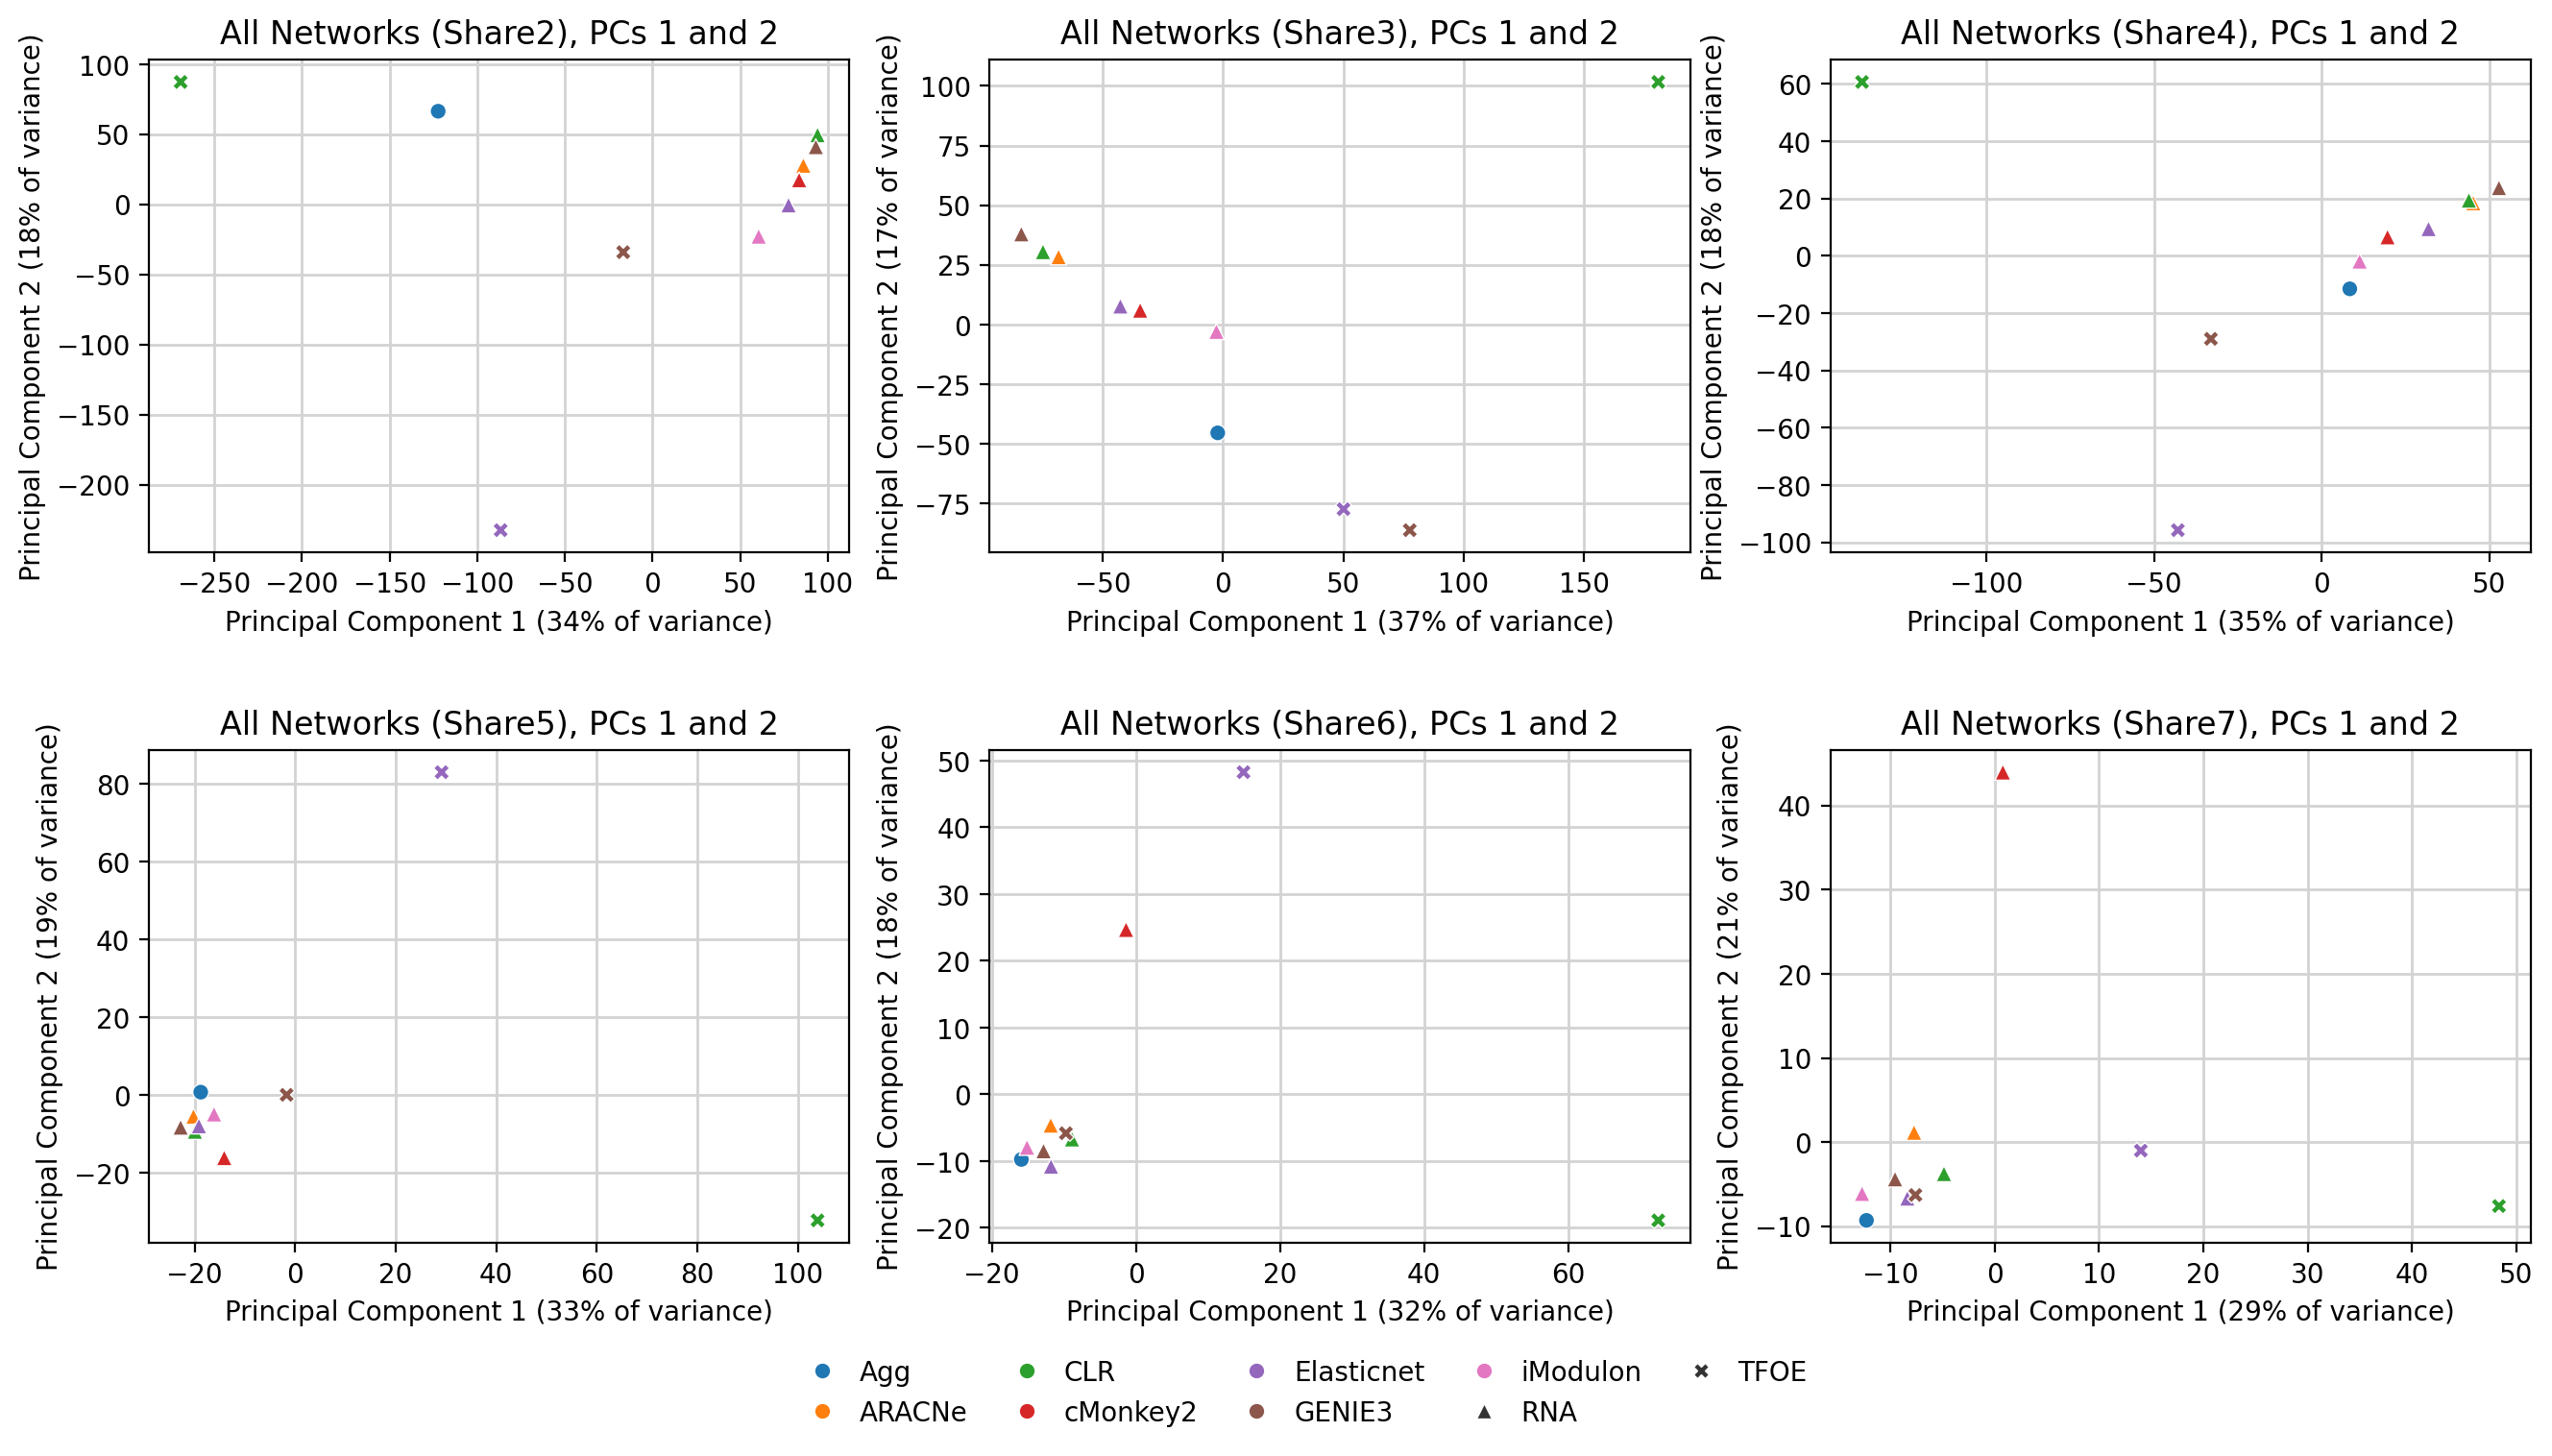

In [218]:
fig = plt.figure(figsize=(16, 8), dpi=200)
axs = fig.subplots(nrows=2, ncols=3, sharex=False, sharey=False, squeeze=True, gridspec_kw={'hspace': 0.4}).flatten()

network_counts_df = pd.DataFrame()

for i in range(len(axs)):
    network_counts = do_pca(axs[i], share_threshold=i+2, legend=i==0)
    network_counts_df[i+2] = network_counts
    if i == 0:
        sns.move_legend(
            axs[i], 'upper center', bbox_to_anchor=(0.5, 0.05), bbox_transform=fig.transFigure, ncols=5,
            fontsize='medium', frameon=False, title=None, handletextpad=0.4, columnspacing=1.2)

network_counts_df.insert(0, 0, [len(distenriched3_df)] + constituent_networks_df.iloc[valid_idxs]['truncated_df'].map(len).to_list())
network_counts_df

In [ ]:
pca = PCA()
feature_df_scaled = StandardScaler().fit_transform(feature_share_df.T) # pass in samples x features, returns samples x features
projection = pca.fit_transform(feature_df_scaled)
print('Projection:', projection.shape)                                 # returns samples x components

pca_var = np.cumsum(pca.explained_variance_ratio_)
k_comp = np.where(pca_var > 0.99)[0][0] + 1
print(f'Data: {len(feature_share_df.index)} regulatory relationships x {len(feature_share_df.columns)} networks')
print(f'Found {k_comp} dimensions from PCA')

fig = plt.figure(figsize=(16, 5), dpi=200)
axs = fig.subplots(nrows=1, ncols=2, sharex=False, sharey=False, squeeze=True).flatten()

for ax in axs:
    ax.set_axisbelow(True)
    ax.xaxis.grid(True, which='major', color='lightgrey', ls='-', lw=1)
    ax.yaxis.grid(True, which='major', color='lightgrey', ls='-', lw=1)

ax = sns.scatterplot(x=projection[:,0], y=projection[:,1],
    hue=feature_share_df.columns.to_series().map(lambda label: label.split('_')[0]), # hue represents Method
    style=feature_share_df.columns.to_series().map(lambda label: label.split('_')[1]), # style represents Dataset
    markers={
        'Agg': 'o',
        'TFOE': 'X',
        'RNA': '^',
    },
    legend=False, ax=axs[0],
)
ax.set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.0%} of variance)')
ax.set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.0%} of variance)')
# plt.tight_layout()
ax.set_title('All Networks (Share3), PCs 1 and 2');

ax = sns.scatterplot(x=projection[:,1], y=projection[:,2],
    hue=feature_share_df.columns.to_series().map(lambda label: label.split('_')[0]), # hue represents Method
    style=feature_share_df.columns.to_series().map(lambda label: label.split('_')[1]), # style represents Dataset
    markers={
        'Agg': 'o',
        'TFOE': 'X',
        'RNA': '^',
    },
    ax=axs[1],
)
ax.set_xlabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.0%} of variance)')
ax.set_ylabel(f'Principal Component 3 ({pca.explained_variance_ratio_[2]:.0%} of variance)')
# plt.tight_layout()
ax.set_title('All Networks (Share3), PCs 2 and 3');

sns.move_legend(
    ax, 'upper center', bbox_to_anchor=(-0.05, -0.2), ncols=5,
    fontsize='medium', frameon=False, title=None, handletextpad=0.4, columnspacing=1.2);

Projection: (10, 10)
Data: 16792 regulatory relationships x 10 networks
Found 9 dimensions from PCA
Projection: (10, 10)
Data: 16792 regulatory relationships x 10 networks
Found 9 dimensions from PCA


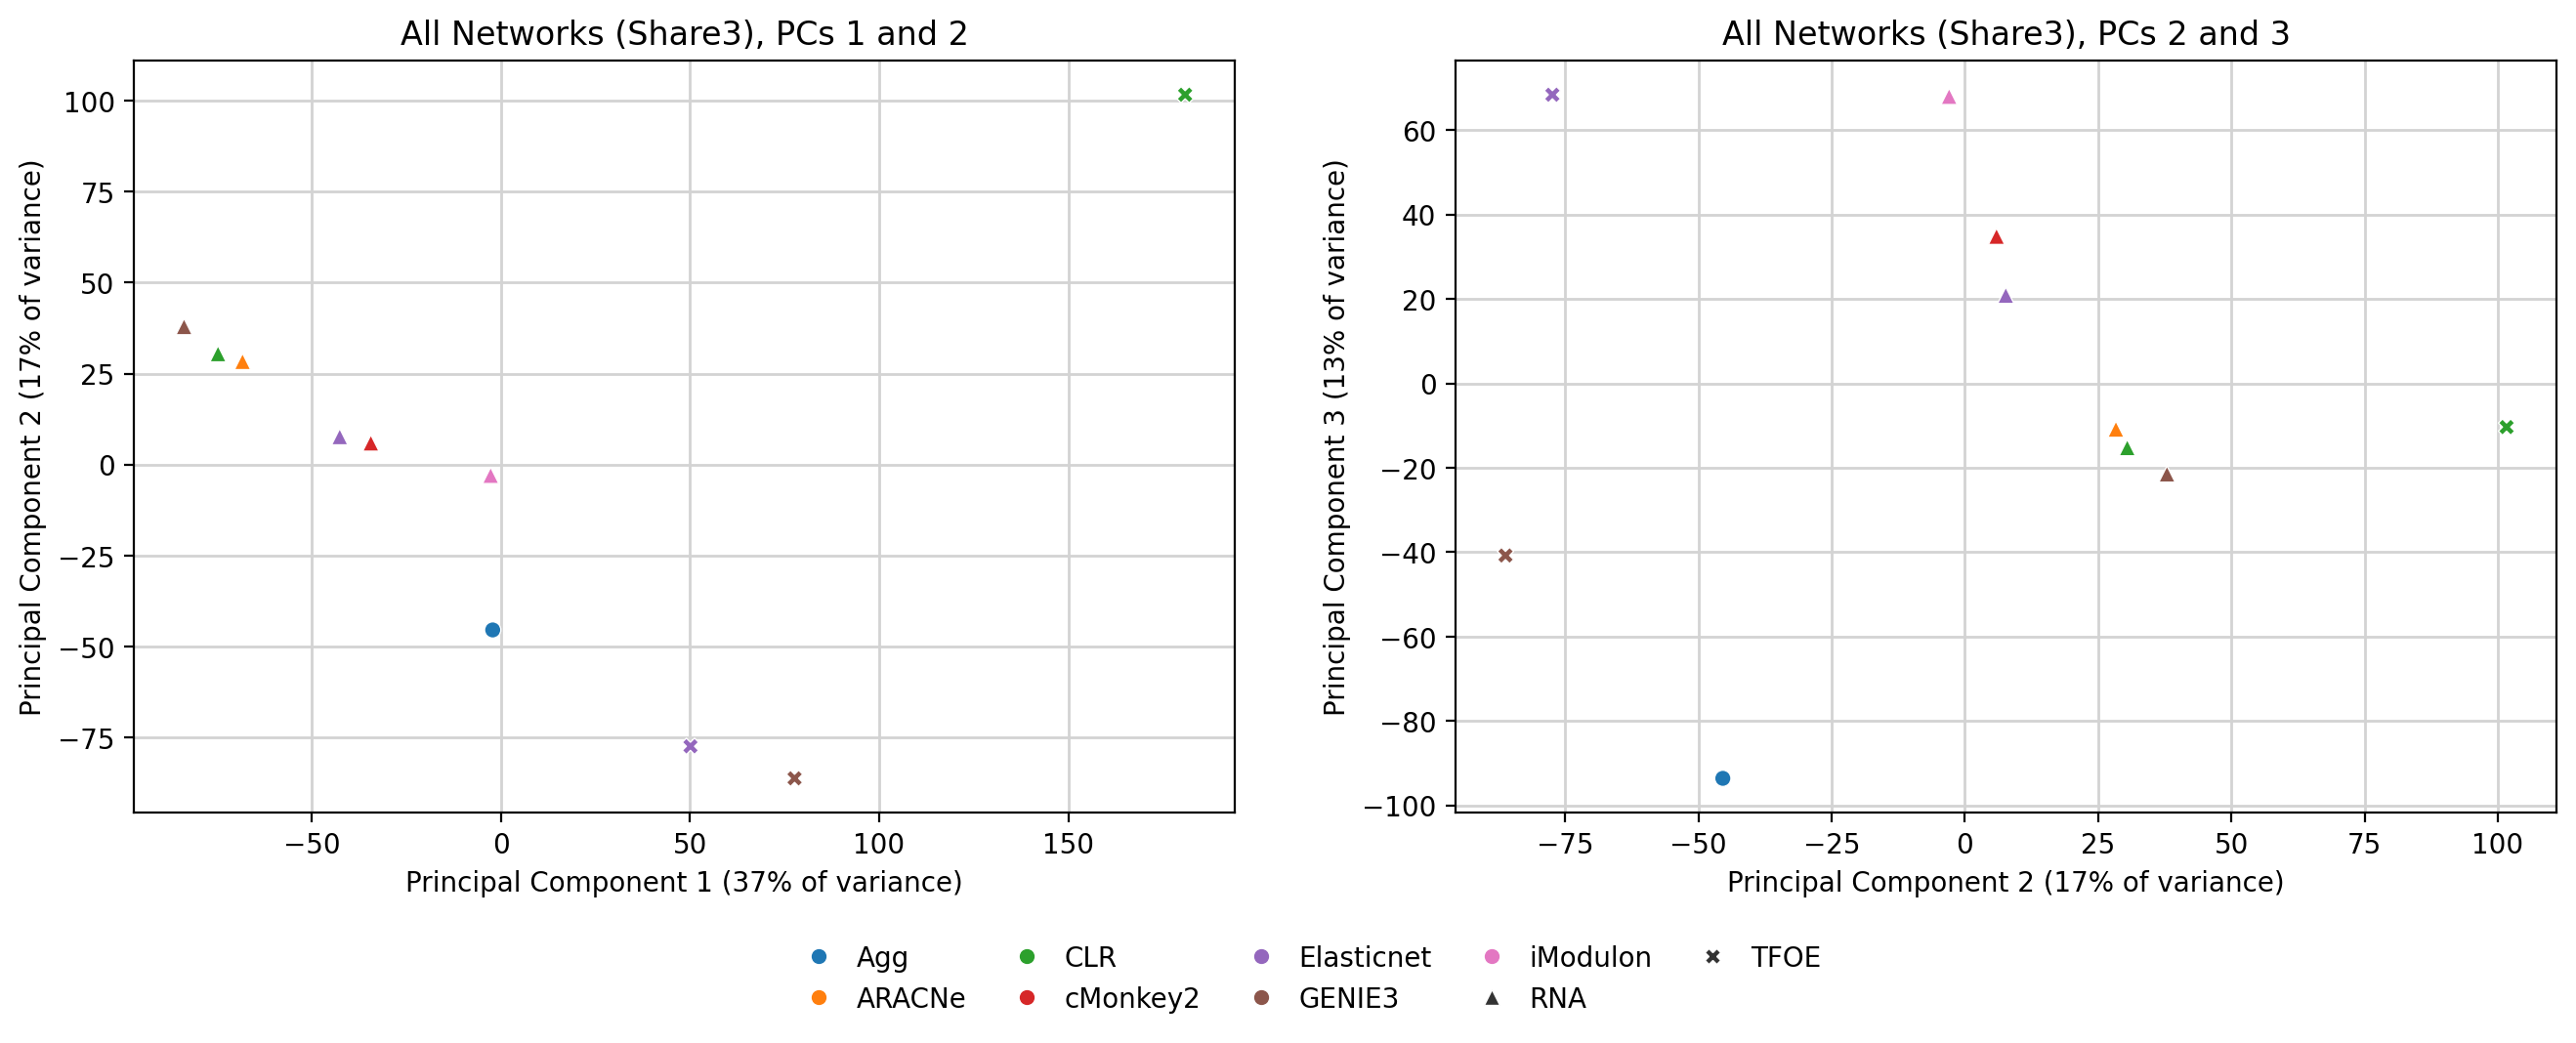

In [220]:
fig = plt.figure(figsize=(16, 5), dpi=200)
axs = fig.subplots(nrows=1, ncols=2, sharex=False, sharey=False, squeeze=True).flatten()

for i in range(len(axs)):
    _ = do_pca(axs[i], share_threshold=3, legend=i==0, pcs=(i+1, i+2))
    if i == 0:
        sns.move_legend(
            axs[i], 'upper center', bbox_to_anchor=(0.5, 0), bbox_transform=fig.transFigure, ncols=5,
            fontsize='medium', frameon=False, title=None, handletextpad=0.4, columnspacing=1.2)